In [35]:
import os
import numpy as np
import pandas as pd
import mne
import networkx as nx
import matplotlib.pyplot as plt
from scipy import stats
from scipy.signal import butter, filtfilt
import seaborn as sns

In [2]:
ruta_datos=r"C:\Users\ecere\Documents\GitHub\Neurociencias-2026-1\S06_proyecto\proyecto_Mercedes_Juárez\DATOS"
archivo_par = "{sub}_task-ThreeArmedBandit_eeg.set"
participantes_excel =r"C:\Users\ecere\Documents\GitHub\Neurociencias-2026-1\S06_proyecto\proyecto_Mercedes_Juárez\DATOS\Info_part.xlsx"
eeg_coords=r"C:\Users\ecere\Documents\GitHub\Neurociencias-2026-1\S06_proyecto\proyecto_Mercedes_Juárez\Datosss proyectos.xlsx"

In [3]:
eeg_coords = pd.read_excel(eeg_coords)  # eeg_coords es el nombre del archivo .xlsx

# Verificar las columnas
print(eeg_coords.columns)


Index(['name', 'x', 'y', 'z'], dtype='object')


In [4]:
BANDA = (8.0, 12.0)    # alpha (fmin, fmax)
BANDPASS = (1.0, 40.0) # filtro previo (low, high)
TH = 0.3               # umbral para cápsula
PORC = 0.6 

In [5]:
participants = pd.read_excel(participantes_excel)

# limpiamos espacios y estandarizamos
participants.columns = participants.columns.str.strip()

print(participants.columns)


Index(['participant_id', 'Original_ID', 'sex', 'age', 'GROUP', 'BDI', 'AUDIT',
       'EDUCATION'],
      dtype='object')


In [6]:
participants = pd.read_excel(participantes_excel)

# limpiar nombres de columnas
participants.columns = participants.columns.str.strip()

# obtener listas de participantes por grupo
grupo_control = participants[participants["GROUP"]=="CTRL"]["participant_id"].tolist()
grupo_riesgo  = participants[participants["GROUP"]=="AUD"]["participant_id"].tolist()

print("CTRL:", grupo_control)
print("AUD:", grupo_riesgo)

CTRL: ['sub-001', 'sub-002', 'sub-003', 'sub-004', 'sub-005', 'sub-006', 'sub-018', 'sub-019', 'sub-035', 'sub-036', 'sub-038', 'sub-039', 'sub-040', 'sub-041', 'sub-042', 'sub-043', 'sub-044', 'sub-045', 'sub-046', 'sub-047', 'sub-048', 'sub-049', 'sub-050', 'sub-051', 'sub-052', 'sub-053']
AUD: ['sub-007', 'sub-008', 'sub-009', 'sub-010', 'sub-011', 'sub-012', 'sub-013', 'sub-014', 'sub-015', 'sub-016', 'sub-017', 'sub-020', 'sub-021', 'sub-022', 'sub-023', 'sub-024', 'sub-025', 'sub-026', 'sub-027', 'sub-028', 'sub-029', 'sub-030', 'sub-031', 'sub-032', 'sub-033', 'sub-034', 'sub-037']


In [24]:
import os
import mne

def cargar_raw(sub): 
    archivo = archivo_par.format(sub=sub) 
    path = os.path.join(ruta_datos, archivo)

    os.environ["MNE_USE_C_STREAM"] = "false"

    raw = mne.io.read_raw_eeglab(
        path,
        preload=True,
        uint16_codec=None,
        verbose=False
    )
    return raw

In [8]:
#Filtrado dependiendo de la banda 
def bandpass(x, fs, low, high, order=4):
    b, a = butter(order, [low/(fs/2), high/(fs/2)], btype='band')
    return filtfilt(b, a, x)

In [25]:
def filtrar_banda(raw, low, high): 
    data = raw.get_data()      # canales × muestras 
    fs = raw.info["sfreq"] 
 
    filtrado = np.array([bandpass(ch, fs, low, high) for ch in data]) 
    return filtrado, raw.ch_names

In [10]:
def matriz_conectividad(datos, canales): 
    N = len(canales) 
    M = np.zeros((N, N)) 
 
    for i in range(N): 
        for j in range(N): 
            M[i, j] = np.corrcoef(datos[i], datos[j])[0, 1] 
 
    return pd.DataFrame(M, index=canales, columns=canales)

In [26]:
def normalizar_matrices(lista_mats): 
    return [(m - m.values.min()) / (m.values.max() - m.values.min()) for m in lista_mats] 

In [27]:
def capsula(lista_dfs, th, porcentaje_): 
    stack = np.stack([df.values for df in lista_dfs]) 
    above = stack > th 
 
    N = len(lista_dfs) 
    count_above = above.sum(axis=0) 
    min_requerido = int(np.ceil(porcentaje_ * N)) 
 
    result_bool = count_above >= min_requerido 
 
    return pd.DataFrame(
        result_bool.astype(int),
        index=lista_dfs[0].index,
        columns=lista_dfs[0].columns
    )

In [32]:
def procesar_grupo(lista_sujetos): 
    matrices_norm = [] 
    canales_ref = None  

    for idx, sub in enumerate(lista_sujetos): 
        print("Procesando:", sub) 
        
        raw = cargar_raw(sub) 
        
        df_raw = raw.to_data_frame()
        display(df_raw.head())
        
        datos_filt, canales = filtrar_banda(raw, BANDA[0], BANDA[1])
        df_filt = pd.DataFrame(datos_filt.T, columns=canales)
        display(df_filt.head())
        
        mat = matriz_conectividad(datos_filt, canales)
        mat_norm = normalizar_matrices([mat])[0]

        if idx == 0:
            canales_ref = set(mat_norm.index)
        else:
            # intersección: solo dejamos canales comunes
            canales_ref = canales_ref.intersection(mat_norm.index)

        matrices_norm.append(mat_norm)

    canales_ref = list(canales_ref)

    matrices_norm_iguales = [
        m.loc[canales_ref, canales_ref] for m in matrices_norm
    ]

    matriz_capsulada = capsula(matrices_norm_iguales, TH, PORC)

    return matrices_norm_iguales, matriz_capsulada


In [33]:
mats_ctrl, caps_ctrl   = procesar_grupo(grupo_control) 
mats_riesgo, caps_riesgo = procesar_grupo(grupo_riesgo)

Procesando: sub-001


C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(
C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(


,time,Fp1,Fz,F3,F7,FC1,C3,T7,CP1,Pz,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,0.000,12.226552,3.925241,8.840668,5.420321,2.862918,6.568016,12.986842,6.093926,1.615224,...,1.597059,5.100646,2.106302,4.747872,5.165445,-10.239489,2.596941,2.990932,4.977772,12.462591
1,0.002,11.569060,2.935610,7.890375,5.666006,2.893619,5.349332,13.376076,5.743618,0.936378,...,1.546342,0.890017,2.286213,4.673976,6.176642,0.347497,4.901796,3.495244,2.236508,0.612638
2,0.004,8.612667,1.895420,5.667140,0.637128,2.093665,2.078724,5.413764,4.317379,-0.281102,...,-0.507314,-1.419088,3.243654,3.817128,7.135813,4.679541,6.763851,2.874907,4.961544,4.676880
3,0.006,9.607401,3.050780,6.467839,-2.049111,2.172047,-0.411779,-3.820020,3.231220,-1.744251,...,-1.487741,-3.486833,3.660258,3.886310,7.603503,4.367961,9.306156,3.473679,7.830634,9.518617
4,0.008,7.375556,1.372408,5.556149,-1.855589,0.394393,-0.852644,-4.803797,3.412876,-0.425730,...,-2.713301,-8.487049,3.877819,3.074878,5.821899,10.106108,6.181062,2.459540,5.814501,5.909348


,Fp1,Fz,F3,F7,FC1,C3,T7,CP1,Pz,P3,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,7.167214e-07,-1.688381e-07,7.044771e-08,8.727198e-07,-2.433255e-07,2.381734e-07,8.462660e-07,3.125890e-07,5.995931e-07,1.237010e-06,...,1.113710e-07,1.057926e-06,6.059834e-07,-1.523006e-07,2.765000e-07,9.490950e-07,7.049696e-07,-1.750798e-07,5.080330e-07,6.701789e-07
1,4.257355e-07,-2.894340e-07,-1.417803e-07,2.047661e-07,-3.716471e-07,-2.046380e-07,-3.530482e-07,3.477363e-08,7.099757e-07,7.636375e-07,...,9.130652e-08,7.801264e-07,7.350230e-07,-2.369732e-07,3.507797e-07,1.713345e-06,9.085486e-07,-1.057051e-07,6.346905e-07,4.249900e-07
2,1.308212e-07,-3.998228e-07,-3.475369e-07,-4.702857e-07,-4.912243e-07,-6.436726e-07,-1.545033e-06,-2.439311e-07,8.088817e-07,2.803377e-07,...,7.090058e-08,4.868517e-07,8.513082e-07,-3.141825e-07,4.240930e-07,2.449905e-06,1.103147e-06,-2.775190e-08,7.577682e-07,1.723131e-07
3,-1.625039e-07,-4.976623e-07,-5.430142e-07,-1.140007e-06,-5.997596e-07,-1.071598e-06,-2.710257e-06,-5.191225e-07,8.942773e-07,-2.055270e-07,...,5.028658e-08,1.819629e-07,9.526537e-07,-3.826087e-07,4.951977e-07,3.146720e-06,1.285180e-06,5.787252e-08,8.756773e-07,-8.285748e-08
4,-4.487837e-07,-5.809045e-07,-7.246411e-07,-1.791999e-06,-6.951859e-07,-1.481281e-06,-3.829782e-06,-7.864555e-07,9.643559e-07,-6.865903e-07,...,2.957701e-08,-1.304613e-07,1.037132e-06,-4.411411e-07,5.628152e-07,3.792399e-06,1.451187e-06,1.500280e-07,9.868251e-07,-3.354735e-07


Procesando: sub-002


C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: Limited 3 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(
C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(


,time,Fp1,Fz,F3,FC5,FC1,C3,T7,CP5,CP1,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,0.000,15.775508,2.224616,3.380927,4.190636,-0.511228,-0.900209,11.649176,-2.059768,-1.796570,...,-4.990414,-4.887169,-9.093917,-0.029617,2.552337,-7.788314,5.834495,1.423929,10.190113,7.129965
1,0.002,16.281752,3.017807,5.751080,2.854766,0.467093,-0.315547,16.643362,-1.825900,-1.646406,...,-4.413561,-7.113821,-8.029785,2.335664,3.704402,1.948560,9.280013,2.156361,12.080489,10.536347
2,0.004,3.702919,0.982895,3.095729,19.637720,1.009809,2.665003,13.822212,1.292595,-3.056779,...,-4.223820,-6.309044,-0.517061,2.212641,4.663992,13.250511,9.651641,2.502499,11.432559,11.209679
3,0.006,-3.162199,0.270267,0.981277,33.836372,0.433327,6.674257,21.252127,5.830882,-1.340185,...,-4.518844,-2.765806,0.260661,0.236076,2.110789,7.709329,3.922022,0.655697,7.025599,3.144073
4,0.008,4.963709,-1.415006,-1.568844,2.823770,-2.092433,-4.742861,20.427242,-0.027437,-2.453653,...,-4.322067,1.953394,3.336581,1.874717,3.954944,9.299612,6.446609,0.912824,9.943571,6.944973


,Fp1,Fz,F3,FC5,FC1,C3,T7,CP5,CP1,Pz,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,7.138727e-07,-3.244744e-07,2.610423e-08,-5.651123e-07,-3.214845e-07,-3.578917e-07,4.689828e-07,-5.463622e-07,-2.454962e-07,-8.650853e-07,...,-1.026038e-06,-1.637862e-06,-1.434771e-07,-2.221380e-07,-4.843824e-07,-5.053705e-07,-2.667652e-07,-3.642325e-07,-1.680048e-07,-4.273862e-07
1,4.644836e-07,-4.242853e-07,-9.914904e-08,-7.810950e-07,-4.579796e-07,-4.904378e-07,4.300161e-07,-4.677740e-07,-2.748581e-07,-8.875630e-07,...,-7.636473e-07,-1.324786e-06,5.504221e-07,-2.645620e-07,-3.790277e-07,2.560226e-07,-2.410319e-08,-2.983020e-07,-3.273626e-08,-1.902068e-07
2,1.989439e-07,-5.178523e-07,-2.241314e-07,-9.878995e-07,-5.863276e-07,-6.160544e-07,3.763233e-07,-3.878451e-07,-3.003438e-07,-8.964412e-07,...,-4.893993e-07,-9.892294e-07,1.232698e-06,-3.029105e-07,-2.672900e-07,1.009995e-06,2.185450e-07,-2.270931e-07,1.014782e-07,4.666962e-08
3,-7.879973e-08,-6.038843e-07,-3.472083e-07,-1.182328e-06,-7.047682e-07,-7.329829e-07,3.074831e-07,-3.081105e-07,-3.216072e-07,-8.911765e-07,...,-2.072589e-07,-6.361095e-07,1.892780e-06,-3.367319e-07,-1.510551e-07,1.744755e-06,4.570787e-07,-1.520144e-07,2.321684e-07,2.793123e-07
4,-3.644593e-07,-6.812078e-07,-4.667592e-07,-1.361342e-06,-8.117211e-07,-8.395997e-07,2.234524e-07,-2.300148e-07,-3.383637e-07,-8.714562e-07,...,7.868451e-08,-2.706547e-07,2.520520e-06,-3.656473e-07,-3.228993e-08,2.448889e-06,6.874739e-07,-7.454729e-08,3.569495e-07,5.039172e-07


Procesando: sub-003


C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(
C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(


,time,Fp1,Fz,F3,F7,FC5,FC1,C3,CP5,CP1,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,0.000,-13.246951,-6.806177,-9.775488,-19.156590,-10.520302,-10.996074,0.727408,-8.270491,6.605759,...,-3.393795,-28.743734,-8.918324,1.995952,-9.774734,-19.341658,-10.138719,-1.953026,-11.963066,-12.027378
1,0.002,-15.448349,-7.692113,-11.582151,-19.784660,-12.010004,-12.159839,-2.618210,-8.565537,6.045304,...,-5.092563,-31.248167,-11.329667,0.155006,-9.741163,-28.109344,-10.380413,-3.864611,-15.826155,-16.307329
2,0.004,-18.333662,-10.629322,-13.340639,-22.659145,-13.939590,-15.422071,-5.427602,-13.255882,2.993532,...,-7.671143,-36.682262,-11.203108,-1.491629,-12.296108,-30.773455,-12.282043,-6.559371,-15.295019,-18.438456
3,0.006,-20.047438,-11.467417,-13.879080,-21.481226,-14.893049,-17.511301,-5.552328,-15.212618,2.137951,...,-7.711556,-30.739378,-11.175357,-2.358008,-13.972770,-31.142588,-13.744010,-7.254091,-15.447791,-22.619987
4,0.008,-17.757658,-12.403663,-13.343962,-17.325127,-13.356712,-17.988092,-6.361523,-15.656446,2.111381,...,-6.385673,-18.155844,-11.832342,-2.541778,-14.087551,-27.800734,-19.112022,-6.485865,-16.333309,-27.240608


,Fp1,Fz,F3,F7,FC5,FC1,C3,CP5,CP1,Pz,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,-0.000003,-0.000004,-0.000004,-0.000004,-0.000003,-0.000003,-0.000002,-0.000003,-9.240451e-07,-0.000001,...,-1.822111e-07,-0.000002,-0.000002,-0.000001,-0.000003,-0.000002,-0.000002,-0.000004,-0.000003,-0.000003
1,-0.000004,-0.000004,-0.000004,-0.000004,-0.000004,-0.000004,-0.000003,-0.000004,-1.311183e-06,-0.000001,...,-6.914767e-07,-0.000002,-0.000002,-0.000002,-0.000003,-0.000003,-0.000003,-0.000004,-0.000003,-0.000004
2,-0.000004,-0.000005,-0.000005,-0.000005,-0.000004,-0.000004,-0.000003,-0.000005,-1.679789e-06,-0.000002,...,-1.193396e-06,-0.000003,-0.000003,-0.000002,-0.000004,-0.000004,-0.000004,-0.000005,-0.000004,-0.000004
3,-0.000005,-0.000005,-0.000005,-0.000006,-0.000005,-0.000005,-0.000004,-0.000006,-2.023470e-06,-0.000002,...,-1.679684e-06,-0.000003,-0.000004,-0.000002,-0.000004,-0.000004,-0.000004,-0.000005,-0.000004,-0.000005
4,-0.000005,-0.000006,-0.000006,-0.000007,-0.000005,-0.000005,-0.000004,-0.000007,-2.336216e-06,-0.000002,...,-2.142268e-06,-0.000004,-0.000004,-0.000002,-0.000005,-0.000005,-0.000005,-0.000006,-0.000005,-0.000006


Procesando: sub-004


C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: Limited 3 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(
C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(


,time,Fz,F3,F7,FC5,FC1,C3,T7,TP9,CP5,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,0.000,-33.842136,-26.237417,-18.356428,-32.743099,-13.515633,-12.646343,-0.328085,-2.176887,-1.594334,...,16.603289,5.183491,27.846037,6.605702,3.707104,-0.321776,-9.018526,-0.385768,1.597826,8.934278
1,0.002,-33.038540,-26.007088,-18.708733,-31.944048,-11.450702,-11.969484,-17.838408,-22.278593,-1.462646,...,10.686101,4.424008,20.242056,5.185191,2.113245,-0.194864,-9.508779,-0.615216,2.062705,9.502333
2,0.004,-28.813913,-22.747828,-12.663033,-25.917967,-7.773860,-9.144153,-22.312038,-15.230899,0.084593,...,9.358252,-2.683574,15.126461,6.693971,3.547171,6.376389,-4.090350,3.158552,7.507327,13.241625
3,0.006,-27.857759,-18.803415,-10.815051,-22.819195,-6.830817,-8.760196,-10.575145,0.460344,3.535668,...,8.664667,-7.936138,17.577404,6.591037,3.126055,7.770895,-1.601150,4.197268,8.752016,13.609221
4,0.008,-25.531454,-17.591839,-9.649179,-23.575508,-5.936028,-8.180896,-19.737095,-5.917747,13.871051,...,4.845586,-9.624708,11.188656,5.364680,0.898716,3.939832,-4.384945,2.647431,6.968656,12.655935


,Fz,F3,F7,FC5,FC1,C3,T7,TP9,CP5,Pz,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,-1.237279e-06,-1.220185e-06,-1.679628e-06,-2.827241e-07,-1.198624e-07,-7.841927e-07,-0.000004,-1.717961e-06,-1.405593e-06,-4.908830e-07,...,-8.536983e-07,0.000002,6.964804e-07,6.505827e-07,1.779252e-06,4.852840e-07,-3.258961e-07,-6.356073e-07,-1.983514e-07,0.000001
1,-5.045701e-07,-5.437629e-07,-4.799279e-07,6.216834e-07,4.114503e-07,-3.645389e-07,-0.000003,-1.158563e-06,-9.720839e-07,-5.082845e-07,...,-1.715393e-06,0.000003,-4.628086e-08,3.718864e-07,1.298415e-06,8.356191e-07,-6.933444e-07,-3.512352e-07,1.353166e-07,0.000001
2,2.475803e-07,1.531386e-07,7.435529e-07,1.530633e-06,9.440363e-07,6.924718e-08,-0.000003,-5.573243e-07,-5.125256e-07,-5.131485e-07,...,-2.550362e-06,0.000003,-7.882549e-07,8.765512e-08,7.956875e-07,1.174192e-06,-1.046603e-06,-5.475238e-08,4.721234e-07,0.000002
3,1.007553e-06,8.597131e-07,1.971498e-06,2.429289e-06,1.469117e-06,5.104417e-07,-0.000002,7.750719e-08,-3.411503e-08,-5.045079e-07,...,-3.346101e-06,0.000003,-1.519993e-06,-1.988758e-07,2.764374e-07,1.494466e-06,-1.381097e-06,2.487905e-07,8.058637e-07,0.000002
4,1.763400e-06,1.564793e-06,3.184235e-06,3.302736e-06,1.977906e-06,9.520531e-07,-0.000001,7.367267e-07,4.554400e-07,-4.816755e-07,...,-4.090800e-06,0.000003,-2.232280e-06,-4.844599e-07,-2.537106e-07,1.790157e-06,-1.692647e-06,5.541001e-07,1.130277e-06,0.000002


Procesando: sub-005


C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(
C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(


,time,Fz,F3,F7,FC5,FC1,C3,T7,TP9,CP5,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,0.000,9.333055,11.461390,-1.616126,6.905405,7.564956,4.493802,1.868676,-6.575767,6.389737,...,0.449716,3.122288,6.741988,2.081645,2.469868,0.622438,0.754784,5.976399,0.007734,18.995216
1,0.002,10.703213,14.092020,5.453329,17.634611,8.597100,7.419012,14.889614,8.829965,12.371990,...,-0.574369,2.243774,7.563475,3.013458,6.470578,2.428168,1.329735,8.898254,2.406134,9.852554
2,0.004,11.047142,14.182372,13.302355,14.934734,8.212186,6.437171,9.599153,17.789431,6.536882,...,-1.403855,3.220092,5.649607,4.774857,7.052659,-13.833464,3.222614,10.354092,3.582702,2.320246
3,0.006,10.364847,13.636744,17.487583,2.028423,6.556700,1.841250,3.282441,2.529195,1.384407,...,0.939773,1.998508,13.305077,7.170531,15.544239,-9.637061,10.046710,11.076338,4.269868,0.158067
4,0.008,10.804768,14.798882,13.956269,0.546533,8.366973,-0.411721,-10.896462,-0.671453,-2.255358,...,2.940895,4.584886,13.733012,7.612591,13.341806,2.956832,15.161405,10.772027,6.664906,3.658993


,Fz,F3,F7,FC5,FC1,C3,T7,TP9,CP5,CP1,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,-6.287407e-07,-0.000002,-9.051450e-07,-8.799401e-07,-3.574446e-07,-5.388126e-08,4.701564e-07,8.929368e-07,3.738671e-07,1.569475e-07,...,3.851536e-07,0.000001,7.639308e-07,-6.771982e-08,-1.750550e-09,4.081199e-08,-2.346570e-07,-2.580212e-07,-7.786183e-10,-9.649801e-07
1,-7.291202e-07,-0.000002,-1.524710e-06,-1.090958e-06,-5.023920e-07,-1.548101e-07,6.474362e-07,1.580441e-06,5.942696e-07,1.226829e-07,...,4.185775e-07,0.000002,8.586219e-07,-1.465184e-07,1.106723e-07,2.849330e-07,-1.210350e-07,-2.010990e-07,3.462383e-07,-1.310299e-06
2,-8.154911e-07,-0.000002,-2.105859e-06,-1.274563e-06,-6.373164e-07,-2.489464e-07,8.195290e-07,2.244098e-06,8.059979e-07,8.689548e-08,...,4.404427e-07,0.000002,9.371239e-07,-2.249265e-07,2.207139e-07,5.228309e-07,-5.253013e-09,-1.380597e-07,6.889154e-07,-1.640781e-06
3,-8.861817e-07,-0.000001,-2.639351e-06,-1.428082e-06,-7.599485e-07,-3.347455e-07,9.828726e-07,2.873305e-06,1.005315e-06,5.019545e-08,...,4.502236e-07,0.000003,9.975387e-07,-3.016792e-07,3.264236e-07,7.509025e-07,1.110869e-07,-6.994934e-08,1.021903e-06,-1.950327e-06
4,-9.398199e-07,-0.000001,-3.116965e-06,-1.549507e-06,-8.682562e-07,-4.108726e-07,1.133979e-06,3.458030e-06,1.188688e-06,1.320088e-08,...,4.476788e-07,0.000003,1.038309e-06,-3.755053e-07,4.259356e-07,9.657262e-07,2.263660e-07,2.057004e-09,1.339997e-06,-2.233109e-06


Procesando: sub-006


C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(
C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(


,time,Fp1,Fz,F3,F7,FC5,FC1,C3,T7,CP5,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,0.000,-9.275697,14.241713,2.257954,6.322174,13.559667,34.444405,13.713159,8.233001,6.825528,...,6.758374,2.426297,0.118993,4.846447,10.275178,-9.476006,-12.658998,1.824486,-11.625225,-10.588123
1,0.002,-5.814978,16.917368,4.803114,4.306411,15.069959,37.043289,14.621477,4.095683,5.898528,...,6.209261,0.600703,0.327139,5.353264,11.320125,1.958540,-9.623649,4.530492,-9.979677,-2.276926
2,0.004,-9.335865,15.245669,4.858786,6.833654,14.674503,36.266617,13.576081,0.545830,4.189747,...,5.024993,-1.225078,-1.173954,3.808856,9.042540,-0.181187,-13.667764,3.818915,-14.045558,-5.196092
3,0.006,-10.170391,14.500075,4.817545,18.493731,17.500269,35.923050,13.409010,1.245534,6.240208,...,5.939942,-2.269805,-0.429215,3.777680,11.450255,-7.399105,-12.144870,4.133115,-13.129515,-7.382732
4,0.008,-14.226759,12.483345,2.189154,15.897952,16.857817,32.936485,10.702300,-4.889209,6.092882,...,6.024419,-0.482705,2.366040,3.794897,10.828448,-4.607337,-10.084271,1.420356,-13.921009,-6.053650


,Fp1,Fz,F3,F7,FC5,FC1,C3,T7,CP5,CP1,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,0.000001,3.876919e-07,3.214111e-07,5.254908e-07,9.416341e-07,-9.989352e-09,9.074005e-07,1.046857e-08,7.045599e-07,1.916202e-07,...,1.968698e-07,6.057994e-07,5.867306e-07,2.458769e-08,4.400912e-07,0.000001,0.000001,5.939798e-07,0.000001,0.000002
1,0.000001,3.705106e-07,6.125974e-07,9.943162e-07,1.721685e-06,9.413938e-08,9.657094e-07,5.482177e-07,1.022514e-06,1.861435e-07,...,2.775718e-07,9.469778e-07,7.646596e-07,-4.182159e-08,5.867074e-07,0.000002,0.000002,6.252544e-07,0.000001,0.000002
2,0.000002,3.548634e-07,9.039308e-07,1.451378e-06,2.483625e-06,2.025146e-07,1.010683e-06,1.087716e-06,1.330109e-06,1.797381e-07,...,3.554947e-07,1.280111e-06,9.357925e-07,-1.057353e-07,7.295952e-07,0.000003,0.000002,6.538300e-07,0.000001,0.000002
3,0.000002,3.408197e-07,1.190534e-06,1.887918e-06,3.214610e-06,3.134424e-07,1.041162e-06,1.618568e-06,1.621730e-06,1.724704e-07,...,4.289057e-07,1.598892e-06,1.096686e-06,-1.663497e-07,8.659885e-07,0.000003,0.000003,6.787456e-07,0.000001,0.000002
4,0.000003,3.282996e-07,1.467451e-06,2.295456e-06,3.902166e-06,4.250958e-07,1.056202e-06,2.130343e-06,1.891931e-06,1.643887e-07,...,4.961161e-07,1.897135e-06,1.243977e-06,-2.229506e-07,9.931301e-07,0.000004,0.000003,6.989770e-07,0.000001,0.000003


Procesando: sub-018


C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: Limited 3 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(
C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(


,time,Fp1,Fz,F3,F7,FC5,FC1,C3,T7,CP5,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,0.000,-44.951359,-13.609046,-18.592554,-24.354548,-0.921946,-7.621576,-5.267097,-15.937204,-6.324994,...,-1.718693,1.589417,-5.021518,-3.829101,-6.506627,-14.549730,-8.796357,-10.345029,-12.089475,-35.713932
1,0.002,-48.378189,-16.928684,-24.939165,-38.197491,-7.723328,-8.626395,-8.269215,-33.039761,-10.098904,...,-2.852578,-3.297413,-6.551832,-2.171979,-6.113656,-4.246571,-11.421262,-15.523076,-16.770159,-13.161797
2,0.004,-70.746254,-21.614511,-34.653297,-52.281567,-19.748339,-12.267715,-11.417371,-32.563816,-12.798517,...,-4.719373,-7.697034,-8.620131,-5.495471,-11.043276,-10.595533,-16.634768,-19.040499,-35.073143,-16.342310
3,0.006,-92.329025,-17.998566,-31.182232,-50.932961,-25.082922,-8.926399,-10.072895,-25.886318,-11.005865,...,-1.459703,-4.285220,-4.927588,-2.178485,-7.135333,-7.961850,-10.862659,-14.989101,-44.000397,-23.087524
4,0.008,-87.882401,-15.553516,-24.193956,-43.526688,-18.404818,-7.342685,-8.532664,-11.200630,-6.478757,...,-2.106770,0.541555,-2.505447,-1.644850,-6.303890,-3.132628,-10.022911,-15.429440,-23.385920,-29.930664


,Fp1,Fz,F3,F7,FC5,FC1,C3,T7,CP5,CP1,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,-3.514983e-07,2.979268e-07,4.250034e-07,9.950796e-07,7.768487e-07,2.528569e-07,7.108884e-07,-9.712768e-08,4.478604e-07,1.183057e-08,...,1.815681e-07,-8.246461e-07,3.553437e-08,1.015462e-07,1.476406e-07,1.918935e-07,1.389697e-06,3.506685e-07,1.288397e-06,-4.354421e-07
1,-3.738442e-07,3.405049e-07,4.383198e-07,1.053762e-06,4.335382e-07,2.661934e-07,7.430198e-07,2.571194e-07,5.624014e-07,4.602306e-08,...,-9.654033e-08,-1.547936e-06,-1.197683e-07,-5.456892e-09,5.936656e-08,8.599577e-07,1.283702e-06,2.487583e-07,1.068863e-06,2.195763e-07
2,-3.832622e-07,3.761456e-07,4.425599e-07,1.090303e-06,8.319181e-08,2.746663e-07,7.651279e-07,6.063838e-07,6.695178e-07,8.181274e-08,...,-3.739106e-07,-2.248860e-06,-2.759481e-07,-1.129893e-07,-3.338144e-08,1.507143e-06,1.149141e-06,1.387684e-07,8.259824e-07,8.711399e-07
3,-3.784285e-07,4.045124e-07,4.376452e-07,1.104470e-06,-2.681343e-07,2.782030e-07,7.766612e-07,9.447755e-07,7.674916e-07,1.187538e-07,...,-6.458297e-07,-2.915196e-06,-4.299726e-07,-2.192527e-07,-1.286947e-07,2.123837e-06,9.884022e-07,2.295600e-08,5.639510e-07,1.510541e-06
4,-3.583644e-07,4.254212e-07,4.236844e-07,1.096485e-06,-6.143810e-07,2.768264e-07,7.772168e-07,1.266599e-06,8.547332e-07,1.563462e-07,...,-9.076577e-07,-3.535249e-06,-5.787795e-07,-3.224562e-07,-2.245485e-07,2.701094e-06,8.044652e-07,-9.624893e-08,2.874086e-07,2.129318e-06


Procesando: sub-019


C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(
C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(


,time,Fp1,Fz,F3,F7,FC5,FC1,C3,T7,CP5,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,0.000,13.727066,7.953552,17.960773,16.433287,17.771843,6.443654,2.519812,11.570416,9.069707,...,-5.833448,5.940257,-4.633250,1.032725,-0.383334,-5.962388,3.545340,6.095550,7.353570,3.066476
1,0.002,9.613637,9.065108,12.724602,7.416906,5.921560,5.026941,-2.290308,12.896145,-6.703662,...,-3.916232,7.098310,1.414318,2.040072,0.824723,-4.115077,3.857477,5.082129,4.988954,3.334011
2,0.004,8.525247,6.953907,11.638045,15.829812,2.469023,4.000762,-1.387456,11.389618,-10.221004,...,-4.196326,3.617721,1.113599,1.826839,1.349401,-1.681483,5.585251,4.508101,8.190351,3.161700
3,0.006,7.776340,6.795725,11.234303,11.154422,11.759939,4.781130,1.224463,10.029358,-3.972549,...,-4.622953,-6.161657,-2.556892,1.369587,0.751242,1.143092,5.603661,5.398852,9.731194,2.696010
4,0.008,9.075892,6.979233,9.267276,5.793077,6.938841,4.780153,2.371621,5.446230,1.104208,...,-2.461741,-1.243726,-4.030748,0.277688,1.471644,1.331311,4.449813,7.314924,10.343898,2.425207


,Fp1,Fz,F3,F7,FC5,FC1,C3,T7,CP5,Pz,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,0.000002,1.244821e-06,-1.833304e-09,1.217204e-06,1.495058e-06,1.054399e-06,0.000001,9.348832e-07,0.000001,-4.234800e-07,...,0.000001,0.000003,0.000003,3.804300e-07,0.000001,0.000002,0.000002,0.000002,0.000002,0.000002
1,0.000002,1.140275e-06,-7.797944e-07,1.100000e-06,1.299740e-06,8.406607e-07,0.000001,5.806537e-07,0.000001,-1.679465e-07,...,0.000002,0.000003,0.000003,9.925398e-08,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002
2,0.000002,1.015897e-06,-1.543485e-06,9.628801e-07,1.079859e-06,6.098092e-07,0.000001,2.183994e-07,0.000001,9.059263e-08,...,0.000002,0.000003,0.000003,-1.834771e-07,0.000002,0.000003,0.000002,0.000002,0.000003,0.000002
3,0.000002,8.731596e-07,-2.281005e-06,8.075567e-07,8.386090e-07,3.653671e-07,0.000001,-1.461092e-07,0.000001,3.478803e-07,...,0.000003,0.000004,0.000003,-4.632651e-07,0.000002,0.000003,0.000002,0.000002,0.000003,0.000003
4,0.000002,7.138714e-07,-2.980931e-06,6.360753e-07,5.796066e-07,1.111472e-07,0.000001,-5.070967e-07,0.000001,5.996692e-07,...,0.000003,0.000004,0.000004,-7.356629e-07,0.000002,0.000004,0.000002,0.000002,0.000004,0.000003


Procesando: sub-035


C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(
C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(


,time,Fp1,Fz,F3,F7,FC5,FC1,C3,CP5,CP1,...,P2,CP4,TP8,C6,C2,FC4,FT8,F6,AF4,AF8
0,0.000,-0.257039,9.021169,5.578343,9.511835,-2.117969,7.917479,12.101703,-11.893224,-8.580252,...,-2.542238,5.416955,-1.804191,9.081229,2.050231,-4.919214,1.493760,-0.562022,-21.487522,-6.682331
1,0.002,-2.580084,10.096964,6.996252,7.601807,-2.974886,8.899494,13.434589,-10.984643,-7.728153,...,-1.524285,4.556056,-0.478309,11.212879,2.748304,-4.746761,2.214401,0.823968,-24.518744,-11.785426
2,0.004,-0.321417,11.461093,9.191409,9.592237,-1.342649,7.730662,14.227462,-9.391227,-7.557959,...,-1.043447,5.451252,-6.133895,12.414066,2.957433,-4.379297,0.297756,2.597302,-24.327423,-11.423794
3,0.006,-1.391190,10.232712,6.890387,9.574946,-1.664616,5.875835,11.794792,-11.312199,-9.339210,...,-2.906357,3.512714,-10.323680,11.805903,1.066288,-4.109796,1.212581,2.365406,-23.794453,-8.087675
4,0.008,-0.906582,10.513401,7.222103,9.698396,-3.940789,5.044006,10.628785,-11.718264,-9.360975,...,-2.425512,4.111545,-11.192193,9.632552,0.102212,-6.330842,0.515523,1.837269,-21.357357,-4.120825


,Fp1,Fz,F3,F7,FC5,FC1,C3,CP5,CP1,Pz,...,P2,CP4,TP8,C6,C2,FC4,FT8,F6,AF4,AF8
0,8.116148e-07,8.292876e-07,1.216041e-06,1.466782e-06,1.395300e-06,8.775944e-07,5.190558e-07,1.159491e-06,3.237074e-07,7.156478e-07,...,7.557946e-07,1.344730e-06,1.688263e-06,1.566674e-06,9.765080e-07,1.030061e-06,2.211393e-06,7.823402e-07,1.187450e-06,1.016632e-06
1,6.936119e-08,2.312636e-07,7.396230e-07,8.480933e-07,8.311621e-07,4.869259e-07,1.922063e-07,7.840290e-07,1.184232e-07,6.261372e-07,...,5.741385e-07,9.179284e-07,7.988389e-07,1.057518e-06,6.706374e-07,4.909699e-07,1.726225e-06,9.147046e-08,3.580701e-07,2.589625e-07
2,-6.834194e-07,-3.731916e-07,2.499999e-07,2.162946e-07,2.535373e-07,8.914644e-08,-1.369262e-07,3.962513e-07,-8.919986e-08,5.250616e-07,...,3.836381e-07,4.785558e-07,-1.002388e-07,5.353490e-07,3.550637e-07,-5.673590e-08,1.221610e-06,-6.055521e-07,-4.858859e-07,-5.132376e-07
3,-1.434130e-06,-9.743737e-07,-2.450891e-07,-4.188505e-07,-3.286440e-07,-3.095068e-07,-4.633503e-07,1.340273e-09,-2.961602e-07,4.135444e-07,...,1.869309e-07,3.306883e-08,-9.955061e-07,8.027169e-09,3.460319e-08,-6.043590e-07,7.048643e-07,-1.297294e-06,-1.330685e-06,-1.287266e-06
4,-2.170052e-06,-1.562583e-06,-7.377812e-07,-1.047528e-06,-9.063678e-07,-7.027839e-07,-7.821378e-07,-3.954254e-07,-4.994689e-07,2.929015e-07,...,-1.325137e-08,-4.120066e-07,-1.873606e-06,-5.165664e-07,-2.858539e-07,-1.143185e-06,1.833757e-07,-1.972331e-06,-2.162434e-06,-2.050217e-06


Procesando: sub-036


C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: Limited 3 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(
C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(


,time,Fp1,Fz,F3,F7,FC5,FC1,C3,T7,CP5,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,0.000,-41.136322,-14.746838,-15.980288,-12.357686,-9.352632,-6.950553,-0.611882,-10.153684,5.278882,...,-1.288044,-1.997356,-5.775290,-5.093820,-11.212945,-10.329977,-18.354387,-15.526144,-25.460375,-28.231508
1,0.002,-43.893421,-14.447078,-15.619006,-13.978243,-11.937930,-6.660077,-1.457983,2.672285,3.898317,...,-0.690760,1.143312,-4.604286,-5.793883,-9.265302,-5.573640,-13.860115,-14.399238,-20.552814,-26.566082
2,0.004,-51.922398,-14.781927,-19.847439,-21.311377,-14.669957,-10.422283,-4.940726,-0.224901,2.517448,...,-1.265519,1.207073,-4.947549,-6.640457,-9.564022,-3.308547,-13.370216,-15.860079,-22.139091,-31.785160
3,0.006,-51.551445,-13.114687,-18.314043,-20.489925,-11.249899,-9.741085,-2.710504,2.150851,4.114796,...,-0.961539,2.686120,-2.508208,-5.338621,-9.032943,-1.825715,-13.124949,-13.805166,-22.357908,-28.703243
4,0.008,-47.028687,-11.056701,-15.266888,-14.785399,-8.269567,-6.178993,-0.822010,2.914778,4.393486,...,1.051257,6.361708,-1.680793,-3.255568,-5.865435,-1.564601,-9.413397,-11.701316,-20.965166,-25.474676


,Fp1,Fz,F3,F7,FC5,FC1,C3,T7,CP5,Pz,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,-0.000003,-9.666518e-07,-0.000002,-0.000002,-0.000001,-0.000001,-8.581593e-07,-1.240946e-06,-6.479064e-07,2.851569e-07,...,-1.023670e-07,-2.756125e-07,-2.728155e-07,-1.072184e-07,9.054758e-08,-4.698944e-07,-1.981247e-07,-9.622901e-07,-1.273353e-06,-0.000001
1,-0.000003,-8.659796e-07,-0.000002,-0.000002,-0.000001,-0.000001,-1.019766e-06,-9.219205e-07,-7.725332e-07,2.068582e-07,...,-4.256028e-08,1.280226e-07,-1.293988e-08,-8.108171e-08,2.561084e-07,-2.524314e-07,2.770992e-08,-8.632675e-07,-1.169020e-06,-0.000001
2,-0.000004,-7.497971e-07,-0.000002,-0.000003,-0.000002,-0.000001,-1.165783e-06,-5.895205e-07,-8.858303e-07,1.248109e-07,...,1.986279e-08,5.332694e-07,2.511579e-07,-5.267065e-08,4.191247e-07,-2.754415e-08,2.533156e-07,-7.487339e-07,-1.047003e-06,-0.000002
3,-0.000004,-6.195189e-07,-0.000002,-0.000003,-0.000002,-0.000001,-1.293529e-06,-2.486286e-07,-9.855686e-07,4.026803e-08,...,8.393703e-08,9.337002e-07,5.153839e-07,-2.236285e-08,5.771170e-07,2.015121e-07,4.753399e-07,-6.201195e-07,-9.088520e-07,-0.000002
4,-0.000004,-4.768368e-07,-0.000002,-0.000003,-0.000002,-0.000001,-1.400629e-06,9.574106e-08,-1.069738e-06,-4.546458e-08,...,1.486373e-07,1.322909e-06,7.755785e-07,9.412448e-09,7.276661e-07,4.313539e-07,6.904857e-07,-4.791331e-07,-7.563926e-07,-0.000002


Procesando: sub-038


C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(
C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(


,time,Fp1,Fz,F3,F7,FC5,FC1,C3,T7,CP5,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,0.000,2.118248,18.517319,-24.618574,11.760777,0.982167,5.296401,13.539602,9.545040,0.939047,...,8.776810,6.626764,-12.146454,19.451658,6.937984,-2.505259,1.851615,-0.436946,7.310447,-7.659779
1,0.002,5.379575,17.657562,-24.783766,11.290982,0.523981,4.213367,12.110233,6.763410,1.400886,...,9.251392,4.837902,-21.055845,17.591185,6.845069,-3.117959,2.367668,-1.542835,7.981710,-8.624021
2,0.004,8.443837,16.452131,-26.123680,9.403241,-0.911541,2.884646,9.653305,4.077988,0.494505,...,9.137911,7.294896,-18.637331,15.873910,5.870793,-1.632761,3.760721,-3.382197,9.187424,-7.539122
3,0.006,6.184115,16.756561,-28.101162,7.367126,-2.738448,2.921593,9.684481,3.637240,0.758984,...,10.241091,11.165753,-1.179976,17.229578,7.189028,1.608562,5.542520,-2.341730,8.876852,-3.672646
4,0.008,8.170754,19.205690,-27.102890,11.286197,-0.806339,5.935564,11.959661,6.906038,3.024419,...,12.662535,13.911452,4.802543,20.730516,10.165048,2.162672,6.638875,0.602023,8.954341,-1.272625


,Fp1,Fz,F3,F7,FC5,FC1,C3,T7,CP5,CP1,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,-5.904230e-07,-5.671798e-07,0.000003,-6.370901e-07,-4.036115e-07,-3.445530e-07,-4.850909e-07,-8.121334e-07,-6.178924e-07,-6.881118e-07,...,-7.538557e-07,-6.742080e-07,-6.965131e-07,-7.207014e-07,-5.886309e-07,-5.573040e-07,-3.977817e-07,-8.212550e-07,-5.511628e-07,-4.559830e-08
1,-6.073004e-07,-5.757308e-07,0.000004,-7.124694e-07,-5.227238e-07,-3.565576e-07,-5.113226e-07,-8.663292e-07,-6.368241e-07,-5.904400e-07,...,-6.954343e-07,-4.830906e-07,-4.183984e-07,-7.357173e-07,-5.593113e-07,-4.212678e-07,-3.697543e-07,-9.970790e-07,-6.906848e-07,4.184658e-09
2,-6.123752e-07,-5.745069e-07,0.000004,-7.777566e-07,-6.337597e-07,-3.623732e-07,-5.291702e-07,-9.062696e-07,-6.455706e-07,-4.820711e-07,...,-6.270166e-07,-2.835891e-07,-1.379586e-07,-7.408250e-07,-5.232034e-07,-2.794860e-07,-3.357740e-07,-1.159337e-06,-8.186190e-07,5.352397e-08
3,-6.054065e-07,-5.634062e-07,0.000004,-8.317209e-07,-7.348529e-07,-3.617184e-07,-5.382544e-07,-9.311329e-07,-6.439001e-07,-3.643667e-07,...,-5.494748e-07,-7.856127e-08,1.401314e-07,-7.357440e-07,-4.808232e-07,-1.338958e-07,-2.962769e-07,-1.305345e-06,-9.329246e-07,1.018038e-07
4,-5.863846e-07,-5.425066e-07,0.000004,-8.733037e-07,-8.243017e-07,-3.544339e-07,-5.383513e-07,-9.403610e-07,-6.317612e-07,-2.388716e-07,...,-4.638217e-07,1.290223e-07,4.113089e-07,-7.203426e-07,-4.327674e-07,1.351562e-08,-2.517963e-07,-1.432671e-06,-1.031810e-06,1.484381e-07


Procesando: sub-039


C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: Limited 6 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(
C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(


,time,Fp1,Fz,F3,F7,FC5,FC1,C3,T7,CP5,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,0.000,0.609486,3.302355,0.142626,1.707989,0.691898,-0.205522,-0.341643,6.283347,7.657332,...,0.825596,3.111890,4.799607,1.793067,1.767287,-3.939285,3.644475,1.791627,0.683324,0.539063
1,0.002,1.293432,2.641967,1.299429,1.977924,-0.011149,-0.268851,-0.621262,6.005857,7.637399,...,1.257845,3.266818,4.742893,1.964983,3.087956,-2.865607,3.423113,2.523541,1.966426,-2.060593
2,0.004,1.831759,3.982944,3.286073,3.224082,2.069505,2.011725,0.564283,5.728227,6.737889,...,0.713971,4.789566,3.514282,1.452800,4.017248,-5.061099,3.835892,3.987166,2.810138,-1.046983
3,0.006,-1.193502,3.028416,3.172874,2.760921,1.172139,1.411596,0.773584,5.255145,7.839667,...,-0.854854,5.678182,3.311042,2.014331,2.992669,-6.131246,4.394537,2.959849,0.724229,-1.986517
4,0.008,-3.827271,3.147528,2.815306,3.225171,1.300660,1.397560,0.201950,5.074894,8.989614,...,-0.714257,7.251025,4.328486,1.257003,3.725161,-3.048720,5.538505,3.787299,0.933309,-0.533497


,Fp1,Fz,F3,F7,FC5,FC1,C3,T7,CP5,P3,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,9.353736e-07,0.000001,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,1.321302e-06,2.032672e-07,...,3.470914e-07,0.000001,8.801529e-07,6.962330e-07,7.608127e-07,4.970419e-07,0.000001,0.000001,0.000001,8.106358e-07
1,1.514036e-06,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,1.214540e-06,1.444335e-07,...,3.227276e-07,0.000001,9.174583e-07,8.274837e-07,1.077801e-06,8.173374e-07,0.000002,0.000002,0.000002,1.176339e-06
2,2.080981e-06,0.000002,0.000003,0.000003,0.000002,0.000002,0.000002,0.000002,1.083932e-06,7.954822e-08,...,2.974453e-07,0.000001,9.477819e-07,9.503897e-07,1.385513e-06,1.133086e-06,0.000002,0.000002,0.000002,1.532969e-06
3,2.626191e-06,0.000003,0.000003,0.000003,0.000003,0.000003,0.000002,0.000002,9.305939e-07,9.358866e-09,...,2.718542e-07,0.000002,9.705575e-07,1.062762e-06,1.678974e-06,1.439338e-06,0.000002,0.000003,0.000003,1.874928e-06
4,3.139806e-06,0.000003,0.000004,0.000003,0.000003,0.000003,0.000002,0.000002,7.560970e-07,-6.523477e-08,...,2.465052e-07,0.000002,9.852277e-07,1.162516e-06,1.953329e-06,1.731168e-06,0.000003,0.000003,0.000003,2.196720e-06


Procesando: sub-040


C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(
C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(


,time,Fp1,Fz,F3,F7,FC5,FC1,C3,CP5,CP1,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,0.000,-17.612642,-1.684864,-1.764928,2.600622,-6.037701,10.065265,9.894976,13.716882,-3.006886,...,5.646963,-15.533870,2.838406,5.886271,-4.628358,-2.210616,9.921414,-2.520504,18.863403,26.840567
1,0.002,-17.125067,-2.087019,-1.963889,5.038023,-5.792956,9.418349,10.424117,12.545621,-2.711090,...,7.181966,-16.940992,8.795845,4.698451,-6.161058,-3.588850,0.755189,-3.703831,17.839575,22.650715
2,0.004,-21.910130,-0.194799,0.961717,9.670362,-3.790454,10.088410,11.439949,14.741386,-1.047922,...,7.837039,-11.560985,13.629615,6.586088,-4.568220,1.722844,0.962699,-2.201915,19.448692,26.073261
3,0.006,-22.251097,0.280848,2.763830,7.610939,-5.791925,10.610622,11.526481,13.370622,-1.825983,...,9.321179,-4.618457,6.206906,9.303097,-1.265878,5.472491,13.864260,2.375857,21.249384,34.569191
4,0.008,-18.636316,-1.490165,0.415097,11.310946,-6.719257,9.031876,9.951315,11.948987,-3.678092,...,8.509403,0.615103,0.883195,6.941286,-4.701321,-2.886804,8.258699,-0.419748,17.577623,27.728388


,Fp1,Fz,F3,F7,FC5,FC1,C3,CP5,CP1,Pz,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,-6.946737e-07,-8.090744e-07,-7.915022e-07,1.074544e-07,-1.181486e-07,-6.452340e-07,-7.460508e-08,7.225857e-07,2.538374e-07,2.277876e-07,...,5.510131e-07,3.011560e-07,2.584303e-07,2.325597e-07,-3.702717e-07,2.725449e-07,-7.323370e-07,-6.331276e-07,-6.151569e-07,-0.000001
1,-8.122219e-07,-8.088709e-07,-8.048708e-07,1.709764e-07,-3.554527e-08,-6.163805e-07,1.193186e-07,1.010564e-06,3.288695e-07,4.519544e-07,...,5.383016e-07,9.732218e-07,2.825170e-07,1.965158e-07,-3.875364e-07,1.250846e-07,-9.646718e-07,-6.280025e-07,-7.636758e-07,-0.000001
2,-9.135563e-07,-7.948532e-07,-8.037033e-07,2.328257e-07,4.820013e-08,-5.755815e-07,3.135418e-07,1.285111e-06,4.000528e-07,6.704778e-07,...,5.146475e-07,1.628978e-06,3.007366e-07,1.555865e-07,-3.976609e-07,-2.746540e-08,-1.179885e-06,-6.123382e-07,-8.996585e-07,-0.000001
3,-9.965608e-07,-7.668161e-07,-7.876888e-07,2.921435e-07,1.317836e-07,-5.232970e-07,5.047679e-07,1.541261e-06,4.659373e-07,8.796840e-07,...,4.803082e-07,2.257750e-06,3.126377e-07,1.103637e-07,-4.002487e-07,-1.825673e-07,-1.374491e-06,-5.862159e-07,-1.020844e-06,-0.000001
4,-1.059501e-06,-7.248060e-07,-7.568014e-07,3.480773e-07,2.138876e-07,-4.602162e-07,6.897119e-07,1.774316e-06,5.251376e-07,1.076036e-06,...,4.357685e-07,2.849337e-06,3.178985e-07,6.154243e-08,-3.950475e-07,-3.376016e-07,-1.545391e-06,-5.499082e-07,-1.125233e-06,-0.000001


Procesando: sub-041


C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(
C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(


,time,Fp1,Fz,F3,F7,FC5,FC1,C3,T7,CP5,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,0.000,24.706648,2.717307,2.827739,-21.393805,-16.652191,-20.965126,-10.073500,-17.266869,-7.307744,...,14.912962,12.189438,4.132104,8.103001,-1.755245,12.042747,12.964670,-2.187378,0.216304,33.111794
1,0.002,18.603540,3.080604,3.346895,-19.931965,-21.420420,-20.804884,-8.664599,-23.454369,-5.777744,...,14.264353,9.394634,1.482319,8.086433,-4.750181,9.421647,11.279814,-3.612107,-3.298731,18.491129
2,0.004,11.909701,3.783766,1.032212,-22.766975,-13.786251,-20.740610,-8.769291,-14.602754,-7.031042,...,14.053310,8.502017,0.247727,8.068761,-3.643783,7.726062,14.865906,-3.914453,-1.444054,23.884768
3,0.006,-0.355240,1.604193,-1.674848,-32.584328,-15.380520,-20.479370,-10.192251,-15.614342,-11.409420,...,14.231040,6.337778,1.551363,7.317582,-3.025911,-4.665116,13.029596,-3.533868,-2.862234,8.032996
4,0.008,-6.228288,-0.674852,-2.576966,-32.391785,-24.445387,-19.288776,-9.857298,-25.024263,-12.858175,...,12.942105,5.831625,0.070946,7.834870,-2.652441,-20.037054,17.147850,-2.421523,-1.498577,-9.728196


,Fp1,Fz,F3,F7,FC5,FC1,C3,T7,CP5,CP1,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,-0.000001,-0.000001,-0.000001,-4.634053e-07,-3.232822e-07,-4.553115e-07,-1.388502e-07,-3.015700e-07,-3.586758e-07,3.418935e-09,...,-7.276628e-07,-0.000002,-8.210912e-07,-6.077758e-07,-7.586628e-07,-0.000001,-0.000002,-9.186378e-07,-5.850861e-07,6.643883e-08
1,-0.000002,-0.000001,-0.000001,-1.018901e-06,-8.673313e-07,-5.552840e-07,-3.107321e-07,-8.458469e-07,-6.975677e-07,-2.631882e-08,...,-8.100137e-07,-0.000002,-1.137550e-06,-5.694267e-07,-9.057587e-07,-0.000002,-0.000002,-1.031825e-06,-9.867528e-07,-6.449322e-08
2,-0.000003,-0.000002,-0.000002,-1.567396e-06,-1.402858e-06,-6.447094e-07,-4.780689e-07,-1.381914e-06,-1.025831e-06,-5.602581e-08,...,-8.796956e-07,-0.000003,-1.437405e-06,-5.222739e-07,-1.038915e-06,-0.000002,-0.000003,-1.126862e-06,-1.372300e-06,-2.008065e-07
3,-0.000004,-0.000002,-0.000002,-2.099518e-06,-1.920974e-06,-7.216937e-07,-6.382962e-07,-1.900855e-06,-1.338325e-06,-8.539246e-08,...,-9.355290e-07,-0.000003,-1.715350e-06,-4.669378e-07,-1.155615e-06,-0.000003,-0.000003,-1.201434e-06,-1.734640e-06,-3.389175e-07
4,-0.000004,-0.000002,-0.000002,-2.606025e-06,-2.413005e-06,-7.845782e-07,-7.889692e-07,-2.393968e-06,-1.630180e-06,-1.141127e-07,...,-9.765714e-07,-0.000004,-1.966439e-06,-4.041764e-07,-1.253621e-06,-0.000003,-0.000004,-1.253603e-06,-2.067087e-06,-4.751215e-07


Procesando: sub-042


C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: Limited 4 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(
C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(


,time,Fp1,Fz,F3,F7,FC5,FC1,C3,T7,CP5,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,0.000,-11.276151,4.935522,-10.343477,-17.452028,-8.604325,-9.522941,-7.973070,-30.442091,-6.003793,...,0.821615,7.412183,-9.489059,-10.756234,-12.659218,-8.190333,-28.289759,-14.837750,-19.842819,0.243400
1,0.002,-13.440091,8.116525,-9.985909,-20.975544,-12.949568,-8.802954,-11.366943,-27.457197,-9.368992,...,7.100245,3.266620,3.160213,-8.419729,-4.946733,1.987857,-13.708216,-11.105566,-12.586458,15.020064
2,0.004,-12.964779,11.393316,-7.868135,-0.229287,-13.483922,-8.909801,-13.684175,-25.105007,-14.833095,...,16.307611,-8.302828,28.702909,-4.224194,7.408131,25.939753,6.884484,-5.416215,-5.617504,28.867805
3,0.006,-10.094349,7.636996,-10.240152,0.646126,-13.478872,-11.991923,-13.166953,-17.184345,-9.163679,...,14.137074,-1.954358,20.752304,-6.177449,0.333101,7.268855,-0.789015,-10.318533,-8.848074,23.524910
4,0.008,-8.197936,3.244057,-16.760168,-31.093441,-20.551603,-14.729015,-12.842626,-14.046772,-5.983786,...,6.887465,29.440941,-9.558801,-11.789267,-11.865191,-13.888130,-12.754118,-16.193386,-14.856302,21.305828


,Fp1,Fz,F3,F7,FC5,FC1,C3,T7,CP5,CP1,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,1.420856e-06,8.124268e-07,1.271024e-06,1.456048e-06,0.000001,5.039856e-07,8.142956e-07,0.000001,8.622435e-07,1.405752e-07,...,-2.906473e-07,6.113983e-07,3.536806e-07,-1.272185e-07,-1.086848e-07,-2.122018e-07,-3.084985e-07,3.588000e-07,2.847145e-07,-2.745606e-07
1,1.285379e-06,5.731128e-07,1.113985e-06,1.336245e-06,0.000002,3.574160e-07,9.521376e-07,0.000002,1.003729e-06,2.369575e-07,...,-2.607201e-07,4.258012e-07,3.486093e-07,-2.308441e-07,-1.182576e-07,-4.739428e-07,1.597860e-07,1.470063e-07,1.601494e-07,1.116721e-07
2,1.127901e-06,3.257405e-07,9.380051e-07,1.188334e-06,0.000002,2.044941e-07,1.073563e-06,0.000002,1.125663e-06,3.275203e-07,...,-2.265467e-07,2.267265e-07,3.407549e-07,-3.309552e-07,-1.244878e-07,-7.248926e-07,6.292652e-07,-6.574038e-08,3.497030e-08,4.980396e-07
3,9.507125e-07,7.441485e-08,7.460849e-07,1.014259e-06,0.000002,4.798984e-08,1.176770e-06,0.000002,1.226049e-06,4.108676e-07,...,-1.883068e-07,1.738092e-08,3.308295e-07,-4.257109e-07,-1.267597e-07,-9.601493e-07,1.093203e-06,-2.757210e-07,-8.832249e-08,8.795564e-07
4,7.564733e-07,-1.767025e-07,5.415192e-07,8.165192e-07,0.000002,-1.092484e-07,1.260288e-06,0.000003,1.303324e-06,4.857592e-07,...,-1.462475e-07,-1.987441e-07,3.195396e-07,-5.133508e-07,-1.245355e-07,-1.175109e-06,1.544925e-06,-4.792731e-07,-2.072746e-07,1.251327e-06


Procesando: sub-043


C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(
C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(


,time,Fp1,Fz,F3,F7,FC5,FC1,C3,T7,CP5,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,0.000,18.090633,8.823601,24.658331,-19.212273,-0.249293,-4.974511,-21.417524,6.040735,-22.836271,...,-4.083782,-13.484550,-5.328445,-7.026711,2.835124,3.249585,7.383106,10.124628,-46.598671,15.154254
1,0.002,19.620598,8.256345,24.259096,-16.655951,-2.138778,-6.028922,-21.308069,4.484069,-22.050154,...,-4.354797,-13.642761,-5.146035,-7.651465,2.974949,3.216750,7.434207,9.186826,-46.207901,14.963605
2,0.004,18.952629,9.742342,24.345047,-15.458257,-2.171192,-6.251428,-21.242409,3.418122,-22.184074,...,-3.159611,-10.280659,-6.132502,-8.762460,2.236663,2.891443,5.337749,9.274691,-47.950394,15.308324
3,0.006,18.332817,8.935881,22.523621,-18.988375,-2.446154,-6.081490,-20.439316,3.379987,-20.747837,...,-1.621293,-9.697088,-3.990985,-9.578457,3.159324,2.566633,6.904271,10.485876,-48.994186,18.141541
4,0.008,19.665461,8.815467,23.775299,-16.992445,1.186715,-4.396073,-19.338270,6.957539,-16.130150,...,-2.962459,-11.403791,-6.143374,-8.536965,2.910896,4.732549,7.788066,11.355541,-47.337399,21.363653


,Fp1,Fz,F3,F7,FC5,FC1,C3,T7,CP5,CP1,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,0.000008,0.000007,0.000007,0.000008,0.000006,0.000004,0.000003,0.000007,0.000005,0.000004,...,0.000001,0.000004,0.000004,0.000002,0.000005,0.000007,0.000008,0.000007,0.000008,0.000009
1,0.000009,0.000007,0.000008,0.000009,0.000008,0.000005,0.000004,0.000008,0.000005,0.000005,...,0.000002,0.000005,0.000005,0.000002,0.000006,0.000008,0.000009,0.000008,0.000009,0.000010
2,0.000010,0.000008,0.000008,0.000010,0.000008,0.000006,0.000005,0.000009,0.000006,0.000006,...,0.000002,0.000006,0.000006,0.000003,0.000006,0.000009,0.000010,0.000009,0.000010,0.000011
3,0.000010,0.000009,0.000009,0.000010,0.000009,0.000006,0.000006,0.000010,0.000007,0.000006,...,0.000002,0.000007,0.000006,0.000003,0.000007,0.000010,0.000011,0.000009,0.000011,0.000012
4,0.000011,0.000009,0.000009,0.000010,0.000010,0.000007,0.000007,0.000010,0.000007,0.000007,...,0.000003,0.000007,0.000007,0.000004,0.000008,0.000011,0.000011,0.000010,0.000011,0.000012


Procesando: sub-044


C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(
C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(


,time,Fp1,Fz,F3,F7,FC5,FC1,C3,T7,CP5,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,0.000,-20.239363,-8.842108,-13.824939,-14.761580,-14.343150,-13.807225,-4.599775,-15.266019,-15.467092,...,-12.610897,-5.402718,-15.081143,-12.838655,-17.306732,-38.736889,-7.975808,-8.837446,-13.336977,-82.314888
1,0.002,-20.100388,-6.674750,-11.829254,-5.386106,-10.648378,-13.062546,-5.562177,-12.110998,-13.716916,...,-12.038374,-13.331643,-12.042562,-9.601691,-13.996420,-23.780380,-7.290730,-7.208853,-8.532800,-61.517765
2,0.004,-21.911413,-9.583276,-14.663535,-10.363621,-11.200478,-15.342063,-9.794303,-9.589890,-12.940673,...,-15.563777,-17.937405,-12.565302,-11.537660,-14.979294,-24.345291,-7.823924,-8.068212,-14.711248,-51.008625
3,0.006,-17.957632,-8.290363,-12.952825,-13.239082,-11.405735,-14.493464,-8.555937,-13.316011,-12.064177,...,-14.593390,-18.438778,-10.155248,-11.420023,-13.858904,-25.636759,-2.739470,-7.753431,-14.343061,-48.297371
4,0.008,-8.580877,-5.237441,-10.261623,-24.217604,-13.854030,-11.053888,-3.946707,-31.199554,-10.159723,...,-11.910455,-10.685397,-6.912037,-8.565215,-12.539580,-18.523979,-3.658480,-5.141486,-14.313042,-47.768909


,Fp1,Fz,F3,F7,FC5,FC1,C3,T7,CP5,CP1,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,-1.383966e-06,0.000001,2.037665e-08,-6.002062e-07,2.223984e-07,9.941884e-07,8.817384e-07,-1.251622e-07,3.140530e-07,3.886738e-07,...,7.519552e-08,2.918459e-07,1.842156e-07,4.870187e-07,8.028856e-07,-8.912998e-07,4.129295e-07,7.636486e-07,-2.450379e-07,6.676689e-08
1,-1.037122e-06,0.000001,1.372366e-07,1.462931e-08,6.542798e-07,1.099487e-06,9.226761e-07,5.920651e-07,6.700424e-07,4.832628e-07,...,1.452899e-07,2.815133e-07,3.280889e-07,5.578626e-07,9.438410e-07,-5.147563e-07,3.876564e-07,8.310460e-07,-3.418379e-07,9.229014e-07
2,-6.687845e-07,0.000001,2.520971e-07,6.411666e-07,1.077885e-06,1.187859e-06,9.469116e-07,1.302089e-06,1.009860e-06,5.693708e-07,...,2.081563e-07,2.677346e-07,4.645812e-07,6.189368e-07,1.069113e-06,-1.293410e-07,3.574059e-07,8.866786e-07,-4.307969e-07,1.769524e-06
3,-2.841357e-07,0.000001,3.629385e-07,1.269918e-06,1.486033e-06,1.257518e-06,9.531716e-07,1.992884e-06,1.326952e-06,6.452007e-07,...,2.623081e-07,2.493228e-07,5.907547e-07,6.689086e-07,1.176239e-06,2.578191e-07,3.226484e-07,9.292769e-07,-5.103868e-07,2.592332e-06
4,1.112902e-07,0.000001,4.678035e-07,1.891157e-06,1.871761e-06,1.306989e-06,9.405132e-07,2.652695e-06,1.615227e-06,7.091415e-07,...,3.064752e-07,2.251190e-07,7.038712e-07,7.066521e-07,1.263080e-06,6.395267e-07,2.839149e-07,9.577775e-07,-5.792691e-07,3.377351e-06


Procesando: sub-045


C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(
C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(


,time,Fp1,Fz,F3,F7,FC5,FC1,C3,CP5,CP1,...,P2,CP4,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,0.000,-9.737955,1.302483,7.487370,13.461161,11.810739,8.444987,15.761795,-2.327350,-1.299346,...,-3.167961,4.741773,-25.402725,-1.118231,0.408001,-16.167637,-23.306643,-3.877305,-25.809853,-37.313084
1,0.002,-10.046154,0.754943,7.093974,9.908950,7.985659,6.147438,12.212830,-1.798369,-3.634699,...,-1.914552,5.155126,-17.700052,0.134162,0.247435,-13.691325,-22.529379,-3.375398,-23.672522,-35.292133
2,0.004,-6.448159,3.136235,11.582408,14.412766,14.218139,8.048296,15.449124,-2.147375,-3.723696,...,-1.687551,4.003348,-22.156511,-0.763075,-0.403346,-21.079844,-22.776600,-3.215906,-20.996796,-35.222122
3,0.006,-0.066997,5.565523,15.142148,15.351534,19.863672,10.094850,19.123053,-5.132194,-4.349546,...,0.638047,6.755228,-17.824823,0.633436,2.508422,-18.264812,-19.116676,-1.055060,-15.927215,-30.560101
4,0.008,4.409851,3.794782,16.406033,17.998707,20.869543,11.505869,20.158472,0.526455,-4.291550,...,1.546621,6.135412,-18.035055,-0.021985,-0.880508,-22.384884,-21.412893,-1.482685,-17.985268,-31.901787


,Fp1,Fz,F3,F7,FC5,FC1,C3,CP5,CP1,Pz,...,P2,CP4,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,6.294854e-07,-0.000001,-7.208968e-07,-3.228752e-07,5.907137e-07,-9.043958e-07,-1.466397e-07,2.804287e-08,4.977505e-07,0.000002,...,0.000001,-5.224457e-07,-2.009197e-06,-8.155169e-07,-0.000001,-3.751765e-07,-3.151661e-07,-0.000001,-3.210244e-07,1.486755e-06
1,1.944813e-07,-0.000001,-6.678340e-07,-5.483757e-07,4.524307e-07,-7.712456e-07,-2.883438e-07,-1.278216e-07,4.334643e-07,0.000002,...,0.000001,-4.144613e-07,-1.288269e-06,-7.765919e-07,-0.000002,-4.057655e-07,-4.918762e-07,-0.000001,-5.188542e-07,1.165304e-06
2,-2.450374e-07,-0.000001,-6.041052e-07,-7.650080e-07,3.063638e-07,-6.231138e-07,-4.247111e-07,-2.796204e-07,3.614787e-07,0.000002,...,0.000002,-3.004129e-07,-5.490644e-07,-7.235659e-07,-0.000002,-4.306847e-07,-6.559680e-07,-0.000001,-7.043361e-07,8.259781e-07
3,-6.807736e-07,-0.000001,-5.298538e-07,-9.687263e-07,1.545859e-07,-4.617715e-07,-5.536552e-07,-4.250832e-07,2.827001e-07,0.000002,...,0.000002,-1.818492e-07,1.970745e-07,-6.567860e-07,-0.000002,-4.490871e-07,-8.037280e-07,-0.000001,-8.730415e-07,4.755450e-07
4,-1.104500e-06,-0.000001,-4.454105e-07,-1.155725e-06,-7.379632e-10,-2.892622e-07,-6.732397e-07,-5.620788e-07,1.981601e-07,0.000002,...,0.000002,-6.038057e-08,9.387369e-07,-5.768600e-07,-0.000002,-4.602158e-07,-9.317933e-07,-0.000001,-1.020900e-06,1.209388e-07


Procesando: sub-046


C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(
C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(


,time,Fp1,Fz,F3,F7,FC5,FC1,C3,T7,CP5,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,0.000,8.312565,-1.065052,-2.627992,12.319118,-0.827966,-3.341210,-7.470068,11.458928,5.361240,...,7.675103,-0.296128,9.371286,-3.315866,2.311481,17.643747,4.488457,-1.953150,-0.523158,-3.244221
1,0.002,6.972126,-3.466676,-3.805346,11.493161,-0.404419,-5.658838,-8.031254,11.139588,5.899144,...,7.642252,12.619165,4.502082,-5.380898,-0.724942,1.141002,0.541899,-3.779991,-2.969234,0.458599
2,0.004,9.876501,-2.598070,-3.079514,14.815433,3.094749,-5.779508,-6.149675,9.844015,9.512344,...,7.461852,3.072152,7.933314,-5.297097,0.241866,-6.719557,2.306881,-2.873202,-1.656492,4.600464
3,0.006,13.314780,0.027109,-1.427048,11.983220,2.247667,-4.826261,-6.561672,8.499940,9.316082,...,8.061646,7.830423,13.952093,-4.138685,4.674802,-1.006289,6.316614,-2.357774,-1.418910,4.200898
4,0.008,13.478400,1.820986,0.566126,8.123496,1.253560,-4.996357,-6.874681,6.179624,9.118958,...,7.488519,17.909615,6.884592,-2.784571,3.198874,2.655803,4.612121,-1.696588,-0.498670,3.312625


,Fp1,Fz,F3,F7,FC5,FC1,C3,T7,CP5,CP1,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,7.392609e-07,3.432905e-07,7.551172e-07,9.211721e-07,8.704954e-07,5.174038e-07,4.142352e-07,1.187529e-06,3.555178e-07,1.209529e-07,...,3.338940e-07,4.149109e-07,8.892250e-07,2.997137e-07,2.777155e-07,4.336510e-07,2.196399e-07,6.103837e-07,4.399974e-07,8.212627e-07
1,9.996149e-07,4.483724e-07,9.513513e-07,8.949668e-07,9.813237e-07,5.821453e-07,3.263212e-07,1.098920e-06,2.243396e-07,7.324879e-08,...,4.060865e-07,9.766666e-07,9.500143e-07,4.216416e-07,4.592553e-07,2.357776e-07,5.141007e-07,8.284988e-07,6.384942e-07,1.341924e-06
2,1.251110e-06,5.492403e-07,1.136270e-06,8.606028e-07,1.080056e-06,6.392193e-07,2.335516e-07,9.937017e-07,9.127743e-08,2.578653e-08,...,4.712275e-07,1.527280e-06,9.987715e-07,5.375487e-07,6.359052e-07,3.964034e-08,8.067968e-07,1.036403e-06,8.331428e-07,1.850771e-06
3,1.489562e-06,6.443223e-07,1.306784e-06,8.183448e-07,1.164731e-06,6.876538e-07,1.373069e-07,8.730709e-07,-4.173168e-08,-2.074189e-08,...,5.280336e-07,2.057249e-06,1.034732e-06,6.454899e-07,8.048343e-07,-1.518206e-07,1.093076e-06,1.230769e-06,1.021058e-06,2.339218e-06
4,1.710910e-06,7.321074e-07,1.460003e-06,7.685054e-07,1.233580e-06,7.266055e-07,3.902232e-08,7.384746e-07,-1.727805e-07,-6.568424e-08,...,5.753748e-07,2.557360e-06,1.057303e-06,7.436498e-07,9.633134e-07,-3.358208e-07,1.368307e-06,1.408467e-06,1.199384e-06,2.798888e-06


Procesando: sub-047


C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(
C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(


,time,Fp1,Fz,F3,F7,FC1,C3,T7,CP5,CP1,...,P6,P2,CP4,TP8,C6,C2,FC4,FT8,F2,AF4
0,0.000,-9.908785,-5.403264,-2.724267,-8.090967,9.143596,-1.986019,-10.460912,-18.151188,0.215828,...,-0.064098,-5.153449,2.026901,-1.896807,-3.435944,8.645921,-0.894986,-12.070102,-1.734351,-4.765998
1,0.002,-9.653689,-4.436289,-1.033699,-7.946371,9.449437,-0.272047,-9.254409,-18.035118,-0.537461,...,-0.220874,-4.844728,1.990359,-3.488610,-1.655537,8.135397,-2.321723,-8.817737,-2.756850,-5.230153
2,0.004,-6.760112,-3.077964,-0.660861,-6.235630,11.608790,1.198580,-7.605302,-17.816826,-0.215968,...,-1.060641,-5.120700,1.758720,-4.786490,0.711942,9.527248,-1.649029,-5.758787,-2.705216,-5.010406
3,0.006,-3.864768,-1.230621,0.982136,-3.837672,12.740808,1.888746,-6.246036,-16.226809,0.545538,...,0.834562,-3.930592,4.359324,-1.542407,3.471175,11.258985,2.246143,-2.795672,-0.407573,-2.348941
4,0.008,-1.846562,-0.212654,1.893336,-4.268145,10.111129,-0.252334,-8.448115,-16.243612,-0.547868,...,1.851450,-5.571288,1.784353,0.921366,-4.120035,9.522025,0.232936,-3.590511,-0.258451,-1.493800


,Fp1,Fz,F3,F7,FC1,C3,T7,CP5,CP1,Pz,...,P6,P2,CP4,TP8,C6,C2,FC4,FT8,F2,AF4
0,0.000001,6.546148e-07,6.954039e-07,2.611425e-07,6.024472e-07,-6.243022e-08,-5.523005e-08,1.997803e-07,-1.296118e-07,3.897872e-07,...,-8.823641e-08,-4.109804e-08,-2.466254e-07,2.915833e-07,-3.634483e-07,1.269986e-07,-1.793649e-07,4.339137e-07,9.112511e-08,0.000001
1,0.000002,1.055388e-06,1.031774e-06,7.765597e-07,7.618839e-07,2.104919e-07,6.104423e-07,6.240911e-07,1.183475e-09,6.049482e-07,...,2.135557e-08,1.069962e-07,-3.969758e-07,5.313335e-07,-2.829291e-07,1.028884e-07,-4.603887e-08,9.461029e-07,4.762829e-07,0.000002
2,0.000003,1.435995e-06,1.348357e-06,1.278942e-06,9.048455e-07,4.784766e-07,1.266320e-06,1.039252e-06,1.306940e-07,8.124051e-07,...,1.325800e-07,2.561856e-07,-5.399596e-07,7.629219e-07,-1.972276e-07,7.482325e-08,8.675960e-08,1.445998e-06,8.513387e-07,0.000002
3,0.000003,1.790331e-06,1.640153e-06,1.760575e-06,1.029045e-06,7.377129e-07,1.902608e-06,1.439204e-06,2.571918e-07,1.009031e-06,...,2.439583e-07,4.043111e-07,-6.732208e-07,9.827718e-07,-1.075246e-07,4.315120e-08,2.171080e-07,1.925419e-06,1.210431e-06,0.000003
4,0.000004,2.112799e-06,1.902640e-06,2.214113e-06,1.132584e-06,9.845649e-07,2.509859e-06,1.818140e-06,3.790192e-07,1.191859e-06,...,3.539904e-07,5.491958e-07,-7.945791e-07,1.187512e-06,-1.507182e-08,8.322035e-09,3.431533e-07,2.376509e-06,1.548016e-06,0.000003


Procesando: sub-048


C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(
C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(


,time,Fp1,Fz,F3,F7,FC5,FC1,C3,CP5,CP1,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,0.000,-5.938938,9.884888,3.175919,3.339749,8.677136,8.779793,7.808908,-6.882668,5.170683,...,-3.833702,1.142466,2.957172,3.493068,5.201261,11.334217,5.911890,7.306365,4.073159,1.660499
1,0.002,-5.535670,8.542230,5.935577,8.729695,15.727316,9.532078,9.561749,-4.106261,5.545691,...,-3.380542,2.715219,-0.371817,3.412723,4.035622,-5.682673,2.965409,7.027824,4.536530,-1.048921
2,0.004,-4.348487,9.638947,3.129370,5.524961,11.106169,8.573202,8.628175,-2.597574,6.650786,...,-2.878531,2.772101,0.010231,2.989563,3.551756,-13.080853,-0.372661,7.919012,3.777523,-3.953262
3,0.006,-6.478944,7.999255,1.202611,1.977498,2.919160,7.709801,5.838265,-2.991370,6.044556,...,-3.499546,-3.423220,0.294722,3.688429,4.433249,-4.219698,1.610569,8.417424,4.237539,-2.609163
4,0.008,-5.579382,6.357521,0.301787,-0.252534,1.713162,5.965307,4.512329,-2.211478,5.631297,...,-4.852960,-7.325826,-0.250767,2.628461,4.971115,-0.778868,5.448297,6.423446,4.695870,-2.436548


,Fp1,Fz,F3,F7,FC5,FC1,C3,CP5,CP1,Pz,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,-6.734769e-07,-1.316740e-07,-1.984243e-07,-4.802477e-07,-2.202550e-07,-1.413883e-07,-3.035802e-08,5.179136e-07,2.102676e-07,6.883696e-07,...,2.868070e-07,1.330390e-07,7.267767e-08,-5.480735e-08,-1.867693e-07,-1.661797e-07,1.836076e-07,-1.637493e-07,-2.127121e-08,2.837052e-07
1,-5.092581e-07,-1.572852e-07,-2.623069e-07,-6.317946e-07,-4.867689e-07,-2.857481e-07,-3.137762e-07,6.241167e-07,3.279149e-08,6.425493e-07,...,7.235322e-07,5.402281e-07,1.339382e-07,2.600896e-08,-8.509118e-08,-6.612682e-07,1.187275e-07,-1.328455e-07,1.268324e-07,4.216729e-07
2,-3.378588e-07,-1.817565e-07,-3.233839e-07,-7.722368e-07,-7.433330e-07,-4.269036e-07,-5.911729e-07,7.224023e-07,-1.461732e-07,5.854092e-07,...,1.148351e-06,9.408617e-07,1.947868e-07,1.060073e-07,1.619652e-08,-1.140135e-06,5.072022e-08,-1.020648e-07,2.706465e-07,5.515246e-07
3,-1.618658e-07,-2.049551e-07,-3.810424e-07,-8.991976e-07,-9.862569e-07,-5.628017e-07,-8.582181e-07,8.109324e-07,-3.238502e-07,5.177354e-07,...,1.554282e-06,1.328258e-06,2.538569e-07,1.837285e-07,1.153239e-07,-1.595380e-06,-1.977310e-08,-7.218803e-08,4.075610e-07,6.709140e-07
4,1.607513e-08,-2.267567e-07,-4.347128e-07,-1.010539e-06,-1.212116e-06,-6.914611e-07,-1.110771e-06,8.880083e-07,-4.974682e-07,4.405126e-07,...,1.934671e-06,1.695925e-06,3.097845e-07,2.577555e-07,2.105809e-07,-2.020098e-06,-9.205525e-08,-4.395270e-08,5.351126e-07,7.776911e-07


Procesando: sub-049


C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: Limited 4 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(
C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(


,time,Fp1,Fz,F3,F7,FC5,FC1,C3,T7,CP5,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,0.000,10.829426,11.234697,-3.190716,3.491819,-2.163131,-4.643826,-6.036844,15.704715,1.160090,...,0.258812,5.997051,-2.465470,-0.104553,-2.737856,-2.235428,1.613993,-0.335372,-9.330540,-4.336481
1,0.002,8.663587,12.823192,-3.118620,3.257441,-1.079345,-3.594021,-3.815860,18.743950,2.685275,...,2.754165,9.741545,-2.231555,1.400205,-2.426011,-1.574163,1.951364,-0.876730,-10.309175,-3.924073
2,0.004,8.156262,13.286042,-2.900071,1.509589,-1.264793,-3.520572,-4.816986,17.532234,2.012923,...,1.684775,6.892514,-6.734122,-0.122623,-5.825211,-7.700581,-0.935386,-2.102210,-12.019909,-5.904747
3,0.006,10.088732,14.771730,0.931724,4.254120,0.063723,-1.200828,-2.155466,25.253220,2.951632,...,1.786974,9.266394,-5.719270,0.112121,-4.829991,-5.722107,1.401023,1.163975,-9.140487,-3.393743
4,0.008,12.459070,16.206085,2.126763,5.534003,0.708930,0.093722,-1.495372,27.795630,3.890080,...,2.718968,11.785086,-3.093255,1.274363,-3.004808,-5.990307,3.638336,2.232378,-6.065449,-2.103954


,Fp1,Fz,F3,F7,FC5,FC1,C3,T7,CP5,Pz,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,-1.884238e-07,4.645104e-08,-1.682017e-07,-4.861618e-07,-4.801572e-07,-2.488491e-07,-2.507341e-07,-6.631240e-07,-6.899834e-07,-8.369686e-08,...,-1.499570e-07,-2.431641e-07,-2.363590e-07,-2.039891e-07,-2.919294e-08,-3.410011e-07,-7.751574e-08,2.959602e-07,2.547228e-07,-3.130295e-08
1,-5.114636e-07,-1.003125e-07,-3.868096e-07,-8.160255e-07,-6.194836e-07,-3.223690e-07,-1.781323e-07,-5.943139e-07,-6.299635e-07,1.837032e-08,...,-1.865941e-07,-2.345949e-07,-3.352079e-07,-2.424576e-07,-1.430709e-07,-6.062885e-07,-2.739290e-07,1.284185e-07,1.301067e-08,-3.221044e-07
2,-8.208277e-07,-2.429671e-07,-5.960902e-07,-1.127791e-06,-7.453637e-07,-3.875008e-07,-1.002175e-07,-5.108695e-07,-5.578838e-07,1.183306e-07,...,-2.201783e-07,-2.206337e-07,-4.262507e-07,-2.747995e-07,-2.524962e-07,-8.568209e-07,-4.632504e-07,-3.784439e-08,-2.250856e-07,-6.024074e-07
3,-1.111199e-06,-3.791132e-07,-7.923539e-07,-1.416244e-06,-8.556781e-07,-4.430466e-07,-1.826882e-08,-4.143962e-07,-4.748313e-07,2.145341e-07,...,-2.501040e-07,-2.015150e-07,-5.078239e-07,-3.002864e-07,-3.555989e-07,-1.088307e-06,-6.421819e-07,-2.000924e-07,-4.554786e-07,-8.674040e-07
4,-1.377673e-06,-5.065034e-07,-9.721809e-07,-1.676652e-06,-9.486289e-07,-4.880231e-07,6.632570e-08,-3.068052e-07,-3.821127e-07,3.054266e-07,...,-2.758261e-07,-1.775916e-07,-5.784647e-07,-3.183400e-07,-4.506549e-07,-1.296867e-06,-8.076522e-07,-3.557135e-07,-6.742771e-07,-1.112640e-06


Procesando: sub-050


C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(
C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(


,time,Fp1,Fz,F3,F7,FC5,FC1,C3,T7,CP5,...,P6,P2,CP4,TP8,C6,C2,FC4,F6,F2,AF4
0,0.000,12.739265,6.738851,9.011571,10.545191,10.854172,5.127056,10.463965,9.484693,8.092440,...,7.884017,4.424708,17.025194,13.726027,12.441525,1.461325,11.296152,16.138657,8.164435,7.161854
1,0.002,13.341687,6.778747,8.477734,7.197083,10.007948,4.484728,9.653902,8.827613,6.879741,...,6.607843,2.657110,14.185213,11.262947,8.500655,1.216343,7.953662,12.694036,6.807098,7.119171
2,0.004,15.994978,7.649773,10.238575,9.853188,10.383084,7.553281,8.794552,8.949615,5.376150,...,9.439246,4.845022,14.613044,11.931238,7.199412,0.876453,7.934169,12.475515,8.918423,7.958235
3,0.006,17.574108,9.205434,12.780403,10.163863,10.856520,9.108094,8.227702,8.147565,5.534786,...,9.143851,4.054843,13.132895,10.449650,6.975297,1.271737,8.015014,11.723329,9.713246,8.995445
4,0.008,19.104443,10.225019,13.173513,12.572441,11.232926,9.393295,9.515845,6.909730,6.914234,...,5.534155,2.435009,13.211551,4.579901,7.877141,1.669773,9.368073,10.730445,8.166171,11.256180


,Fp1,Fz,F3,F7,FC5,FC1,C3,T7,CP5,CP1,...,P6,P2,CP4,TP8,C6,C2,FC4,F6,F2,AF4
0,2.973788e-07,1.219761e-07,-1.449228e-07,2.097828e-07,-4.492354e-07,-9.517745e-08,-5.127823e-07,-4.598568e-07,-5.977159e-07,-2.011284e-07,...,4.449905e-07,3.584840e-07,6.412517e-07,7.547188e-07,7.811146e-07,-4.104526e-08,7.678212e-07,4.421461e-07,2.832432e-07,2.075930e-08
1,2.309653e-07,5.446846e-08,-4.086718e-07,1.874622e-08,-7.198340e-07,-2.463278e-07,-7.650133e-07,-7.620530e-07,-8.428580e-07,-3.762192e-07,...,3.144864e-07,4.204074e-07,6.562605e-07,4.976585e-07,7.553443e-07,-4.984640e-08,6.467461e-07,2.023392e-07,1.195633e-07,-2.793056e-08
2,1.666633e-07,-7.205177e-09,-6.633426e-07,-1.720159e-07,-9.769608e-07,-3.915104e-07,-1.005788e-06,-1.054313e-06,-1.078443e-06,-5.470494e-07,...,1.709662e-07,4.734030e-07,6.601546e-07,2.250767e-07,7.175664e-07,-5.950941e-08,5.187427e-07,-3.581963e-08,-3.919508e-08,-6.627593e-08
3,1.054777e-07,-6.189609e-08,-9.046189e-07,-3.593413e-07,-1.216410e-06,-5.282887e-07,-1.231101e-06,-1.331894e-06,-1.300743e-06,-7.108839e-07,...,1.653927e-08,5.163908e-07,6.526990e-07,-5.886354e-08,6.681132e-07,-6.992335e-08,3.855755e-07,-2.687308e-07,-1.904562e-07,-9.366324e-08
4,4.828570e-08,-1.086637e-07,-1.128432e-06,-5.401156e-07,-1.434294e-06,-6.543931e-07,-1.437185e-06,-1.590254e-06,-1.506185e-06,-8.650754e-07,...,-1.463570e-07,5.485009e-07,6.338717e-07,-3.496687e-07,6.075386e-07,-8.093504e-08,2.490610e-07,-4.929359e-07,-3.318637e-07,-1.097985e-07


Procesando: sub-051


C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: Limited 4 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(
C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(


,time,Fp1,Fz,F3,F7,FC5,FC1,C3,T7,CP5,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,0.000,-9.517327,8.518293,13.849657,19.364817,22.106562,6.220733,10.018510,-8.404547,10.113387,...,-3.837737,-0.129899,-0.573590,2.780138,-3.892905,-4.137276,8.263618,4.592402,6.159553,-5.754043
1,0.002,9.184910,5.966085,14.792235,14.694683,38.700752,7.788576,14.190988,-18.016998,24.150867,...,-3.298942,-1.616949,-2.771924,1.241799,-4.670691,-2.738626,0.307987,3.108753,9.263928,-3.824610
2,0.004,22.708349,6.830885,15.831603,10.462821,29.952639,8.477065,11.478606,29.352736,2.299640,...,-0.416627,-0.613927,-0.917882,4.048732,-1.689305,3.932974,5.241680,5.530346,13.733556,12.994449
3,0.006,16.746336,3.251359,6.323225,10.184850,-10.778419,1.254947,2.125504,20.521059,-4.854360,...,0.609988,-3.175518,3.279551,2.509526,-3.884296,6.990807,10.808832,4.337644,8.777409,12.964840
4,0.008,14.785177,0.940389,2.673348,8.440839,-12.886937,-0.645359,-0.049963,11.103204,0.589258,...,1.441059,-5.444300,1.666079,-0.299651,-4.517386,11.122376,4.362957,0.604859,4.356417,-2.888057


,Fp1,Fz,F3,F7,FC5,FC1,C3,T7,CP5,CP1,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,-4.621010e-07,4.472175e-08,1.564240e-08,-5.443829e-07,-6.581431e-07,-2.847686e-07,-5.694513e-07,-1.127590e-06,-9.112717e-07,-2.920489e-07,...,2.192320e-07,-3.023477e-07,2.521530e-07,8.270865e-08,6.391170e-07,1.017208e-06,5.338977e-07,5.120694e-07,1.036866e-06,7.845300e-07
1,3.813586e-07,-1.072564e-07,-2.500511e-07,-7.659538e-07,-1.004270e-06,-3.878797e-07,-8.017616e-07,-4.622813e-07,-1.002271e-06,-3.743160e-07,...,3.994054e-07,-4.994681e-07,1.952499e-07,1.710113e-07,7.485390e-07,7.380666e-07,-4.579208e-08,3.692212e-07,8.953286e-07,7.405023e-07
2,1.223689e-06,-2.562484e-07,-5.102645e-07,-9.765073e-07,-1.330766e-06,-4.837163e-07,-1.018336e-06,2.164587e-07,-1.072247e-06,-4.486893e-07,...,5.728773e-07,-6.848625e-07,1.356378e-07,2.565306e-07,8.451998e-07,4.559114e-07,-6.201760e-07,2.213045e-07,7.423468e-07,6.911322e-07
3,2.051860e-06,-3.996705e-07,-7.607976e-07,-1.172512e-06,-1.631755e-06,-5.703936e-07,-1.215227e-06,8.979803e-07,-1.119543e-06,-5.137270e-07,...,7.365482e-07,-8.556000e-07,7.388000e-08,3.377348e-07,9.271689e-07,1.741831e-07,-1.180312e-06,7.058164e-08,5.800558e-07,6.363681e-07
4,2.853028e-06,-5.350371e-07,-9.976258e-07,-1.350652e-06,-1.901838e-06,-6.461893e-07,-1.388862e-06,1.571508e-06,-1.142958e-06,-5.681723e-07,...,8.874910e-07,-1.009059e-06,1.057544e-08,4.131683e-07,9.927855e-07,-1.038108e-07,-1.717560e-06,-8.063433e-08,4.107259e-07,5.761705e-07


Procesando: sub-052


C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: Limited 3 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(
C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(


,time,Fp1,Fz,F3,F7,FC5,FC1,C3,CP5,CP1,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,0.000,0.516085,5.934223,-4.693558,-9.822705,-7.318616,9.427128,-1.374597,-6.946997,-15.610549,...,11.478560,1.957848,1.326733,3.865895,15.669733,-1.447184,13.562914,10.147691,5.912478,9.757158
1,0.002,-3.296126,3.444989,-4.020882,-8.508350,-1.994042,8.215084,0.392324,-3.725387,-16.282797,...,10.612685,-0.649766,0.091463,1.269613,11.915859,-2.040339,8.486304,7.752291,1.423307,-4.343236
2,0.004,-3.739469,4.471136,-2.810867,-6.314776,-2.088785,9.393601,-1.502487,-3.823489,-16.365713,...,12.528145,0.454357,4.569551,2.091569,12.506871,0.199289,4.386397,6.821497,1.377918,-8.677657
3,0.006,-5.306128,2.762668,-6.825230,-7.001744,-13.364565,5.980281,-9.988719,-12.319430,-16.884726,...,12.830428,-1.077443,3.091074,0.325901,12.901763,0.144742,2.532723,6.525234,-0.424865,2.857403
4,0.008,-6.238286,1.884044,-7.665535,-5.051674,-14.337009,3.346240,-9.978485,-8.119467,-17.888695,...,10.494165,-7.295953,-1.658425,0.171827,8.852497,-2.301640,-1.176280,3.299055,-3.692075,3.504125


,Fp1,Fz,F3,F7,FC5,FC1,C3,CP5,CP1,Pz,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,4.632448e-07,4.524632e-07,5.178558e-07,-4.463810e-07,5.123769e-07,2.461235e-07,-1.773954e-08,-1.658349e-07,-2.354214e-07,7.054298e-09,...,6.691046e-07,1.224101e-07,5.667239e-07,4.508135e-07,7.073952e-07,7.130034e-07,7.616390e-07,6.226404e-07,4.581586e-07,1.638974e-07
1,-2.328342e-07,2.755431e-07,3.371452e-07,-9.855922e-07,2.218008e-07,-2.888839e-08,-4.775493e-07,-8.093988e-07,-5.816881e-07,8.685551e-08,...,6.805460e-07,-4.241669e-07,2.919105e-07,4.351694e-07,4.359256e-07,2.585027e-07,-1.130814e-07,2.626859e-07,-4.124118e-07,-1.069461e-06
2,-9.145827e-07,1.079058e-07,1.604470e-07,-1.501498e-06,-7.048343e-08,-2.963580e-07,-9.315869e-07,-1.439741e-06,-9.225768e-07,1.667814e-07,...,6.838086e-07,-9.607177e-07,1.620564e-08,4.193610e-07,1.678192e-07,-1.988446e-07,-9.772561e-07,-8.871240e-08,-1.263516e-06,-2.274421e-06
3,-1.570260e-06,-4.739709e-08,-8.970587e-09,-1.984909e-06,-3.590456e-07,-5.515980e-07,-1.372187e-06,-2.045997e-06,-1.252174e-06,2.461664e-07,...,6.787964e-07,-1.477875e-06,-2.557223e-07,4.034746e-07,-9.262109e-08,-6.512858e-07,-1.816737e-06,-4.256188e-07,-2.080694e-06,-3.430745e-06
4,-2.188697e-06,-1.877147e-07,-1.680894e-07,-2.427272e-06,-6.385251e-07,-7.902274e-07,-1.791879e-06,-2.617699e-06,-1.564690e-06,3.243459e-07,...,6.655217e-07,-1.966631e-06,-5.193100e-07,3.874897e-07,-3.413684e-07,-1.091146e-06,-2.617910e-06,-7.425215e-07,-2.850229e-06,-4.519179e-06


Procesando: sub-053


C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(
C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(


,time,Fp1,Fz,F3,F7,FC5,FC1,C3,T7,CP5,...,P2,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4
0,0.000,-22.538834,0.447969,-4.320632,-3.530308,-11.555773,1.400549,-12.755871,-23.149092,-29.625626,...,-12.385067,-10.369292,-33.556438,-15.179370,3.448035,-4.610874,-33.717155,-19.423077,3.614885,-13.738116
1,0.002,-25.063444,-1.248088,-5.746924,-5.996455,-11.663903,-0.935554,-12.768418,-24.033251,-29.963066,...,-12.977980,-12.410406,-45.078682,-17.891598,2.726790,-6.723459,-39.950611,-23.411619,0.320591,-16.379728
2,0.004,-28.318153,-2.797102,-8.832310,-6.118541,-13.771463,-2.099457,-13.170226,-25.157761,-28.586470,...,-12.007614,-12.838886,-42.289661,-19.234833,1.028769,-8.981227,-40.857525,-25.688051,-0.287775,-19.947277
3,0.006,-28.445601,-5.761585,-12.600252,-6.582143,-17.487877,-3.214212,-12.203510,-26.180902,-28.865070,...,-12.794310,-12.680150,-40.033207,-17.353642,0.648902,-9.772872,-39.318832,-27.570776,-1.042247,-22.780640
4,0.008,-29.352098,-7.944282,-13.876948,-8.656819,-17.783895,-4.328654,-11.089004,-27.053928,-28.845829,...,-11.431841,-10.029929,-35.233223,-15.324225,1.880165,-10.514437,-38.068985,-26.520775,-3.310012,-23.659147


,Fp1,Fz,F3,F7,FC5,FC1,C3,T7,CP5,CP1,...,P2,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4
0,1.776897e-06,1.292038e-06,1.668535e-06,1.788654e-06,8.921055e-07,1.402402e-06,-6.088737e-07,7.581580e-07,-3.051603e-07,-5.222192e-07,...,3.362179e-07,3.280985e-07,6.281011e-07,3.393390e-09,7.351149e-07,1.016409e-06,3.346618e-07,9.982181e-07,1.213674e-06,1.426457e-06
1,1.340743e-06,9.889424e-07,1.346608e-06,1.349690e-06,6.531427e-07,1.242900e-06,-3.265857e-07,4.851708e-07,-3.361826e-07,-3.703138e-07,...,3.187500e-07,1.016746e-07,5.312701e-07,-6.351824e-07,5.606262e-07,4.584202e-07,-2.297158e-07,5.316286e-07,9.403730e-07,1.026442e-06
2,8.794753e-07,6.665426e-07,1.000354e-06,8.823133e-07,4.041053e-07,1.062501e-06,-2.966835e-08,2.048341e-07,-3.562341e-07,-2.080707e-07,...,2.930422e-07,-1.353874e-07,4.163253e-07,-1.275824e-06,3.716691e-07,-1.167791e-07,-7.975096e-07,4.843697e-08,6.476675e-07,6.039197e-07
3,3.993378e-07,3.289002e-07,6.340611e-07,3.927433e-07,1.481725e-07,8.629249e-07,2.771639e-07,-7.865477e-08,-3.647707e-07,-3.804347e-08,...,2.598044e-07,-3.792757e-07,2.858025e-07,-1.907982e-06,1.707528e-07,-7.006056e-07,-1.359710e-06,-4.442708e-07,3.390679e-07,1.644107e-07
4,-9.307016e-08,-1.963094e-08,2.523725e-07,-1.123436e-07,-1.113885e-07,6.462117e-07,5.888654e-07,-3.610681e-07,-3.615418e-07,1.370066e-07,...,2.199383e-07,-6.259094e-07,1.426517e-07,-2.521042e-06,-3.932369e-08,-1.284173e-06,-1.907291e-06,-9.391294e-07,1.840382e-08,-2.861998e-07


Procesando: sub-007


C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: Limited 3 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(
C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(


,time,Fp1,Fz,F3,F7,FC5,FC1,C3,T7,CP5,...,P2,CP4,TP8,C6,C2,FC4,F6,F2,AF4,AF8
0,0.000,-30.593565,-22.065609,-1.988607,-6.976386,-18.736898,-7.727760,1.025312,2.461373,-5.727201,...,-9.299867,-3.244345,-2.375655,-13.315789,-9.805738,5.624590,-34.755642,-14.790483,-28.109980,-64.047165
1,0.002,-31.679749,-24.467699,-0.788124,-7.821007,-21.983204,-8.542237,1.856060,-0.120268,-7.935693,...,-8.404504,-4.740256,-1.174988,-15.406074,-11.236017,2.907282,-39.076889,-18.039461,-36.895992,-63.087387
2,0.004,-38.966061,-22.325533,2.364538,-3.392882,-16.339527,-6.181191,3.223703,0.665418,-8.531760,...,-7.263453,-2.524736,-0.951112,-17.346733,-11.785093,1.410244,-40.998745,-17.720911,-34.203140,-43.325203
3,0.006,-37.315746,-22.572727,-2.833338,-12.588501,-26.659433,-8.212999,1.905583,-1.040939,-8.736129,...,-6.657981,-1.187630,-0.922769,-16.012791,-11.160016,2.451858,-39.642338,-19.010626,-32.140797,-36.352367
4,0.008,-39.668251,-26.478834,-10.912987,-20.759441,-32.630466,-11.659163,-0.584630,-4.555740,-10.160145,...,-4.781466,0.149967,4.915908,-13.503876,-10.190884,2.467696,-38.962788,-23.178160,-38.472641,-36.358295


,Fp1,Fz,F3,F7,FC5,FC1,C3,T7,CP5,CP1,...,P2,CP4,TP8,C6,C2,FC4,F6,F2,AF4,AF8
0,0.000013,0.000004,0.000004,0.000006,0.000002,0.000002,5.811454e-07,-1.124192e-07,-4.879472e-07,8.325975e-08,...,-2.220465e-07,1.056955e-07,-6.658403e-07,-1.283270e-07,8.519113e-07,0.000002,0.000004,0.000003,0.000008,0.000009
1,0.000014,0.000004,0.000004,0.000007,0.000002,0.000002,6.073708e-07,2.625530e-08,-5.388935e-07,1.190457e-07,...,-9.855706e-08,2.031745e-07,-4.836501e-07,-1.697705e-07,8.307561e-07,0.000002,0.000004,0.000003,0.000008,0.000010
2,0.000014,0.000004,0.000004,0.000007,0.000002,0.000002,6.265641e-07,1.656688e-07,-5.808030e-07,1.551614e-07,...,2.681132e-08,2.981947e-07,-2.957137e-07,-2.092137e-07,7.993530e-07,0.000002,0.000004,0.000003,0.000008,0.000012
3,0.000015,0.000004,0.000004,0.000007,0.000001,0.000002,6.380230e-07,3.036224e-07,-6.127910e-07,1.909857e-07,...,1.521200e-07,3.891650e-07,-1.049933e-07,-2.460042e-07,7.578751e-07,0.000002,0.000004,0.000003,0.000008,0.000013
4,0.000015,0.000004,0.000004,0.000007,0.000001,0.000002,6.411326e-07,4.379273e-07,-6.341542e-07,2.258661e-07,...,2.754262e-07,4.745558e-07,8.553465e-08,-2.795136e-07,7.066223e-07,0.000002,0.000004,0.000003,0.000008,0.000014


Procesando: sub-008


C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: Limited 3 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(
C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(


,time,Fp1,Fz,F3,F7,FC5,FC1,C3,T7,CP5,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,0.000,4.745504,1.965780,3.735809,-2.857808,5.087494,5.407003,6.787570,9.327705,2.065986,...,2.693047,-0.861124,2.278979,5.240973,1.175354,8.786930,-0.462650,2.657847,4.703504,3.585467
1,0.002,3.924580,-0.619395,-2.366981,9.010994,10.583511,0.487807,0.211714,16.759102,3.201234,...,3.553750,0.254874,-0.312897,3.379785,-0.436605,-1.043658,2.271941,1.979185,4.836646,2.013043
2,0.004,8.182310,1.970897,3.590557,10.283449,11.488987,1.525241,1.887208,12.129340,4.579889,...,4.853464,0.930876,3.442027,6.010188,3.175747,1.624897,7.546057,4.913358,6.141614,0.002833
3,0.006,4.530416,2.656584,2.760767,2.131442,1.895721,1.146262,0.339444,4.569287,1.416801,...,5.566798,9.321180,7.098441,5.173200,2.637413,11.909788,3.103837,4.868572,4.907476,-2.005718
4,0.008,-1.171721,0.461108,-1.243063,1.693648,2.653329,0.180951,1.037177,-1.721834,0.938536,...,3.008209,8.873055,1.671971,3.603203,-2.637539,7.105943,-1.630894,2.674912,1.671347,-5.526294


,Fp1,Fz,F3,F7,FC5,FC1,C3,T7,CP5,CP1,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,-0.000001,-1.388797e-06,-7.094780e-07,-9.766553e-07,-6.467918e-07,-2.764701e-07,4.877240e-07,-2.636580e-07,2.791443e-07,6.777214e-07,...,2.759048e-07,-6.011849e-07,-1.676586e-07,3.191556e-07,-2.231976e-07,-5.389907e-07,-9.335804e-07,-7.853209e-07,-0.000002,-0.000002
1,-0.000001,-1.225848e-06,-4.014975e-07,-8.652796e-07,-6.783439e-07,-1.990294e-07,4.623683e-07,-4.761063e-07,5.064908e-07,8.487804e-07,...,3.625013e-07,-3.445235e-07,-2.213397e-07,4.821948e-07,-7.366174e-08,-5.830865e-07,-6.913608e-07,-6.062701e-07,-0.000002,-0.000002
2,-0.000001,-1.049384e-06,-9.215695e-08,-7.411533e-07,-6.976791e-07,-1.204978e-07,4.278877e-07,-6.787404e-07,7.260862e-07,1.006139e-06,...,4.402176e-07,-8.131142e-08,-2.728247e-07,6.368833e-07,7.364357e-08,-6.195956e-07,-4.416962e-07,-4.210381e-07,-0.000002,-0.000002
3,-0.000001,-8.621613e-07,2.134192e-07,-6.061929e-07,-7.047570e-07,-4.239400e-08,3.843345e-07,-8.688829e-07,9.337874e-07,1.146918e-06,...,5.072817e-07,1.835619e-07,-3.218157e-07,7.803003e-07,2.160769e-07,-6.485024e-07,-1.887938e-07,-2.327246e-07,-0.000002,-0.000003
4,-0.000001,-6.670438e-07,5.102321e-07,-4.624920e-07,-6.997798e-07,3.379345e-08,3.319328e-07,-1.044114e-06,1.125635e-06,1.268515e-06,...,5.621325e-07,4.451371e-07,-3.680673e-07,9.097155e-07,3.511120e-07,-6.699243e-07,6.311075e-08,-4.444417e-08,-0.000002,-0.000003


Procesando: sub-009


C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(
C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(


,time,Fp1,Fz,F3,F7,FC5,FC1,C3,CP5,P3,...,P2,CP4,TP8,C6,C2,FT8,F6,F2,AF4,AF8
0,0.000,-9.844629,-0.934399,-4.633634,2.035591,-0.882451,-4.638143,3.007815,-0.914387,6.161525,...,2.239704,-4.037540,-5.870135,-6.473842,-4.753778,-7.949557,-3.542545,-1.186122,2.375200,-2.144769
1,0.002,-15.364551,-2.104496,-6.358532,-1.419888,-1.732756,-6.912775,0.242910,-2.467686,6.172958,...,5.592635,1.306493,-7.008523,-3.152916,-2.670518,-9.234785,-3.388117,-2.177614,-0.384929,-2.393603
2,0.004,-20.835060,-5.374182,-9.108791,-9.805812,-5.219447,-9.285726,-1.252915,-3.679883,6.770920,...,6.797516,2.549058,-8.049337,-2.516787,-2.491616,-12.128065,-6.260058,-5.219763,-3.534563,-5.278254
3,0.006,-21.568642,-5.225887,-7.708631,-8.131910,-5.336656,-9.559746,-0.649584,-2.451385,8.004264,...,8.344592,2.424528,-8.211334,-3.491232,-0.799107,-10.965309,-6.103660,-6.308672,-5.267035,-4.792842
4,0.008,-21.129730,-5.028758,-9.189299,-8.019242,-5.941796,-9.004386,-1.999831,-4.104474,6.259734,...,7.157703,1.421181,-4.174207,-4.318433,-2.524638,-11.707436,-7.948200,-6.469729,-5.777630,-6.943210


,Fp1,Fz,F3,F7,FC5,FC1,C3,CP5,P3,P7,...,P2,CP4,TP8,C6,C2,FT8,F6,F2,AF4,AF8
0,-0.000002,-0.000002,-0.000002,-0.000002,-0.000002,-0.000001,-6.576931e-07,-2.189459e-08,6.266458e-07,1.025604e-06,...,9.396016e-07,-2.354104e-08,4.230337e-07,-9.152853e-07,-0.000001,-0.000002,-0.000002,-0.000002,-0.000003,-0.000002
1,-0.000003,-0.000003,-0.000003,-0.000003,-0.000002,-0.000002,-1.455722e-06,-6.338163e-07,6.206461e-07,5.839114e-07,...,1.234544e-06,1.165350e-07,-2.512628e-08,-1.268770e-06,-0.000001,-0.000003,-0.000003,-0.000003,-0.000003,-0.000002
2,-0.000004,-0.000003,-0.000003,-0.000004,-0.000003,-0.000002,-2.238762e-06,-1.244872e-06,5.980357e-07,1.302517e-07,...,1.514607e-06,2.591181e-07,-4.737020e-07,-1.602748e-06,-0.000001,-0.000005,-0.000003,-0.000003,-0.000004,-0.000003
3,-0.000004,-0.000004,-0.000004,-0.000005,-0.000004,-0.000003,-2.993386e-06,-1.845189e-06,5.585906e-07,-3.292044e-07,...,1.774236e-06,4.015578e-07,-9.164248e-07,-1.911308e-06,-0.000001,-0.000006,-0.000004,-0.000004,-0.000004,-0.000004
4,-0.000005,-0.000004,-0.000004,-0.000005,-0.000005,-0.000003,-3.706514e-06,-2.424935e-06,5.024730e-07,-7.881708e-07,...,2.008135e-06,5.411228e-07,-1.347147e-06,-2.188976e-06,-0.000001,-0.000007,-0.000004,-0.000004,-0.000005,-0.000005


Procesando: sub-010


C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(
C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(


,time,Fp1,Fz,F3,F7,FC5,FC1,C3,T7,CP5,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,0.000,27.184477,9.133518,12.637938,31.132442,10.303173,8.129078,1.528103,0.640166,-3.464542,...,-13.328321,-8.665688,-8.506086,-2.353685,-1.465091,-2.716595,11.593914,7.427053,6.401142,5.474597
1,0.002,25.156715,7.331257,11.633075,32.843052,11.217718,6.157247,1.697333,6.289977,0.955552,...,-9.305500,-1.363640,-4.288702,-2.193309,-2.321491,-2.557528,11.121750,6.698254,4.949399,3.709478
2,0.004,28.159184,6.505687,13.802887,35.823582,15.550818,6.871444,5.383099,9.644209,2.152323,...,-7.333197,4.618720,-4.028322,-1.203126,-0.101787,-2.497108,10.452876,6.066787,4.132609,6.726873
3,0.006,29.355915,6.656803,14.508683,35.191174,18.761440,8.562677,8.483826,10.019261,-2.022667,...,-7.655547,4.252112,-4.795249,-0.994462,-1.397771,-2.828284,2.849026,6.655700,1.753503,10.718213
4,0.008,29.576956,5.196708,16.728960,36.805172,21.142530,9.912580,11.683097,15.569421,-2.292078,...,-5.292080,-0.266185,-4.538691,-0.395436,-1.961397,-1.451428,6.864904,6.707181,0.497625,2.548755


,Fp1,Fz,F3,F7,FC5,FC1,C3,T7,CP5,Pz,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,-0.000002,-0.000002,-0.000002,-0.000003,-0.000002,-0.000002,-0.000001,-4.424429e-07,2.028367e-07,8.684420e-07,...,7.496826e-07,0.000001,0.000002,-8.448407e-08,-3.060504e-07,0.000003,-1.216272e-07,-0.000001,-9.522612e-07,5.975238e-07
1,-0.000003,-0.000002,-0.000002,-0.000003,-0.000002,-0.000002,-0.000001,-1.850013e-07,6.003412e-07,9.954760e-07,...,1.281161e-06,0.000002,0.000002,1.357508e-08,-2.698384e-07,0.000004,-3.182943e-07,-0.000002,-1.089437e-06,9.349817e-07
2,-0.000003,-0.000002,-0.000002,-0.000003,-0.000002,-0.000002,-0.000001,7.003446e-08,9.817921e-07,1.110788e-06,...,1.795156e-06,0.000002,0.000003,1.104438e-07,-2.318352e-07,0.000004,-5.136583e-07,-0.000002,-1.216553e-06,1.255482e-06
3,-0.000003,-0.000002,-0.000003,-0.000003,-0.000002,-0.000003,-0.000001,3.194470e-07,1.342307e-06,1.211632e-06,...,2.282864e-06,0.000003,0.000003,2.047921e-07,-1.921071e-07,0.000004,-7.041265e-07,-0.000002,-1.330350e-06,1.553702e-06
4,-0.000003,-0.000003,-0.000003,-0.000003,-0.000002,-0.000003,-0.000001,5.602092e-07,1.677468e-06,1.295429e-06,...,2.735880e-06,0.000004,0.000004,2.953608e-07,-1.506886e-07,0.000005,-8.861076e-07,-0.000002,-1.427662e-06,1.824742e-06


Procesando: sub-011


C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: Limited 14 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(
C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(


,time,Fp1,Fz,F3,F7,FC5,FC1,C3,T7,CP5,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,0.000,-34.055096,-4.545487,0.709248,-4.766509,1.765425,1.715076,1.686472,5.987613,3.502898,...,2.473046,14.029664,4.308651,-0.293811,-0.325640,-0.566237,-13.956508,-11.797220,-9.998371,14.941052
1,0.002,-39.727329,-3.689737,3.198023,-7.731678,1.696058,2.396533,2.358442,5.462808,3.021491,...,2.667633,18.633322,1.783497,-0.759133,-2.666333,-8.928929,-18.028570,-8.012173,-7.959896,18.552298
2,0.004,-17.177479,-3.516754,3.441373,-7.131966,3.873560,2.199824,1.810312,6.647901,4.250144,...,1.447569,3.707571,-2.449246,-0.100917,-4.273327,-0.542240,-17.460981,-5.402536,-3.137593,23.434368
3,0.006,-1.659457,-3.001152,3.392421,-2.039644,3.610431,2.150340,0.725676,3.732348,0.499409,...,3.793324,-4.136253,2.792066,1.924976,0.810407,9.994221,-6.150230,-2.698789,-2.172099,31.833338
4,0.008,-16.073660,-3.949578,4.760149,-2.806277,1.150813,1.125036,0.374068,4.870453,0.558352,...,3.308420,-10.025101,3.200795,1.412296,3.844630,5.053500,-0.404917,-2.100157,-7.114205,30.272623


,Fp1,Fz,F3,F7,FC5,FC1,C3,T7,CP5,Pz,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,0.000001,0.000002,2.446814e-06,0.000001,1.549006e-06,1.155757e-06,8.280459e-07,9.079363e-07,8.940648e-07,-1.676146e-07,...,3.501495e-07,4.604270e-07,8.752085e-07,7.903855e-07,0.000002,0.000001,0.000003,0.000001,0.000002,8.593123e-07
1,0.000002,0.000002,2.127827e-06,0.000001,1.254234e-06,9.822705e-07,6.137809e-07,5.303124e-07,7.205454e-07,-2.114872e-07,...,4.139004e-07,2.102395e-07,9.286522e-07,9.942102e-07,0.000002,0.000002,0.000003,0.000002,0.000002,3.179864e-07
2,0.000003,0.000002,1.765940e-06,0.000002,9.305998e-07,7.869531e-07,3.840619e-07,1.396699e-07,5.329504e-07,-2.509647e-07,...,4.734977e-07,-3.836069e-08,9.693142e-07,1.182351e-06,0.000003,0.000003,0.000004,0.000002,0.000002,-2.246281e-07
3,0.000004,0.000002,1.366286e-06,0.000002,5.826531e-07,5.726807e-07,1.422163e-07,-2.580704e-07,3.339315e-07,-2.854606e-07,...,5.276955e-07,-2.821547e-07,9.959173e-07,1.351421e-06,0.000003,0.000003,0.000005,0.000002,0.000003,-7.608362e-07
4,0.000005,0.000002,9.347791e-07,0.000002,2.154986e-07,3.427485e-07,-1.081375e-07,-6.567938e-07,1.263742e-07,-3.144911e-07,...,5.753020e-07,-5.180960e-07,1.007388e-06,1.498359e-06,0.000003,0.000004,0.000006,0.000003,0.000003,-1.283149e-06


Procesando: sub-012


C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(
C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(


,time,Fp1,Fz,F3,F7,FC5,FC1,C3,T7,CP5,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,0.000,-5.438546,2.257907,-0.226396,-0.476065,-0.685247,2.835766,2.152033,8.095650,2.311564,...,-0.530252,5.960193,9.213980,-0.776840,-1.637721,-5.129059,-0.935368,-0.971258,-1.452390,-1.309831
1,0.002,1.835010,4.770327,3.442939,-0.799983,3.095818,5.475389,5.103252,0.747935,6.215019,...,-7.126069,4.506783,-0.191430,-1.314392,-1.817713,2.222779,-2.356997,-0.521820,7.739606,3.065706
2,0.004,1.784423,3.327764,1.643520,2.733454,-3.426013,4.843497,2.439187,-10.701597,0.059620,...,3.709919,-3.440576,-3.297844,2.445086,1.029668,0.639146,-2.118410,0.904157,6.335877,0.165896
3,0.006,0.464384,4.229043,2.334331,2.604718,-7.262458,2.942042,-0.078444,-10.188492,-3.508143,...,6.489417,0.770455,-4.450970,4.007449,4.609495,0.080974,-0.170783,3.257843,7.422359,0.049331
4,0.008,-2.515730,6.351115,5.173574,2.866547,-1.675233,3.726103,2.774972,-4.499857,-0.679673,...,-8.699687,4.981671,-1.990658,2.835588,13.999888,0.108804,-0.127403,6.881032,5.530303,2.569524


,Fp1,Fz,F3,F7,FC5,FC1,C3,T7,CP5,CP1,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,-0.000002,-0.000001,-0.000002,-0.000002,-0.000001,-7.976753e-07,-7.073727e-07,-0.000001,-1.647749e-07,-2.519479e-07,...,-5.837277e-07,-1.583201e-07,-7.465030e-07,-5.052381e-07,-9.480410e-07,-0.000001,-0.000002,-8.856745e-07,-0.000002,-0.000002
1,-0.000002,-0.000001,-0.000002,-0.000003,-0.000001,-1.058906e-06,-1.011956e-06,-0.000002,-4.259849e-07,-4.404581e-07,...,-2.557859e-07,-4.269040e-07,-1.163896e-06,-4.270458e-07,-9.677201e-07,-0.000001,-0.000002,-9.939001e-07,-0.000002,-0.000002
2,-0.000002,-0.000002,-0.000002,-0.000003,-0.000002,-1.310595e-06,-1.306884e-06,-0.000002,-6.860110e-07,-6.250589e-07,...,7.285547e-08,-6.906920e-07,-1.562700e-06,-3.442690e-07,-9.779494e-07,-0.000002,-0.000002,-1.094255e-06,-0.000002,-0.000002
3,-0.000002,-0.000002,-0.000003,-0.000003,-0.000002,-1.548302e-06,-1.587145e-06,-0.000003,-9.406079e-07,-8.026601e-07,...,3.979481e-07,-9.451462e-07,-1.936117e-06,-2.579029e-07,-9.780138e-07,-0.000002,-0.000002,-1.184984e-06,-0.000002,-0.000002
4,-0.000002,-0.000002,-0.000003,-0.000003,-0.000003,-1.767698e-06,-1.847867e-06,-0.000003,-1.185525e-06,-9.702388e-07,...,7.153581e-07,-1.185838e-06,-2.277769e-06,-1.689604e-07,-9.672666e-07,-0.000002,-0.000002,-1.264362e-06,-0.000003,-0.000003


Procesando: sub-013


C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(
C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(


,time,Fp1,Fz,F3,F7,FC5,FC1,C3,T7,CP5,...,P2,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,0.000,-10.378500,-11.255421,-4.976738,-8.625841,-4.662749,-4.682234,-4.198808,1.370001,-1.580976,...,-0.381757,0.284009,4.627930,12.381339,0.146830,4.519706,-4.094346,-2.507494,-3.619199,-1.379150
1,0.002,-9.158130,-11.099193,-3.939109,-9.741467,-4.959390,-4.751009,-4.317049,-0.235111,-2.728810,...,-0.354751,1.361548,5.893512,11.990866,-0.304310,8.031538,-1.235020,-2.475677,-2.398197,-0.493419
2,0.004,-8.767530,-10.794710,-5.196484,-8.024471,-3.546890,-4.233904,-5.216242,-1.986223,-4.022688,...,-2.035957,0.731194,3.594631,11.011050,-1.292565,4.952584,-1.841318,-1.857995,-2.056056,-1.169001
3,0.006,-9.499663,-10.390810,-4.940268,-5.574471,-4.233846,-3.960995,-5.529204,-0.758340,-3.216521,...,-2.788659,-1.655887,0.758637,10.418473,-1.743713,3.388313,-1.811678,-0.312650,-3.520505,-1.403933
4,0.008,-8.034207,-8.325001,-2.535693,-2.684440,-1.112056,-1.539705,-2.033282,2.764938,-1.677499,...,-2.905827,-4.188370,0.071080,10.994407,-0.192909,2.655132,-0.901956,-0.769325,-1.908724,-2.467734


,Fp1,Fz,F3,F7,FC5,FC1,C3,T7,CP5,Pz,...,P2,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,-5.136699e-07,-1.455612e-07,-1.322516e-07,-8.246262e-07,1.587978e-08,-1.764897e-07,9.638363e-08,2.847649e-07,2.370673e-07,7.081242e-08,...,2.187332e-07,3.014233e-07,1.086078e-07,-1.519861e-07,-1.385283e-07,2.573053e-07,-4.603940e-07,-2.292097e-07,-3.648328e-07,-2.689142e-07
1,-4.053154e-07,-1.045508e-07,-3.773194e-08,-6.859847e-07,1.424344e-07,-1.427284e-07,1.892435e-07,3.946043e-07,3.093320e-07,7.880254e-08,...,1.876722e-07,1.567315e-07,-8.615293e-09,-1.461297e-07,-1.700757e-07,2.290697e-07,-3.902551e-07,-2.130446e-07,-3.312725e-07,-1.592752e-07
2,-2.976837e-07,-6.479957e-08,5.458433e-08,-5.420184e-07,2.640561e-07,-1.089552e-07,2.779041e-07,4.984755e-07,3.775991e-07,8.785442e-08,...,1.539993e-07,9.132536e-09,-1.264455e-07,-1.385538e-07,-2.001630e-07,1.972886e-07,-3.167147e-07,-1.952991e-07,-2.960193e-07,-4.982129e-08
3,-1.925541e-07,-2.681532e-08,1.433468e-07,-3.946962e-07,3.788255e-07,-7.539402e-08,3.610445e-07,5.946656e-07,4.407152e-07,9.781645e-08,...,1.179325e-07,-1.395646e-07,-2.433289e-07,-1.293248e-07,-2.283246e-07,1.616976e-07,-2.409293e-07,-1.761106e-07,-2.596424e-07,5.712393e-08
4,-9.155162e-08,8.973347e-09,2.273119e-07,-2.459496e-07,4.849843e-07,-4.222501e-08,4.374564e-07,6.815925e-07,4.975993e-07,1.084800e-07,...,7.971892e-08,-2.875385e-07,-3.577217e-07,-1.185294e-07,-2.541086e-07,1.220845e-07,-1.640524e-07,-1.556095e-07,-2.226762e-07,1.593085e-07


Procesando: sub-014


C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(
C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(


,time,Fp1,Fz,F3,F7,FC5,FC1,C3,T7,CP5,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,0.000,-10.539683,-8.734002,-10.240048,-10.524559,-8.588346,-6.626165,-4.869732,-8.002737,-7.524555,...,2.061318,-11.535282,-2.819585,1.206842,-8.705784,-6.022714,-8.948446,-14.980917,-11.696334,-4.523932
1,0.002,-4.864206,-7.617704,-8.950337,-14.338715,-9.051377,-7.247738,-4.299202,-8.886495,-5.736664,...,-1.238384,-13.914588,-7.184960,0.130375,-7.719452,-0.222449,-11.518004,-14.687962,-11.863436,-5.824384
2,0.004,-1.873200,-8.453962,-8.294086,-14.537638,-9.269003,-6.745747,-5.437331,-10.112197,-7.416111,...,1.321561,-19.809940,-5.543062,0.421499,-6.194908,-2.235315,-7.589824,-13.369005,-11.443412,-12.444491
3,0.006,0.435268,-5.334600,-4.023268,-9.217073,-6.311553,-2.874110,-4.084903,-7.822444,-5.678024,...,4.760674,-8.274104,-2.434926,2.275527,-4.278671,-5.518381,-8.199080,-8.631515,-9.020273,-15.839334
4,0.008,2.158839,-0.994020,0.151165,-5.945419,-0.423186,0.900363,-0.925513,-7.974284,-3.110404,...,3.805507,-1.426260,-0.741423,3.397538,-4.168037,-7.630278,-8.462987,-6.432563,-4.398734,-6.389772


,Fp1,Fz,F3,F7,FC5,FC1,C3,T7,CP5,CP1,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,6.814295e-07,4.999693e-07,1.205382e-07,3.089485e-07,-2.593324e-07,2.874364e-07,-2.516977e-07,1.772178e-10,-6.871833e-08,-7.153843e-07,...,0.000001,0.000001,0.000001,5.396779e-07,6.189298e-07,0.000002,0.000002,0.000001,9.783965e-07,0.000002
1,1.190583e-06,1.128589e-06,6.770996e-07,2.708512e-07,-1.266251e-08,6.831700e-07,-1.088311e-07,-2.983011e-08,3.970573e-08,-7.283639e-07,...,0.000001,0.000002,0.000002,7.018506e-07,9.629548e-07,0.000002,0.000002,0.000002,1.627933e-06,0.000003
2,1.690488e-06,1.748377e-06,1.229828e-06,2.337132e-07,2.376411e-07,1.073531e-06,3.673186e-08,-6.036049e-08,1.441799e-07,-7.308030e-07,...,0.000001,0.000002,0.000002,8.551617e-07,1.297294e-06,0.000002,0.000003,0.000002,2.260839e-06,0.000003
3,2.172418e-06,2.348886e-06,1.769338e-06,1.975980e-07,4.874586e-07,1.451970e-06,1.827017e-07,-9.133096e-08,2.430267e-07,-7.222458e-07,...,0.000001,0.000003,0.000002,9.968477e-07,1.616119e-06,0.000002,0.000004,0.000003,2.866095e-06,0.000004
4,2.627779e-06,2.919844e-06,2.286342e-06,1.624269e-07,7.326013e-07,1.812045e-06,3.267562e-07,-1.226756e-07,3.346969e-07,-7.024093e-07,...,0.000002,0.000003,0.000002,1.124307e-06,1.913772e-06,0.000003,0.000004,0.000003,3.432986e-06,0.000004


Procesando: sub-015


C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(
C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(


,time,Fp1,Fz,F3,F7,FC5,FC1,T7,Pz,P7,...,PO3,POz,P2,CP4,C6,FC4,FT8,F2,AF4,AF8
0,0.000,33.064575,9.116796,6.856374,-17.462469,11.396338,-1.317684,18.792004,3.229057,0.568168,...,-2.189770,-6.383655,5.518533,6.977849,17.328360,5.076432,18.246782,13.259364,30.936762,25.940254
1,0.002,33.188778,9.899885,7.110641,-10.724495,12.771983,1.179134,20.650345,3.949959,3.343904,...,-0.077577,-3.563854,6.481874,8.177308,18.481703,5.611922,21.439785,14.878632,31.486317,25.503370
2,0.004,34.629822,12.147701,8.097482,-4.326557,15.270156,3.871583,26.316034,4.377843,5.241058,...,0.423609,-6.016843,4.222437,6.691288,18.462721,7.563545,22.581829,15.765093,33.792244,29.460194
3,0.006,31.137783,11.123934,6.398926,-8.815586,14.496351,1.779190,25.046934,2.168963,3.915867,...,1.315721,-6.613744,3.183590,4.033466,15.806598,4.046542,20.403399,11.963697,30.432734,29.070530
4,0.008,29.988131,10.783675,5.774742,-11.838125,14.063873,0.566011,22.165361,2.157304,2.298003,...,2.549917,-3.401458,4.830178,5.477283,15.396169,0.871469,17.492401,9.822129,26.974260,25.408644


,Fp1,Fz,F3,F7,FC5,FC1,T7,Pz,P7,P4,...,PO3,POz,P2,CP4,C6,FC4,FT8,F2,AF4,AF8
0,3.884170e-08,1.551031e-07,1.793971e-07,4.593902e-07,3.213734e-07,4.994516e-07,-8.255249e-07,-4.450626e-07,-7.595261e-07,3.028659e-08,...,-7.915741e-07,1.192850e-07,-5.026269e-07,-5.292069e-07,-7.166050e-07,-0.000002,-5.181880e-07,-0.000001,-8.815489e-07,-4.184363e-07
1,6.819883e-08,1.219736e-07,7.121048e-08,6.952607e-07,4.181819e-07,5.027999e-07,-5.666914e-07,-4.253260e-07,-6.151132e-07,2.088974e-08,...,-6.405759e-07,2.620399e-07,-4.762474e-07,-5.619891e-07,-6.134554e-07,-0.000002,-3.642188e-07,-0.000001,-8.235857e-07,-1.538913e-07
2,9.453203e-08,8.403964e-08,-4.029169e-08,9.189587e-07,5.092259e-07,4.980017e-07,-2.958265e-07,-3.984488e-07,-4.578989e-07,1.055678e-08,...,-4.784661e-07,4.011694e-07,-4.429097e-07,-5.845472e-07,-4.998101e-07,-0.000002,-2.015460e-07,-0.000001,-7.521683e-07,1.161158e-07
3,1.172921e-07,4.238862e-08,-1.528509e-07,1.126921e-06,5.932343e-07,4.853817e-07,-1.704819e-08,-3.647229e-07,-2.901939e-07,-6.990423e-10,...,-3.076222e-07,5.342159e-07,-4.031315e-07,-5.963912e-07,-3.774881e-07,-0.000002,-3.319554e-08,-0.000001,-6.678887e-07,3.871642e-07
4,1.360397e-07,-1.765163e-09,-2.641315e-07,1.315888e-06,6.690565e-07,4.654124e-07,2.653492e-07,-3.245617e-07,-1.145365e-07,-1.284140e-08,...,-1.305757e-07,6.588204e-07,-3.575325e-07,-5.972409e-07,-2.484858e-07,-0.000002,1.376544e-07,-0.000001,-5.715536e-07,6.547696e-07


Procesando: sub-016


C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(
C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(


,time,Fp1,Fz,F3,F7,FC5,FC1,C3,T7,CP5,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,0.000,-16.698425,-3.812170,-8.613054,-4.564197,-9.267174,-2.457556,-2.307371,0.877619,0.883178,...,-8.742552,-31.757109,-7.211587,-3.897506,-1.854365,-15.239239,-12.799855,-8.779568,-11.372932,9.781025
1,0.002,-15.392882,-1.914621,-4.822407,0.094472,-5.927473,-0.367797,-0.706544,-2.130780,-3.666234,...,-5.989850,-12.665929,-3.521532,-1.851692,-0.680035,-14.460023,-9.955640,-6.222033,-10.020282,11.898520
2,0.004,-17.796926,-2.165387,-4.742143,-1.057446,-5.271892,-0.719317,-0.472271,23.865572,-5.626617,...,-6.507479,6.035996,-7.740524,-2.979353,-2.728621,-11.676536,-10.089633,-7.423564,-11.206187,13.278077
3,0.006,-17.074636,-1.097672,-4.563673,-7.287531,-8.277006,-1.021883,-0.042056,21.981903,-9.197195,...,-6.828653,13.118187,-10.981858,-2.251194,-1.603632,-5.961057,-7.781912,-7.403697,-8.729482,17.044758
4,0.008,-14.739699,0.849072,-4.140519,-9.562581,-9.669394,-0.396587,-0.978404,-21.502497,-11.008836,...,-3.633071,8.678290,-6.507263,-0.155498,1.523060,-5.126106,-6.108647,-5.088218,-5.373372,19.194721


,Fp1,Fz,F3,F7,FC5,FC1,C3,T7,CP5,CP1,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,9.830659e-07,-1.219366e-07,1.527828e-07,4.603804e-07,4.615221e-07,2.328668e-07,4.047721e-07,1.070072e-06,1.028156e-06,3.075071e-07,...,6.396778e-08,-8.143409e-07,5.162164e-07,8.857992e-08,3.131422e-07,-3.860575e-08,2.953481e-07,-9.520659e-08,2.321552e-07,5.218045e-07
1,7.100716e-07,1.453380e-07,3.909309e-07,5.001546e-07,4.970082e-07,4.648555e-07,5.403771e-07,6.931049e-07,7.460119e-07,4.294887e-07,...,-2.534201e-07,-4.070817e-07,2.976477e-07,1.564322e-07,1.397381e-07,-2.591690e-07,2.210681e-07,-1.999804e-08,9.219157e-08,4.197135e-07
2,4.196509e-07,4.088343e-07,6.192932e-07,5.275157e-07,5.205768e-07,6.878464e-07,6.656532e-07,3.047347e-07,4.469217e-07,5.440549e-07,...,-5.725130e-07,4.007812e-11,6.912968e-08,2.216885e-07,-3.930266e-08,-4.779331e-07,1.387714e-07,5.294643e-08,-5.333511e-08,3.041791e-07
3,1.160631e-07,6.643276e-07,8.340289e-07,5.415684e-07,5.315218e-07,8.980237e-07,7.782174e-07,-8.934450e-08,1.352122e-07,6.493141e-07,...,-8.879959e-07,4.011097e-07,-1.656175e-07,2.832946e-07,-2.210939e-07,-6.910011e-07,4.979447e-08,1.225416e-07,-2.021333e-07,1.769303e-07
4,-1.961218e-07,9.077530e-07,1.031582e-06,5.417026e-07,5.294059e-07,1.091811e-06,8.759233e-07,-4.833500e-07,-1.845022e-07,7.435400e-07,...,-1.194531e-06,7.904231e-07,-4.026929e-07,3.402550e-07,-4.026555e-07,-8.945425e-07,-4.434265e-08,1.877980e-07,-3.517936e-07,4.000267e-08


Procesando: sub-017


C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(
C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(


,time,Fp1,Fz,F3,FC5,FC1,C3,T7,CP5,CP1,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,0.000,-21.105604,-11.489910,-11.130377,-10.965761,-9.205792,-3.763689,-6.217128,-4.558363,2.708043,...,1.583824,17.375301,7.839093,-2.382562,-1.269411,15.483344,0.228168,-7.900912,-19.523939,1.992886
1,0.002,-17.895823,-10.822055,-10.195548,-10.234835,-9.861274,-3.378570,-8.333005,-4.593104,2.475196,...,-2.660122,11.539068,5.586048,-3.086325,0.154210,11.118897,4.313576,-5.274065,-9.953052,7.980746
2,0.004,-25.576609,-12.107623,-12.093160,-11.604088,-9.540326,-3.530822,-6.982997,-3.993217,2.730616,...,-3.535056,10.487544,5.383583,-3.155449,-1.595877,12.077545,4.005229,-7.237052,-11.368836,12.651004
3,0.006,-31.110888,-11.538018,-11.745087,-9.800082,-8.584746,-2.853249,-1.385843,-3.588779,2.986027,...,-1.871054,11.291064,4.643829,-3.175866,-2.320450,12.109305,-0.648048,-8.125809,-9.952941,13.415745
4,0.008,-33.277996,-14.289021,-11.006799,-6.629459,-7.971098,-1.199360,0.255341,-2.256744,2.362527,...,-2.453266,10.189886,2.390245,-3.147574,-3.679662,10.237632,-3.493908,-8.575098,-10.490527,9.591355


,Fp1,Fz,F3,FC5,FC1,C3,T7,CP5,CP1,Pz,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,-6.799322e-07,-7.215804e-07,-9.190692e-07,-1.155826e-06,-5.588067e-07,-2.948647e-07,-2.320674e-06,-9.487967e-07,-1.204390e-08,-1.805536e-07,...,-9.255556e-07,-1.806713e-06,-1.566956e-06,-8.108704e-08,-6.884192e-07,-1.382239e-06,-0.000001,-6.312011e-07,-8.287913e-07,-7.345962e-07
1,-6.839033e-07,-1.142833e-06,-1.335153e-06,-1.149048e-06,-8.558999e-07,-2.609861e-07,-1.852724e-06,-4.309675e-07,2.880919e-08,-1.961781e-08,...,-7.984020e-07,-1.393014e-06,-1.295826e-06,-1.901579e-07,-9.468657e-07,-8.308583e-07,-0.000001,-9.912851e-07,-6.985970e-07,-2.131105e-07
2,-6.717074e-07,-1.548237e-06,-1.732774e-06,-1.120728e-06,-1.144097e-06,-2.216094e-07,-1.340010e-06,1.064647e-07,7.113753e-08,1.470884e-07,...,-6.520381e-07,-9.340290e-07,-9.906277e-07,-2.962347e-07,-1.187052e-06,-2.489087e-07,-0.000001,-1.336926e-06,-5.530104e-07,3.235012e-07
3,-6.416235e-07,-1.930458e-06,-2.104482e-06,-1.069809e-06,-1.418196e-06,-1.767723e-07,-7.887844e-07,6.556224e-07,1.143390e-07,3.168297e-07,...,-4.887117e-07,-4.364827e-07,-6.558384e-07,-3.975769e-07,-1.404579e-06,3.553997e-07,-0.000001,-1.661866e-06,-3.932891e-07,8.673349e-07
4,-5.923089e-07,-2.282521e-06,-2.443219e-06,-9.956523e-07,-1.673156e-06,-1.266159e-07,-2.061686e-07,1.208244e-06,1.577715e-07,4.867360e-07,...,-3.110760e-07,9.187982e-08,-2.966654e-07,-4.925315e-07,-1.595485e-06,9.732026e-07,-0.000001,-1.960180e-06,-2.209905e-07,1.410174e-06


Procesando: sub-020


C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: Limited 6 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(
C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(


,time,Fp1,Fz,F3,F7,FC5,FC1,C3,T7,TP9,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,0.000,-10.436516,3.609861,11.342768,-4.290864,4.688358,-3.081647,-2.414479,8.727983,-9.074406,...,2.085990,-1.814313,-17.834454,3.387147,18.798944,-7.834114,3.959913,11.542603,2.776390,-3.503429
1,0.002,-11.115213,4.383049,13.438369,-5.206076,4.822210,-1.364159,-4.748181,11.931607,-16.399042,...,7.603731,7.222568,-9.743848,6.673444,20.823755,-8.907162,3.436550,12.293633,-5.335411,-27.038668
2,0.004,-10.083630,6.765597,15.677160,-1.775829,11.058036,0.645836,-1.907113,13.961612,-8.683383,...,4.723197,-10.253431,-11.123265,7.712975,19.671104,-14.422628,-4.215373,12.650846,-5.049984,-34.118610
3,0.006,-13.005843,6.265350,14.934193,-1.031374,10.847032,0.653423,-4.145166,3.489892,-5.898154,...,3.649469,-22.211065,-13.964929,6.603410,19.442610,-13.052395,-6.935306,14.713899,2.216678,-18.053795
4,0.008,-16.122107,7.081558,17.313030,-3.265679,8.632586,2.125409,-4.528736,-2.149548,-3.844158,...,2.136456,-20.300732,-13.532542,5.542027,20.333645,-9.142172,-1.988872,15.113702,3.281005,-12.047343


,Fp1,Fz,F3,F7,FC5,FC1,C3,T7,TP9,CP5,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,-5.298647e-07,1.133266e-08,-1.066752e-07,-6.644217e-08,3.808369e-07,2.277921e-07,3.497079e-07,-5.549125e-07,-0.000002,-5.989492e-07,...,3.549102e-07,0.000001,3.318351e-07,2.983703e-07,5.838622e-08,-2.511488e-07,-7.407284e-07,-3.935559e-07,-7.321667e-07,-0.000002
1,-5.645739e-07,2.555781e-07,1.489948e-07,-3.239094e-08,5.533705e-07,6.446560e-07,5.736756e-07,-5.814307e-07,-0.000002,-7.926301e-07,...,3.038880e-07,0.000001,3.503159e-07,5.290884e-07,1.944801e-07,-4.252479e-07,-1.347846e-06,-2.697708e-07,-7.939523e-07,-0.000002
2,-5.885727e-07,5.008419e-07,4.020408e-07,-1.663167e-09,7.091532e-07,1.054836e-06,7.839411e-07,-6.081523e-07,-0.000002,-9.838837e-07,...,2.503953e-07,0.000002,3.709865e-07,7.548176e-07,3.329668e-07,-5.835393e-07,-1.927036e-06,-1.363256e-07,-8.363757e-07,-0.000002
3,-6.006888e-07,7.434388e-07,6.487450e-07,2.590143e-08,8.462759e-07,1.451787e-06,9.770444e-07,-6.341341e-07,-0.000002,-1.169204e-06,...,1.950997e-07,0.000002,3.931989e-07,9.719685e-07,4.716535e-07,-7.235555e-07,-2.468005e-06,5.095711e-09,-8.580262e-07,-0.000003
4,-5.999575e-07,9.796568e-07,8.855098e-07,5.059492e-08,9.632877e-07,1.829139e-06,1.149893e-06,-6.582831e-07,-0.000002,-1.345023e-06,...,1.386587e-07,0.000002,4.161438e-07,1.177047e-06,6.082536e-07,-8.432962e-07,-2.961222e-06,1.525908e-07,-8.579460e-07,-0.000003


Procesando: sub-021


C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: Limited 5 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(
C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(


,time,Fp1,Fz,F3,F7,FC5,FC1,C3,T7,TP9,...,P2,CP4,TP8,C2,FC4,FT8,F6,F2,AF4,AF8
0,0.000,6.527192,6.626023,6.168778,2.593601,7.394910,3.773123,2.701137,-9.259431,1.020587,...,1.062932,-5.064206,-1.835281,-4.948843,-9.986226,-15.555033,-9.758142,-5.836757,-6.523282,-11.592977
1,0.002,6.602667,7.018527,5.079418,4.368604,7.048649,2.941114,5.801631,13.461166,-5.049336,...,2.302891,-5.333459,3.747250,-5.210836,-11.640273,-17.600140,-9.338948,-7.002054,-7.124362,-11.627748
2,0.004,4.187993,6.532286,5.161975,3.408850,11.439032,3.573983,9.293045,34.961205,-6.919809,...,-0.363221,-3.405354,-15.425684,-2.445460,-9.144297,-16.959837,-10.238117,-5.140109,-6.895685,-12.199421
3,0.006,8.414084,7.462244,7.295362,6.550272,13.778985,4.255711,8.829700,32.340302,0.194342,...,4.441568,3.259173,-22.732981,1.589475,-3.426067,-7.042360,-4.594331,-0.348596,-3.493506,-10.622416
4,0.008,8.001700,6.097489,6.499111,5.638573,13.433783,3.423795,5.974118,3.010579,4.427898,...,9.344232,7.873010,14.296084,2.108814,-4.153587,-8.404382,-5.005256,-1.465427,-2.923686,-7.970918


,Fp1,Fz,F3,F7,FC5,FC1,C3,T7,TP9,CP5,...,P2,CP4,TP8,C2,FC4,FT8,F6,F2,AF4,AF8
0,8.171795e-07,1.477201e-07,4.890675e-07,-3.320597e-07,-1.974583e-07,-2.316212e-07,-2.441565e-07,-7.072646e-07,-0.000002,-6.299908e-07,...,3.057715e-07,3.134342e-07,8.875192e-07,1.374890e-07,5.712832e-07,0.000003,0.000002,9.045655e-07,0.000002,0.000004
1,1.545352e-06,6.456216e-07,9.745863e-07,1.070941e-07,2.861846e-07,1.144052e-07,2.894475e-10,-2.628229e-07,-0.000002,-4.480009e-07,...,4.549486e-07,4.768906e-07,1.162732e-06,4.072209e-07,8.643535e-07,0.000003,0.000002,1.473465e-06,0.000002,0.000005
2,2.258881e-06,1.139045e-06,1.446735e-06,5.429998e-07,7.635628e-07,4.613806e-07,2.437879e-07,1.771684e-07,-0.000002,-2.644671e-07,...,6.005800e-07,6.372175e-07,1.421232e-06,6.737486e-07,1.152346e-06,0.000003,0.000002,2.027044e-06,0.000003,0.000005
3,2.945270e-06,1.619258e-06,1.897132e-06,9.686171e-07,1.226675e-06,8.033309e-07,4.823858e-07,6.060922e-07,-0.000002,-8.196137e-08,...,7.399389e-07,7.912243e-07,1.658346e-06,9.323014e-07,1.429806e-06,0.000003,0.000002,2.555247e-06,0.000003,0.000006
4,3.592312e-06,2.077646e-06,2.317721e-06,1.377094e-06,1.667785e-06,1.134313e-06,7.122317e-07,1.017677e-06,-0.000002,9.706092e-08,...,8.703421e-07,9.357548e-07,1.869729e-06,1.178189e-06,1.691314e-06,0.000004,0.000003,3.048308e-06,0.000004,0.000006


Procesando: sub-022


C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(
C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(


,time,Fp1,Fz,F3,F7,FC5,FC1,C3,T7,TP9,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,0.000,-1.722035,-1.931482,8.668135,-4.357074,-9.084310,-7.557454,-11.180363,-12.009622,-16.400484,...,0.167942,-4.530644,-4.952052,-3.528933,-1.187359,-4.056976,-6.431195,-2.069327,-2.946744,-1.839134
1,0.002,-8.509263,-2.943649,6.496841,-5.757148,-10.239020,-7.669654,-12.167762,-11.695797,-13.716848,...,-0.477932,-3.761554,-5.381114,-2.550681,-1.464752,-3.515001,-7.977370,-4.651985,-1.777935,-0.940659
2,0.004,-23.939779,-3.712330,8.128802,-4.373907,-9.391452,-6.315555,-11.834214,-12.112103,-13.079322,...,-0.000687,-4.406631,-5.466223,-2.840878,-2.962112,-4.534884,-9.324667,-4.694574,-1.049466,-2.238589
3,0.006,-45.523373,-5.409410,10.927280,-6.506184,-9.617777,-7.450237,-13.695343,-14.869863,-18.882421,...,-1.915949,-8.760792,-7.453470,-3.715935,-4.654053,-5.944752,-10.375432,-5.908040,-2.665647,-8.271996
4,0.008,-32.293274,-5.593493,8.056323,-7.027031,-9.404326,-8.339331,-14.772630,-15.721022,-22.532385,...,-2.415123,-10.574033,-10.024493,-4.394605,-6.442923,-7.598119,-12.301541,-7.266997,-4.185083,-13.523314


,Fp1,Fz,F3,F7,FC5,FC1,C3,T7,TP9,CP5,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,0.000001,-2.490132e-07,-2.906982e-07,-0.000001,-8.679934e-07,-2.014037e-07,-3.776881e-07,-0.000001,-0.000002,-9.082265e-07,...,9.170499e-08,5.160659e-08,-7.232697e-08,-2.054180e-07,-3.766413e-07,-3.708257e-07,-6.349592e-07,-2.257925e-07,-3.513894e-07,-0.000001
1,0.000001,-4.784048e-07,-5.572259e-07,-0.000001,-9.159720e-07,-2.989030e-07,-4.590981e-07,-0.000001,-0.000003,-1.015172e-06,...,5.600661e-08,-8.328697e-08,-2.489187e-07,-3.050228e-07,-5.615317e-07,-5.093402e-07,-7.558183e-07,-4.228436e-07,-2.955364e-07,-0.000002
2,0.000002,-6.972973e-07,-8.063022e-07,-0.000001,-9.468252e-07,-3.899272e-07,-5.323755e-07,-0.000002,-0.000003,-1.107287e-06,...,1.918121e-08,-2.196549e-07,-4.222135e-07,-4.000035e-07,-7.363029e-07,-6.380135e-07,-8.623817e-07,-6.117015e-07,-2.339238e-07,-0.000002
3,0.000002,-9.017838e-07,-1.033339e-06,-0.000002,-9.593613e-07,-4.728227e-07,-5.961207e-07,-0.000002,-0.000003,-1.182659e-06,...,-1.810554e-08,-3.553019e-07,-5.892365e-07,-4.885172e-07,-8.977109e-07,-7.543405e-07,-9.523375e-07,-7.889249e-07,-1.670344e-07,-0.000002
4,0.000003,-1.088247e-06,-1.234253e-06,-0.000002,-9.527367e-07,-5.460988e-07,-6.491072e-07,-0.000002,-0.000003,-1.239636e-06,...,-5.518119e-08,-4.880104e-07,-7.471156e-07,-5.688248e-07,-1.042763e-06,-8.560583e-07,-1.023697e-06,-9.512937e-07,-9.546328e-08,-0.000002


Procesando: sub-023


C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: Limited 5 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(
C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(


,time,Fp1,Fz,F3,F7,FC5,C3,T7,TP9,CP5,...,P6,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,0.000,12.582045,-2.537007,-3.030957,-4.960052,-15.478621,0.285547,13.574265,17.031569,3.697875,...,-25.641010,50.031654,9.036337,-0.586137,-3.536056,-22.251877,-7.549557,-4.859644,1.700305,5.429276
1,0.002,17.152718,-0.411538,-0.445175,-0.522192,-8.302122,3.794003,5.313979,19.257010,11.849917,...,-16.646597,8.943964,-10.392607,-4.532823,-9.449643,-28.375189,-11.024853,-3.326405,2.591171,6.293227
2,0.004,22.116415,2.153873,2.385279,2.890452,-5.667066,4.031004,3.156589,17.967310,5.988498,...,0.014004,-33.999638,-19.762981,-6.233282,-11.749817,-26.929991,-10.251490,-1.011356,5.045596,6.768455
3,0.006,23.273909,1.936575,2.335405,2.055216,-5.229705,0.508270,-8.962372,1.248408,3.398775,...,1.391570,-30.556957,-19.318930,-7.347675,-10.192441,-26.021759,-10.307597,-2.894969,5.596781,7.294408
4,0.008,26.191591,4.210013,3.799736,2.733808,2.726755,0.989471,-18.542912,3.914761,5.643249,...,-10.023663,-12.270953,-22.781153,-9.584992,-11.320484,-27.798929,-9.044743,-2.092479,6.246675,12.119128


,Fp1,Fz,F3,F7,FC5,C3,T7,TP9,CP5,CP1,...,P6,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,-1.644316e-06,-3.221783e-07,-6.593510e-07,-2.427305e-07,-4.095944e-07,1.119054e-08,7.103138e-07,5.890544e-07,-3.096200e-07,2.046808e-08,...,-1.057571e-06,-0.000002,-0.000001,-4.957892e-07,-4.739309e-07,-2.064534e-06,-7.835141e-07,-3.017512e-07,-8.180768e-07,-1.595936e-06
1,-7.810245e-08,3.872498e-07,-2.093396e-07,3.596602e-07,-1.318575e-07,-1.289813e-07,-3.426721e-07,-5.991267e-08,-6.951246e-07,-1.334369e-07,...,-7.578924e-07,-0.000004,-0.000002,-5.646112e-07,-1.470421e-07,-1.701590e-06,3.182670e-07,4.573686e-07,3.047930e-07,3.178423e-08
2,1.484903e-06,1.086806e-06,2.412734e-07,9.515500e-07,1.424902e-07,-2.722189e-07,-1.388574e-06,-7.074996e-07,-1.075946e-06,-2.891403e-07,...,-4.494245e-07,-0.000006,-0.000002,-6.276600e-07,1.795490e-07,-1.320278e-06,1.413560e-06,1.206508e-06,1.418671e-06,1.655649e-06
3,3.019811e-06,1.765165e-06,6.853039e-07,1.522916e-06,4.088387e-07,-4.164732e-07,-2.412469e-06,-1.343716e-06,-1.446236e-06,-4.441265e-07,...,-1.362365e-07,-0.000009,-0.000003,-6.837312e-07,5.008078e-07,-9.259202e-07,2.485307e-06,1.933675e-06,2.505941e-06,3.250108e-06
4,4.502274e-06,2.411417e-06,1.115719e-06,2.064142e-06,6.627901e-07,-5.596038e-07,-3.399860e-06,-1.958776e-06,-1.800223e-06,-5.958290e-07,...,1.775890e-07,-0.000011,-0.000003,-7.316931e-07,8.118269e-07,-5.239204e-07,3.516871e-06,2.627288e-06,3.549501e-06,4.790162e-06


Procesando: sub-024


C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: Limited 3 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(
C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(


,time,Fp1,Fz,F3,F7,FC5,FC1,C3,T7,CP5,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,0.000,-8.322303,-7.620877,-8.050572,-6.451157,-1.682377,-5.088084,-5.175281,12.459672,7.238203,...,3.550436,4.729612,-1.460455,-1.912782,-5.801511,1.777293,-7.492088,-9.318418,-11.554819,7.463305
1,0.002,-20.270483,-12.561180,-11.192450,-13.628797,-5.949257,-5.304825,-5.890296,8.514515,2.851250,...,-0.274581,-3.630442,-5.975467,-4.489691,-10.280169,-3.465231,-13.740471,-13.939502,-12.638449,-4.275171
2,0.004,-18.791033,-11.835616,-9.889522,-9.917756,-2.305786,-4.397810,-4.699802,13.407317,4.568782,...,-0.779162,-4.666430,-8.146616,-3.697118,-11.487227,-3.044163,-13.592418,-13.236974,-13.967081,-8.885478
3,0.006,-15.700419,-10.278188,-10.196498,-7.134455,-3.642592,-3.587750,-2.873333,9.120503,1.453304,...,0.278878,-3.309992,-6.264924,-4.076081,-13.133637,-1.500531,-13.004987,-13.412026,-13.734105,-12.959457
4,0.008,-20.910809,-8.084230,-10.355588,-5.718360,0.294226,-0.872702,0.565670,-2.099830,3.465757,...,1.971804,0.780669,-2.381179,-2.696900,-8.871756,0.433229,-12.124690,-9.581870,-7.984474,-10.979577


,Fp1,Fz,F3,F7,FC5,FC1,C3,T7,CP5,CP1,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,0.000001,4.109680e-07,4.187935e-07,0.000001,8.505702e-07,1.825558e-07,-3.382186e-07,5.069851e-07,4.899167e-07,7.575177e-08,...,9.251089e-08,-1.786176e-07,2.292439e-07,2.117066e-07,3.919446e-07,2.985250e-07,4.693509e-07,3.437527e-07,6.010751e-07,5.734806e-07
1,0.000001,6.166028e-07,5.616242e-07,0.000002,1.063695e-06,4.043673e-07,-2.790954e-07,5.118030e-07,5.950097e-07,6.939827e-08,...,1.118622e-07,-4.272466e-07,2.143400e-07,2.692424e-07,4.953911e-07,3.584446e-08,5.770700e-07,6.081049e-07,1.120820e-06,2.105472e-07
2,0.000001,8.127665e-07,6.928460e-07,0.000002,1.260653e-06,6.197925e-07,-2.147144e-07,5.084697e-07,6.882740e-07,6.168632e-08,...,1.327422e-07,-6.645763e-07,1.965452e-07,3.226353e-07,5.905828e-07,-2.245169e-07,6.769317e-07,8.618502e-07,1.623979e-06,-1.510327e-07
3,0.000001,9.958711e-07,8.095896e-07,0.000002,1.437754e-06,8.250833e-07,-1.456122e-07,4.962686e-07,7.677911e-07,5.288484e-08,...,1.547099e-07,-8.867514e-07,1.760363e-07,3.709413e-07,6.757167e-07,-4.787916e-07,7.670869e-07,1.100618e-06,2.102029e-06,-5.060018e-07
4,0.000001,1.162535e-06,9.092585e-07,0.000002,1.591627e-06,1.016657e-06,-7.241175e-08,4.746258e-07,8.319111e-07,4.328852e-08,...,1.772523e-07,-1.090251e-06,1.530273e-07,4.132952e-07,7.491598e-07,-7.233687e-07,8.458156e-07,1.320294e-06,2.546830e-06,-8.492951e-07


Procesando: sub-025


C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: Limited 3 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(
C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(


,time,Fp1,Fz,F3,F7,FC5,FC1,C3,T7,CP5,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,0.000,-4.293307,-6.707258,-0.570673,-7.271667,3.101501,9.084987,-0.656153,-26.102287,-0.847567,...,-4.361112,-2.247242,-10.727633,1.095273,-6.713755,-19.543547,-13.364565,-4.351885,-9.789927,-13.180761
1,0.002,-0.068476,-3.682149,-0.997770,-4.766957,1.005636,9.880896,-2.664969,-5.016376,-11.802608,...,-5.901115,-7.336923,-12.960135,-1.418957,-9.998080,-24.601713,-17.369846,-5.026316,-9.975845,-16.194031
2,0.004,-4.193525,-4.562981,-2.450347,-5.777743,-2.160043,10.286998,-1.158086,-27.727545,-11.087838,...,-4.853322,-15.600139,-7.917577,-1.491685,-9.229583,-22.823984,-17.127104,-6.139814,-11.235759,-17.205956
3,0.006,-3.728972,-0.756002,-0.192068,-6.886045,-0.786145,14.356026,0.495357,-28.952536,3.152215,...,0.100630,-16.587677,-9.076519,0.974747,-5.482480,-21.827557,-14.833604,-2.467760,-9.565751,-15.337622
4,0.008,0.934589,2.904809,4.458717,3.773388,5.666407,16.277430,3.369580,-3.710829,5.136295,...,-1.097854,-20.455795,-8.429151,3.050654,-5.788019,-34.551903,-13.760824,0.081651,-7.309561,-14.934728


,Fp1,Fz,F3,F7,FC5,FC1,C3,T7,CP5,CP1,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,1.108364e-08,-1.305569e-07,-2.015042e-07,9.410873e-07,1.740215e-07,-7.551298e-08,1.004246e-07,0.000001,-2.229659e-08,6.742587e-08,...,-5.816099e-07,-1.483669e-07,-6.483782e-07,-1.323849e-08,-7.577480e-07,-3.857896e-07,-8.040295e-07,-3.234461e-08,-2.148508e-07,-5.819590e-07
1,8.143908e-07,6.269467e-07,4.520218e-07,1.687462e-06,6.825144e-07,4.677548e-07,4.036285e-07,0.000002,3.706933e-07,1.669186e-07,...,-6.999708e-07,-5.591822e-07,-7.748681e-07,2.630174e-08,-9.235998e-07,-8.601429e-07,-9.310065e-07,3.732980e-07,1.774094e-07,-6.772349e-07
2,1.603227e-06,1.376772e-06,1.101411e-06,2.406189e-06,1.184856e-06,1.006696e-06,7.024826e-07,0.000002,7.596668e-07,2.656336e-07,...,-8.084289e-07,-9.621278e-07,-8.900966e-07,6.424905e-08,-1.073043e-06,-1.323779e-06,-1.044955e-06,7.737206e-07,5.668979e-07,-7.635605e-07
3,2.365412e-06,2.107323e-06,1.736591e-06,3.085258e-06,1.672799e-06,1.532377e-06,9.920051e-07,0.000003,1.138116e-06,3.616897e-07,...,-9.047734e-07,-1.350437e-06,-9.919242e-07,1.000386e-07,-1.203166e-06,-1.768438e-06,-1.142858e-06,1.162916e-06,9.482906e-07,-8.381104e-07
4,3.089253e-06,2.807310e-06,2.347694e-06,3.713347e-06,2.138269e-06,2.036060e-06,1.267342e-06,0.000003,1.499671e-06,4.532150e-07,...,-9.869764e-07,-1.717576e-06,-1.078421e-06,1.331688e-07,-1.311400e-06,-2.186135e-06,-1.221934e-06,1.535068e-06,1.316411e-06,-8.982308e-07


Procesando: sub-026


C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: Limited 3 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(
C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(


,time,Fp1,Fz,F3,F7,FC5,FC1,C3,T7,CP5,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,0.000,15.720076,5.475649,0.837492,10.465691,10.710264,11.685905,9.653783,-4.014110,12.255650,...,0.798417,3.853585,12.140293,5.702882,3.160105,4.850348,7.382529,9.823264,17.866451,6.389988
1,0.002,16.061174,5.775075,-0.734294,8.413223,7.714163,9.609819,8.174386,-0.908546,11.436874,...,1.478482,4.099575,11.668135,2.330592,4.102955,8.114534,6.870489,9.072685,15.228143,4.456585
2,0.004,18.596886,4.706709,-1.720059,8.557554,6.524559,9.193479,6.206552,-1.952546,10.471398,...,1.914438,8.642718,10.219136,3.303735,3.287620,8.644291,6.699565,8.711863,11.172182,8.820536
3,0.006,17.321365,3.198294,-1.826848,7.773713,4.553581,8.679091,5.801085,-3.044557,9.456921,...,0.787941,13.772106,7.744504,3.739523,2.960216,2.142764,6.576803,7.275979,7.456409,10.595119
4,0.008,17.117443,3.154133,-2.177719,9.040246,3.656722,9.287383,6.518559,-6.674824,6.489185,...,1.272837,14.263156,7.125134,3.540321,2.876625,-1.184949,5.867449,7.792404,5.692176,7.778380


,Fp1,Fz,F3,F7,FC5,FC1,C3,T7,CP5,CP1,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,4.649854e-07,0.000001,0.000001,0.000001,0.000002,2.435241e-07,6.166839e-07,0.000001,7.289277e-07,2.206068e-07,...,3.966649e-07,0.000002,0.000001,1.836929e-07,0.000001,0.000002,0.000002,0.000001,0.000002,0.000001
1,9.192322e-07,0.000001,0.000001,0.000002,0.000002,2.269889e-07,5.379406e-07,0.000001,5.393075e-07,7.483948e-08,...,5.651687e-07,0.000002,0.000002,3.132399e-07,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002
2,1.356508e-06,0.000002,0.000002,0.000002,0.000002,2.057280e-07,4.476014e-07,0.000001,3.349873e-07,-7.335486e-08,...,7.203102e-07,0.000002,0.000002,4.379453e-07,0.000002,0.000002,0.000003,0.000002,0.000002,0.000002
3,1.768688e-06,0.000002,0.000002,0.000002,0.000002,1.794096e-07,3.464953e-07,0.000002,1.185802e-07,-2.217846e-07,...,8.595120e-07,0.000002,0.000002,5.555589e-07,0.000003,0.000003,0.000003,0.000003,0.000003,0.000002
4,2.148079e-06,0.000002,0.000002,0.000003,0.000002,1.477858e-07,2.356740e-07,0.000002,-1.069940e-07,-3.682361e-07,...,9.805496e-07,0.000002,0.000002,6.639477e-07,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003


Procesando: sub-027


C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: Limited 3 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(
C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(


,time,Fp1,Fz,F3,F7,FC5,FC1,C3,T7,CP5,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,0.000,49.922863,11.757913,11.217605,18.498344,11.321151,9.598200,8.182040,-2.512639,1.931200,...,4.518998,0.556035,10.404634,4.905978,12.718587,3.388428,16.255089,11.163732,24.395422,65.238914
1,0.002,53.623512,12.277925,13.297009,18.411392,10.661671,9.744808,10.081506,-0.715430,5.254026,...,3.889087,4.155270,8.019822,4.799647,11.464161,8.527760,16.014120,11.498347,24.614153,51.969952
2,0.004,52.100197,10.355908,12.836569,9.192763,7.022668,8.718650,9.929492,1.276099,5.499716,...,3.111984,2.920240,5.195175,3.960274,8.549211,11.958632,12.111371,9.684252,24.100573,30.987104
3,0.006,54.288490,17.222349,17.844116,9.934278,14.320177,11.793183,12.706482,-19.926706,0.861646,...,5.605669,-1.928344,15.114299,7.514824,14.764764,21.102928,30.035135,16.414820,27.981651,17.575542
4,0.008,54.231380,19.303049,18.212244,13.800018,16.440933,13.743814,11.771864,-29.558207,-1.531263,...,8.245154,3.720855,23.324081,8.578540,19.710440,30.736048,41.367455,19.385380,36.208572,35.950115


,Fp1,Fz,F3,F7,FC5,FC1,C3,T7,CP5,CP1,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,0.000001,2.049998e-07,5.484703e-07,0.000002,5.435283e-07,2.901150e-07,1.632967e-07,4.202634e-07,4.969152e-07,8.172166e-08,...,1.428027e-07,0.000001,2.964413e-07,1.755897e-07,-1.631953e-07,-8.827450e-09,-1.322692e-07,5.149278e-07,4.408738e-07,0.000002
1,0.000002,4.566442e-07,7.915788e-07,0.000002,5.843723e-07,3.713824e-07,1.322300e-07,1.106464e-06,5.154962e-07,6.519979e-08,...,5.249854e-07,0.000003,7.861043e-07,3.540479e-07,1.545957e-07,6.798051e-07,6.341308e-07,9.579800e-07,1.017121e-06,0.000003
2,0.000002,7.083718e-07,1.029657e-06,0.000003,6.201903e-07,4.527775e-07,1.012652e-07,1.777268e-06,5.249990e-07,4.665837e-08,...,9.015962e-07,0.000004,1.264843e-06,5.313021e-07,4.743477e-07,1.351623e-06,1.391085e-06,1.390034e-06,1.578972e-06,0.000003
3,0.000003,9.553505e-07,1.258224e-06,0.000003,6.500670e-07,5.325920e-07,7.071875e-08,2.421262e-06,5.249493e-07,2.633751e-08,...,1.265976e-06,0.000005,1.723600e-06,7.039107e-07,7.900286e-07,1.995109e-06,2.124874e-06,1.802948e-06,2.116313e-06,0.000004
4,0.000003,1.192705e-06,1.472833e-06,0.000003,6.731293e-07,6.090460e-07,4.087093e-08,3.027479e-06,5.150597e-07,4.530858e-09,...,1.611624e-06,0.000006,2.153618e-06,8.684334e-07,1.095595e-06,2.599322e-06,2.822150e-06,2.188822e-06,2.619399e-06,0.000005


Procesando: sub-028


C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(
C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(


,time,Fp1,Fz,F3,F7,FC5,FC1,C3,T7,CP5,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,0.000,-13.951507,-8.488647,-11.339551,-4.882982,-5.233543,-10.603819,-1.826952,3.327913,-3.480462,...,0.072202,0.529955,-0.272100,-2.319377,-4.534927,-17.027328,20.500990,-5.125508,0.516537,4.896330
1,0.002,-11.613888,-7.835650,-9.332009,-2.767063,-5.411263,-10.939382,-0.108520,6.349991,-2.212622,...,-1.117314,2.976500,-0.072544,-2.834445,-3.605484,-13.530040,23.066250,-3.709528,0.785349,-2.724578
2,0.004,-6.786154,-5.376343,-7.421952,0.521255,-2.903465,-9.028359,0.780030,3.366864,-0.064840,...,1.208793,0.980306,0.566408,-1.836228,-1.748794,-9.249674,28.947697,-0.878179,5.105424,-3.950135
3,0.006,-6.450733,-4.333373,-7.757819,-3.709440,-3.618348,-8.679353,-1.065600,-6.109753,-1.578148,...,-1.347912,-0.819957,-0.454844,-1.912609,-4.384765,-6.188201,34.922756,-0.781838,5.761946,-10.547894
4,0.008,-9.240446,-5.390326,-7.947034,-3.593923,-1.940677,-8.427526,1.044043,-6.064242,-0.600217,...,-2.781567,-1.691869,-1.769104,-1.842875,-6.630572,-8.398373,33.764954,-1.955647,1.778378,-7.478771


,Fp1,Fz,F3,F7,FC5,FC1,C3,T7,CP5,CP1,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,5.787219e-07,5.038651e-07,8.372260e-07,0.000001,0.000001,8.618566e-07,3.574315e-07,6.263052e-07,5.680531e-07,-9.619340e-08,...,3.838183e-07,8.286524e-07,9.298264e-07,-3.607030e-08,9.244931e-07,0.000002,4.786031e-07,3.941288e-07,3.633270e-07,7.798415e-07
1,7.846083e-07,5.735619e-07,9.660131e-07,0.000002,0.000001,9.745673e-07,4.702143e-07,6.038584e-07,7.285692e-07,-4.447261e-09,...,5.168716e-07,7.538454e-07,1.098995e-06,3.210959e-08,1.128031e-06,0.000002,7.664210e-07,5.116162e-07,3.748029e-07,7.117148e-07
2,9.859836e-07,6.377799e-07,1.084497e-06,0.000002,0.000001,1.075025e-06,5.782663e-07,5.746441e-07,8.775461e-07,8.770129e-08,...,6.400703e-07,6.675774e-07,1.252215e-06,1.005454e-07,1.316143e-06,0.000002,1.044858e-06,6.243855e-07,3.842223e-07,6.400807e-07
3,1.180501e-06,6.960759e-07,1.191207e-06,0.000002,0.000001,1.161787e-06,6.798705e-07,5.386897e-07,1.012075e-06,1.787746e-07,...,7.515488e-07,5.710460e-07,1.387160e-06,1.685634e-07,1.486264e-06,0.000002,1.309745e-06,7.312204e-07,3.922045e-07,5.666144e-07
4,1.365832e-06,7.480661e-07,1.284810e-06,0.000002,0.000002,1.233602e-06,7.733824e-07,4.961003e-07,1.129490e-06,2.673078e-07,...,8.496713e-07,4.656292e-07,1.501801e-06,2.354912e-07,1.636107e-06,0.000002,1.557120e-06,8.309697e-07,3.993565e-07,4.929212e-07


Procesando: sub-029


C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: Limited 3 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(
C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(


,time,Fp1,Fz,F3,F7,FC5,FC1,C3,T7,CP5,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,0.000,0.737279,0.793463,0.781370,1.343674,2.653382,1.472864,0.294995,-0.502194,-3.755144,...,-0.692596,1.626993,-2.572213,0.753669,-1.772129,-3.259841,0.877998,-0.421078,0.198764,2.850665
1,0.002,-0.354934,0.572039,-0.316301,-1.658871,-6.490789,-1.357839,-5.842607,-6.125069,-4.108299,...,1.006399,-8.500607,0.284687,1.674721,0.295644,6.172149,0.682989,-1.907324,-1.220432,1.492729
2,0.004,-0.227545,-1.065615,0.343456,-2.611463,-9.092662,-1.601014,-4.753949,-3.154727,3.155364,...,-0.370831,-16.675060,0.749032,0.789262,0.849761,1.883506,1.171488,-1.001227,-1.956521,0.232113
3,0.006,-3.226275,-2.166381,-1.975696,-1.269971,-3.736227,-0.623854,-1.126535,-3.065781,1.580766,...,-0.966862,-5.513555,-2.448708,-0.682003,-0.988686,-10.949990,4.345441,-1.267247,-0.202875,0.924278
4,0.008,-1.538642,1.371297,-0.437825,-2.028936,-1.700790,-0.672456,-0.673258,-4.051597,-4.584052,...,3.075727,33.089378,5.046933,2.143737,4.448270,-1.029513,20.556404,1.689141,4.040496,4.448120


,Fp1,Fz,F3,F7,FC5,FC1,C3,T7,CP5,Pz,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,7.272764e-07,0.000001,9.264905e-07,-1.110565e-07,-3.665119e-07,4.744314e-07,-2.504306e-07,-0.000001,-0.000002,-7.001547e-07,...,-1.055039e-07,-0.000001,2.200454e-08,4.686189e-07,7.811837e-07,4.127993e-07,1.586382e-07,9.030411e-07,9.502723e-07,4.438742e-07
1,9.456359e-07,0.000001,1.002489e-06,-1.909714e-07,-5.205836e-07,5.111156e-07,-2.431991e-07,-0.000001,-0.000002,-7.138776e-07,...,-5.835915e-08,-0.000002,2.705683e-08,6.159844e-07,1.053145e-06,6.584900e-07,3.633837e-07,1.069847e-06,1.171883e-06,5.915447e-07
2,1.151546e-06,0.000001,1.067027e-06,-2.648668e-07,-6.636986e-07,5.432976e-07,-2.299328e-07,-0.000001,-0.000002,-7.165414e-07,...,-1.073133e-08,-0.000002,3.113998e-08,7.562041e-07,1.311656e-06,8.924184e-07,5.664020e-07,1.224085e-06,1.379354e-06,7.325006e-07
3,1.341500e-06,0.000002,1.118742e-06,-3.315978e-07,-7.934808e-07,5.702097e-07,-2.108300e-07,-0.000001,-0.000002,-7.076786e-07,...,3.689151e-08,-0.000002,3.472340e-08,8.868822e-07,1.552574e-06,1.111523e-06,7.649341e-07,1.363312e-06,1.569333e-06,8.652278e-07
4,1.512223e-06,0.000002,1.156420e-06,-3.901969e-07,-9.078306e-07,5.911116e-07,-1.862296e-07,-0.000001,-0.000002,-6.870127e-07,...,8.403276e-08,-0.000002,3.830736e-08,1.005745e-06,1.772009e-06,1.313032e-06,9.562461e-07,1.485275e-06,1.738702e-06,9.883232e-07


Procesando: sub-030


C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(
C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(


,time,Fp1,Fz,F3,F7,FC5,FC1,C3,T7,CP5,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,0.000,15.361854,4.624487,5.900090,9.872319,-0.735187,4.018806,2.827766,6.387216,4.040270,...,10.518482,9.240954,12.393845,3.129494,0.297046,17.200172,6.134132,4.009745,8.477753,23.177565
1,0.002,17.925657,4.056598,5.436691,8.364068,-3.362223,4.533406,2.715561,2.795189,4.121111,...,9.809044,6.596085,15.167726,2.983274,0.908485,20.936079,9.179967,5.690759,9.638208,23.595358
2,0.004,17.070076,5.099792,4.436154,6.953097,-4.524726,5.487408,1.578008,2.328400,2.541908,...,9.051332,2.145478,13.400974,2.886027,0.055043,22.133570,8.807422,5.222961,8.405478,20.838512
3,0.006,13.625256,6.142769,4.705163,8.910948,-2.074247,4.244117,0.977622,2.252514,0.328068,...,6.682889,3.750500,8.509625,2.251836,0.178124,20.157907,6.286025,4.364181,8.441696,17.055494
4,0.008,12.278758,7.234390,7.610946,12.675179,0.961876,6.125823,1.939813,1.542182,-2.325079,...,7.635399,7.846734,7.036665,2.399079,-1.163685,9.979817,3.520071,5.555840,8.135565,15.810787


,Fp1,Fz,F3,F7,FC5,FC1,C3,T7,CP5,CP1,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,1.473808e-06,-3.203608e-07,-1.356853e-08,0.000001,2.503130e-07,-7.023391e-07,-3.819158e-07,2.374374e-07,4.748742e-07,4.421293e-07,...,7.017647e-07,1.017786e-06,7.539322e-07,-9.402183e-08,-8.660572e-08,5.375440e-07,5.348432e-07,-1.604834e-07,2.543375e-07,5.160018e-07
1,1.213867e-06,-4.418503e-07,-2.444262e-08,0.000001,2.704692e-07,-7.309384e-07,-4.712444e-07,6.185229e-08,2.829619e-07,2.464627e-07,...,5.406636e-07,8.349209e-07,2.599255e-07,-1.218074e-07,-2.642631e-07,1.136985e-07,2.525124e-07,-3.582635e-07,-8.335914e-08,1.458392e-08
2,9.325416e-07,-5.574437e-07,-3.599887e-08,0.000002,2.850399e-07,-7.484053e-07,-5.531692e-07,-1.176647e-07,8.803173e-08,4.824448e-08,...,3.675861e-07,6.325051e-07,-2.421131e-07,-1.498893e-07,-4.411709e-07,-3.145027e-07,-3.640444e-08,-5.534019e-07,-4.229013e-07,-4.911129e-07
3,6.345639e-07,-6.647327e-07,-4.751236e-08,0.000002,2.942891e-07,-7.536945e-07,-6.256266e-07,-2.977756e-07,-1.066735e-07,-1.491034e-07,...,1.849815e-07,4.136675e-07,-7.438824e-07,-1.775995e-07,-6.137894e-07,-7.391893e-07,-3.268510e-07,-7.421836e-07,-7.583469e-07,-9.926494e-07
4,3.249961e-07,-7.614173e-07,-5.822330e-08,0.000002,2.986031e-07,-7.459440e-07,-6.867033e-07,-4.750774e-07,-2.979389e-07,-3.421956e-07,...,-4.480724e-09,1.819246e-07,-1.237011e-06,-2.042349e-07,-7.785819e-07,-1.152486e-06,-6.136873e-07,-9.209364e-07,-1.083759e-06,-1.481571e-06


Procesando: sub-031


C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: Limited 3 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(
C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(


,time,Fp1,Fz,F3,F7,FC5,FC1,C3,T7,CP5,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,0.000,2.234644,1.302078,0.012737,2.905348,3.887216,-1.038580,2.679832,3.982515,5.596893,...,-3.926741,8.525208,11.647987,-6.494890,-12.032328,16.335155,-10.075673,-3.357023,-1.348409,-5.713932
1,0.002,3.189638,2.751937,-0.511775,6.715562,2.625796,-1.278002,0.483316,-0.147438,0.480261,...,0.693483,2.396590,16.414768,1.562743,5.689224,-3.174815,-5.981742,-0.961805,-0.728050,-5.839805
2,0.004,-0.591778,2.346201,-2.061791,1.346740,-2.004554,-1.761602,-3.226779,-1.542586,-5.368595,...,4.971809,1.540996,11.122656,4.590971,14.523537,-6.132905,-5.697377,1.237673,-0.889499,-1.328241
3,0.006,-1.931875,-0.891686,-4.539659,-3.484324,-2.288991,-2.880008,-3.177018,-3.474417,-2.867648,...,-4.324179,4.542416,-12.138494,-2.293014,-1.056720,8.925741,-4.486214,-1.885538,-3.981184,-0.138202
4,0.008,-2.588470,-1.004689,-5.992256,-2.894825,-7.944316,-3.900801,-3.078341,-2.231999,-0.805969,...,-3.219862,-3.442892,-3.466327,-3.757177,-10.729284,1.229656,-0.883419,-3.544334,-3.508967,0.464692


,Fp1,Fz,F3,F7,FC5,FC1,C3,T7,CP5,Pz,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,6.734194e-07,1.765560e-07,4.815700e-07,5.802414e-07,5.874425e-07,2.800709e-07,1.466692e-07,0.000001,6.007197e-07,-3.437214e-07,...,1.393313e-07,1.709676e-06,4.431915e-07,3.521613e-07,3.423146e-07,1.434909e-06,3.386209e-08,4.063655e-07,4.237094e-07,2.466343e-07
1,6.007997e-07,2.493168e-07,4.786689e-07,4.926569e-07,4.654331e-07,3.091440e-07,8.412626e-08,0.000001,5.253839e-07,-6.956049e-07,...,4.185847e-07,1.263825e-06,9.968485e-09,7.078590e-07,6.640026e-07,8.424558e-07,3.838448e-07,5.213302e-07,4.917498e-07,2.128383e-07
2,5.207908e-07,3.203746e-07,4.698906e-07,4.010430e-07,3.365467e-07,3.348259e-07,2.219668e-08,0.000001,4.473424e-07,-1.038028e-06,...,6.903704e-07,8.059515e-07,-4.187692e-07,1.052135e-06,9.773252e-07,2.446678e-07,7.376226e-07,6.300025e-07,5.560716e-07,1.826600e-07
3,4.338324e-07,3.879289e-07,4.546216e-07,3.057778e-07,2.020741e-07,3.560768e-07,-3.856823e-08,0.000001,3.674854e-07,-1.365001e-06,...,9.505258e-07,3.426694e-07,-8.363282e-07,1.379188e-06,1.276984e-06,-3.494485e-07,1.088880e-06,7.300313e-07,6.149299e-07,1.561873e-07
4,3.404359e-07,4.501878e-07,4.323181e-07,2.072370e-07,6.338112e-08,3.718974e-07,-9.767470e-08,0.000001,2.866442e-07,-1.670755e-06,...,1.195101e-06,-1.194398e-07,-1.236273e-06,1.683503e-06,1.557871e-06,-9.310734e-07,1.431191e-06,8.191697e-07,6.665975e-07,1.333300e-07


Procesando: sub-032


C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(
C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(


,time,Fp1,Fz,F3,F7,FC5,FC1,C3,T7,CP5,...,P2,CP4,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,0.000,-26.379574,-12.202662,-11.387253,-14.079327,-10.301200,-10.096783,-6.491805,-12.712233,-8.236787,...,0.369076,-3.717922,-10.961900,-1.416587,-4.999249,-7.787070,-11.746756,-12.476748,-16.371096,-20.933931
1,0.002,-27.991404,-12.186751,-11.152626,-17.601309,-12.010474,-9.612121,-6.251065,-10.351892,-9.982116,...,0.862883,-2.992807,-8.457894,-0.943590,-3.349858,-6.711949,-8.884066,-10.666199,-15.171910,-19.674286
2,0.004,-28.623291,-12.365285,-10.575215,-19.608086,-12.986734,-11.519428,-8.646838,-11.116555,-12.264816,...,-2.500800,-4.025326,-7.467659,-2.130751,-5.411030,-9.836041,-11.440226,-12.663166,-18.316401,-23.881008
3,0.006,-24.515484,-10.199199,-9.215570,-19.611383,-11.960454,-10.056998,-7.673274,-15.055052,-13.522387,...,-2.690723,-2.762754,-5.598616,-0.192904,-4.297989,-11.885902,-12.628123,-12.217648,-17.161993,-23.104889
4,0.008,-25.091827,-9.448257,-9.856895,-21.615116,-13.570307,-9.179919,-7.724907,-13.524801,-16.196228,...,-2.197120,-2.037130,-4.120302,-0.452305,-3.428695,-10.713092,-12.936038,-10.208552,-16.493847,-22.814690


,Fp1,Fz,F3,F7,FC5,FC1,C3,T7,CP5,CP1,...,P2,CP4,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,-9.352564e-07,-5.913603e-07,2.207247e-08,-0.000001,-8.309180e-07,-1.621986e-07,-2.746904e-07,-0.000001,-5.744862e-07,-1.029861e-07,...,-1.080177e-07,-2.744599e-07,-1.149219e-06,-1.313111e-07,-6.837604e-07,-7.373446e-07,-1.098485e-06,-8.546472e-07,-0.000001,-1.308303e-06
1,-9.452280e-07,-4.918314e-07,2.883415e-08,-0.000002,-1.069074e-06,-1.813594e-07,-3.665871e-07,-0.000002,-1.135649e-06,-8.120479e-08,...,-2.291088e-08,-2.088628e-07,-9.694488e-07,1.214556e-08,-4.941669e-07,-6.616660e-07,-9.137409e-07,-7.311790e-07,-0.000001,-1.136579e-06
2,-9.389757e-07,-3.833370e-07,3.498686e-08,-0.000003,-1.291312e-06,-1.976966e-07,-4.527091e-07,-0.000003,-1.679441e-06,-5.704335e-08,...,6.213303e-08,-1.409124e-07,-7.734054e-07,1.571565e-07,-2.946409e-07,-5.720259e-07,-7.093535e-07,-5.935551e-07,-0.000001,-9.439354e-07
3,-9.158573e-07,-2.672264e-07,4.084768e-08,-0.000003,-1.493260e-06,-2.106679e-07,-5.314559e-07,-0.000003,-2.196204e-06,-3.080762e-08,...,1.456336e-07,-7.166845e-08,-5.639378e-07,3.014386e-07,-8.812745e-08,-4.697146e-07,-4.882826e-07,-4.435859e-07,-0.000001,-7.330899e-07
4,-8.755435e-07,-1.450037e-07,4.673937e-08,-0.000003,-1.670873e-06,-2.197910e-07,-6.013553e-07,-0.000004,-2.676740e-06,-2.856990e-09,...,2.261412e-07,-2.198459e-09,-3.441458e-07,4.426904e-07,1.222697e-07,-3.563077e-07,-2.538728e-07,-2.833418e-07,-0.000001,-5.071369e-07


Procesando: sub-033


C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: Limited 4 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(
C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(


,time,Fp1,Fz,F3,F7,FC5,FC1,C3,T7,CP5,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,0.000,-16.194616,1.277589,-7.185391,44.648533,-1.190424,0.824892,2.716359,3.271172,4.419276,...,6.621403,2.756278,7.737803,3.131623,4.888145,21.416719,5.065581,0.876382,1.674837,-0.643961
1,0.002,-13.723946,0.166178,-8.286606,51.700130,-2.495285,0.022721,0.780771,24.882912,2.818107,...,6.802259,4.737453,9.204250,3.266436,7.078189,21.824484,7.222419,0.707369,1.922509,5.921003
2,0.004,-16.234573,1.300881,-5.286538,48.594254,-2.579935,1.466631,1.774886,3.671911,4.439322,...,6.787994,7.304892,7.839124,4.524518,5.997088,11.832599,4.643508,3.175123,1.877407,5.260100
3,0.006,-16.597633,-0.249947,-7.853166,26.785948,-7.010788,0.127324,-0.941921,-18.271984,2.056359,...,8.434080,9.579698,7.939303,4.903916,5.941718,5.405920,2.748774,4.031595,1.344213,2.451450
4,0.008,-15.936211,-1.556622,-5.683769,4.976359,-6.656991,0.985264,0.589333,-3.497601,3.384068,...,8.078411,9.852897,5.793858,5.039397,4.812470,-0.287573,2.465953,1.860767,0.811199,6.235283


,Fp1,Fz,F3,F7,FC5,FC1,C3,T7,CP5,CP1,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,3.897363e-07,2.210122e-07,-6.606276e-08,9.955119e-07,-2.459780e-07,1.218653e-08,-2.401749e-07,-3.758903e-08,-6.851869e-07,-6.253690e-07,...,-2.119940e-07,3.591889e-07,-4.824821e-08,2.299518e-07,4.493262e-08,-1.237340e-07,3.121310e-07,1.484961e-07,7.119049e-07,4.770943e-07
1,7.294520e-07,1.666440e-07,6.394839e-08,-4.904094e-07,-3.051392e-07,-2.802767e-08,-3.360607e-07,3.871087e-07,-6.360825e-07,-7.486075e-07,...,-2.090197e-07,6.671576e-07,-1.356253e-07,2.255900e-07,3.961882e-09,-5.308511e-07,3.823432e-07,3.039380e-07,8.404430e-07,8.058497e-07
2,1.060602e-06,1.093723e-07,1.927618e-07,-1.972891e-06,-3.575580e-07,-6.803678e-08,-4.253687e-07,8.078931e-07,-5.743092e-07,-8.595835e-07,...,-2.029542e-07,9.661381e-07,-2.200329e-07,2.158561e-07,-3.632181e-08,-9.247228e-07,4.504221e-07,4.567546e-07,9.582448e-07,1.125892e-06
3,1.377143e-06,4.949461e-08,3.177744e-07,-3.427208e-06,-4.026554e-07,-1.075923e-07,-5.067386e-07,1.218192e-06,-5.005972e-07,-9.562426e-07,...,-1.943384e-07,1.250317e-06,-3.008042e-07,2.005615e-07,-7.568935e-08,-1.299636e-06,5.146660e-07,6.040319e-07,1.062697e-06,1.431382e-06
4,1.673215e-06,-1.265705e-08,4.364350e-07,-4.829093e-06,-4.400138e-07,-1.464573e-07,-5.789654e-07,1.611574e-06,-4.159142e-07,-1.036779e-06,...,-1.837604e-07,1.514098e-06,-3.773622e-07,1.796377e-07,-1.139495e-07,-1.650288e-06,5.733638e-07,7.429060e-07,1.151364e-06,1.716646e-06


Procesando: sub-034


C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(
C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(


,time,Fp1,Fz,F3,F7,FC5,FC1,C3,T7,CP5,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,0.000,24.087118,12.518679,23.021046,20.535143,28.478157,3.295916,16.726412,20.188848,15.495948,...,7.661335,18.250137,12.874949,3.674124,20.902466,32.908253,25.885977,11.361243,33.311604,34.695065
1,0.002,23.354502,14.204952,23.373928,19.495268,25.338400,2.634305,18.927553,20.849953,15.602849,...,6.689760,15.350945,11.378449,3.361668,19.454781,25.825569,22.602238,10.163079,31.393663,31.507860
2,0.004,21.155561,17.208590,23.822445,22.116434,26.200081,3.437939,20.149639,21.169769,16.001383,...,5.033581,13.673296,9.002346,3.976839,19.812372,23.237663,23.565512,10.234131,33.232876,30.760311
3,0.006,20.078224,18.795231,27.589296,24.443594,27.938250,5.609155,22.687637,26.566307,16.838062,...,5.329540,12.826592,9.408772,4.396594,21.291677,24.601603,25.455503,13.234562,34.581257,33.966137
4,0.008,20.708466,17.451223,26.862019,22.424044,23.570543,6.657712,22.098242,30.496634,15.769166,...,4.745627,13.685864,8.886814,2.033045,19.205229,22.397894,22.071062,11.351882,31.630260,30.187880


,Fp1,Fz,F3,F7,FC5,FC1,C3,T7,CP5,Pz,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,-0.000002,-0.000003,-0.000003,-0.000003,-0.000002,-0.000002,-9.395509e-07,-0.000002,1.198616e-07,-2.705721e-07,...,-0.000001,-4.246262e-07,-0.000002,-0.000001,-0.000002,-0.000001,-0.000002,-0.000003,-0.000003,-0.000003
1,-0.000003,-0.000003,-0.000003,-0.000003,-0.000002,-0.000002,-8.933641e-07,-0.000002,-1.754875e-07,-5.068476e-07,...,-0.000001,-7.069495e-07,-0.000002,-0.000001,-0.000002,-0.000001,-0.000003,-0.000003,-0.000003,-0.000003
2,-0.000004,-0.000003,-0.000003,-0.000004,-0.000002,-0.000002,-8.356103e-07,-0.000003,-4.760107e-07,-7.337098e-07,...,-0.000002,-9.753793e-07,-0.000002,-0.000002,-0.000003,-0.000002,-0.000003,-0.000004,-0.000004,-0.000003
3,-0.000004,-0.000003,-0.000003,-0.000004,-0.000003,-0.000002,-7.672288e-07,-0.000004,-7.771631e-07,-9.470064e-07,...,-0.000002,-1.224862e-06,-0.000002,-0.000002,-0.000003,-0.000002,-0.000004,-0.000004,-0.000004,-0.000004
4,-0.000004,-0.000003,-0.000003,-0.000004,-0.000003,-0.000002,-6.892906e-07,-0.000004,-1.074249e-06,-1.142832e-06,...,-0.000002,-1.450692e-06,-0.000003,-0.000002,-0.000003,-0.000002,-0.000004,-0.000004,-0.000005,-0.000004


Procesando: sub-037


C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: Limited 4 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(
C:\Users\ecere\AppData\Local\Temp\ipykernel_13624\2905209324.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(


,time,Fp1,Fz,F3,F7,FC5,FC1,C3,T7,CP5,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,0.000,6.977729,9.049379,11.669899,11.054555,10.731910,8.765111,6.468820,8.952859,-1.575859,...,-3.125682,-8.665912,-16.409229,3.858444,-3.050622,-19.379795,-19.605064,-0.454767,0.734464,-37.505066
1,0.002,10.748820,11.833625,17.085892,25.333128,16.655581,10.798370,12.571558,25.140762,15.147216,...,-7.380380,-10.301353,-22.165913,2.137804,-6.305844,-2.242760,-4.345708,1.648306,5.548608,-14.247684
2,0.004,6.416958,9.491230,12.346593,20.084606,13.792127,8.290547,11.204592,20.773352,14.781325,...,-3.335014,-4.809070,-9.271311,4.811030,-0.675302,-14.404315,-10.913517,0.382723,3.819730,-21.264332
3,0.006,9.265330,8.858141,14.102401,27.779680,15.129824,8.175249,9.594479,22.120159,13.635060,...,-0.608740,-3.566014,-3.994956,3.772668,-2.272268,-15.337131,-16.408113,-1.028862,3.702135,-23.252287
4,0.008,6.891576,7.737100,15.370903,29.082409,16.713587,8.157565,10.182618,25.030796,13.026773,...,-1.154649,-4.081950,-8.680603,4.442652,-2.942440,-14.855672,-15.360759,0.294406,6.123569,-17.477184


,Fp1,Fz,F3,F7,FC5,FC1,C3,T7,CP5,Pz,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,AF8
0,0.000002,0.000001,0.000002,0.000002,0.000002,8.291683e-07,6.271845e-07,0.000002,0.000002,3.372501e-07,...,-3.819241e-07,0.000002,8.548824e-07,9.682955e-09,7.476444e-07,0.000003,0.000002,0.000001,0.000001,0.000003
1,0.000002,0.000002,0.000002,0.000003,0.000002,9.833867e-07,6.270805e-07,0.000003,0.000002,2.956241e-07,...,-1.608993e-08,0.000002,1.542336e-06,3.029163e-07,1.327493e-06,0.000003,0.000003,0.000002,0.000002,0.000004
2,0.000003,0.000002,0.000002,0.000004,0.000002,1.122525e-06,6.158945e-07,0.000003,0.000002,2.494527e-07,...,3.539374e-07,0.000003,2.206349e-06,5.930208e-07,1.888314e-06,0.000004,0.000003,0.000002,0.000003,0.000005
3,0.000003,0.000002,0.000003,0.000005,0.000002,1.243736e-06,5.934774e-07,0.000004,0.000002,1.995035e-07,...,7.220451e-07,0.000003,2.835272e-06,8.750582e-07,2.420397e-06,0.000004,0.000004,0.000003,0.000003,0.000006
4,0.000004,0.000003,0.000003,0.000006,0.000002,1.344471e-06,5.598907e-07,0.000004,0.000003,1.466021e-07,...,1.082089e-06,0.000004,3.418027e-06,1.144203e-06,2.914490e-06,0.000005,0.000005,0.000003,0.000004,0.000006


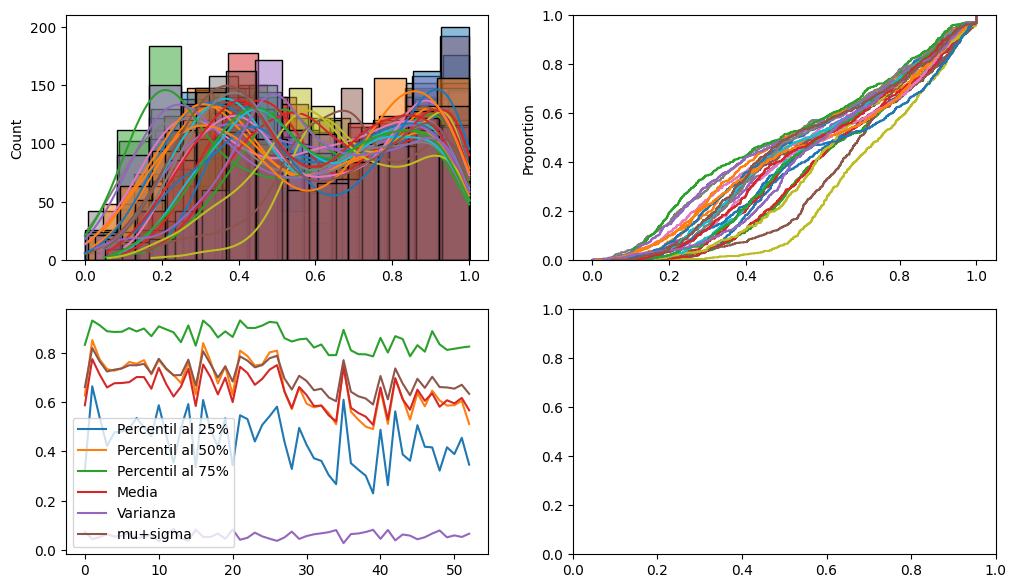

In [46]:
mats_ctrl

th25_c, th50_c, th75_c, promedio_c, varianza_c = [], [], [], [], []
mu_sigma_c = []

fig, axes = plt.subplots(2, 2, figsize=(12, 7))
for sub in mats_ctrl:
    # Calculo de estadísticos
    data = sub.stack().values
    th25.append(np.percentile(data, 25))
    th50.append(np.percentile(data, 50))
    th75.append(np.percentile(data, 75))
    promedio.append(np.mean(data))
    varianza.append(np.var(data))
    mu_sigma.append(np.mean(data) + np.var(data))
    # Plots
    sns.histplot(sub.stack().values, ax=axes[0][0], kde=True)
    sns.ecdfplot(sub.stack().values, ax=axes[0][1])
axes[1][0].plot(th25, label='Percentil al 25%')
axes[1][0].plot(th50, label='Percentil al 50%')
axes[1][0].plot(th75, label='Percentil al 75%')
axes[1][0].plot(promedio, label='Media')
axes[1][0].plot(varianza, label='Varianza')
axes[1][0].plot(mu_sigma, label='mu+sigma')
axes[1][0].legend()

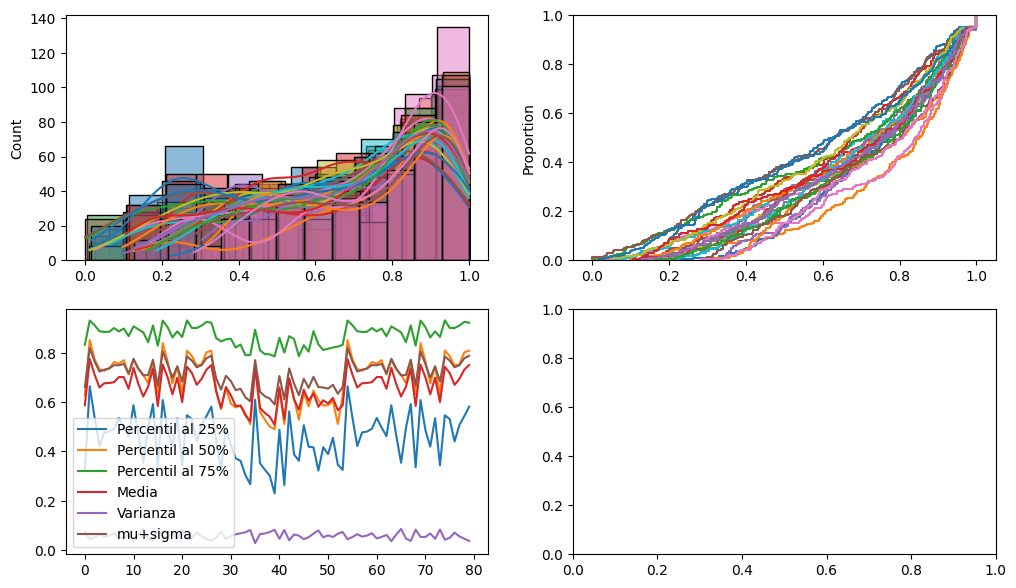

In [47]:
mats_riesgo

th25_r, th50_r, th75_r, promedio_r, varianza_r = [], [], [], [], []
mu_sigma_r = []

fig, axes = plt.subplots(2, 2, figsize=(12, 7))
for sub in mats_riesgo:
    # Calculo de estadísticos
    data = sub.stack().values
    th25.append(np.percentile(data, 25))
    th50.append(np.percentile(data, 50))
    th75.append(np.percentile(data, 75))
    promedio.append(np.mean(data))
    varianza.append(np.var(data))
    mu_sigma.append(np.mean(data) + np.var(data))
    # Plots
    sns.histplot(sub.stack().values, ax=axes[0][0], kde=True)
    sns.ecdfplot(sub.stack().values, ax=axes[0][1])
axes[1][0].plot(th25, label='Percentil al 25%')
axes[1][0].plot(th50, label='Percentil al 50%')
axes[1][0].plot(th75, label='Percentil al 75%')
axes[1][0].plot(promedio, label='Media')
axes[1][0].plot(varianza, label='Varianza')
axes[1][0].plot(mu_sigma, label='mu+sigma')
axes[1][0].legend()

In [39]:
from scipy import stats
stats.median_abs_deviation(th25)

np.float64(0.04811739724435293)

In [56]:
len(th25_c)


26

In [71]:
def calcular_estadisticos(th25, th50, th75, promedio, mu_sigma):
    columnas = [th25, th50, th75, promedio, mu_sigma]

    estadisticos_df = pd.DataFrame(
        columns=['th25', 'th50', 'th75', 'promedio', 'mu_sigma'],
        index=['min', 'max', 'mediana', 'cosa_rara']
    )

    for idx, columna in enumerate(estadisticos_df.columns):
        valores = columnas[idx]
        estadisticos_df.loc['min', columna]     = np.min(valores)
        estadisticos_df.loc['max', columna]     = np.max(valores)
        estadisticos_df.loc['mediana', columna] = np.median(valores)
        estadisticos_df.loc['cosa_rara', columna] = stats.median_abs_deviation(valores)

    return estadisticos_df


In [84]:
th25_c = []
th50_c = []
th75_c = []
promedio_c = []
varianza_c = []
mu_sigma_c = []

for sub in mats_ctrl:
    data = sub.stack().values

    th25_c.append(np.percentile(data, 25))
    th50_c.append(np.percentile(data, 50))
    th75_c.append(np.percentile(data, 75))
    promedio_c.append(np.mean(data))
    varianza_c.append(np.var(data))
    mu_sigma_c.append(np.mean(data) + np.var(data))

In [85]:
estadisticos_CTRL = calcular_estadisticos(
    th25_c, th50_c, th75_c, promedio_c, mu_sigma_c
)
print(estadisticos_CTRL)

               th25      th50      th75  promedio  mu_sigma
min        0.230243  0.490663  0.785525  0.507889  0.590315
max        0.609714  0.749537   0.89299  0.741859  0.770278
mediana    0.380179  0.586376  0.823351  0.590395  0.656191
cosa_rara  0.055834  0.053069  0.029211  0.036274  0.031099


Text(0.5, 1.0, 'umbral=0.2, poblacion>60%')

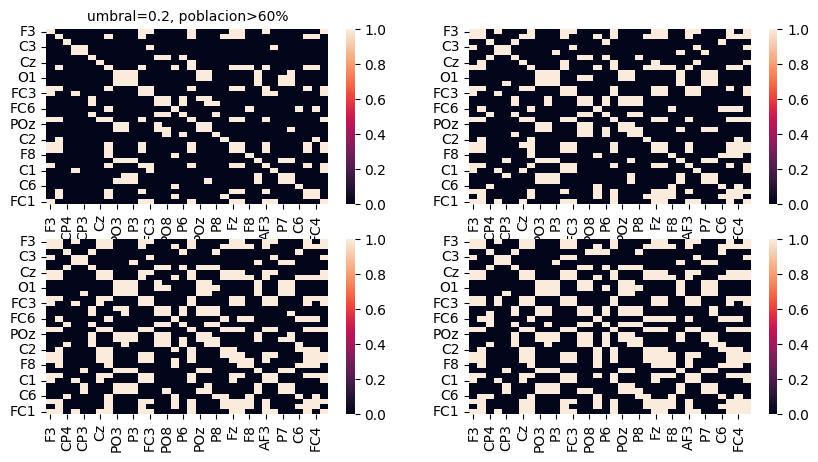

In [90]:
#Evaluación
resultadoc_df1 = capsula(mats_ctrl, 0.85, 0.7)
resultadoc_df2 = capsula(mats_ctrl, 0.8, 0.6)
resultadoc_df3 = capsula(mats_ctrl, 0.75, 0.6)
resultadoc_df4 = capsula(mats_ctrl, 0.7, 0.7)

fig, axes = plt.subplots(2, 2, figsize=(10, 5))

sns.heatmap(resultadoc_df1, ax=axes[0, 0])
sns.heatmap(resultadoc_df2, ax=axes[0, 1])
sns.heatmap(resultadoc_df3, ax=axes[1, 0])
sns.heatmap(resultadoc_df4, ax=axes[1, 1])
# plt.title('Mapas de calor para comparativa de umbrales')
axes[0, 0].set_title('umbral=0.2, poblacion>60%', fontsize=10)

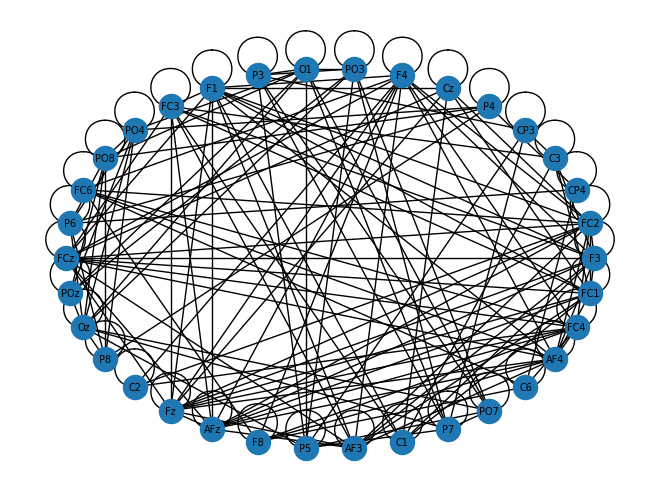

In [99]:
# Grafo 2D
ensayo_grafo = nx.from_pandas_adjacency(resultadoc_df2)
nx.draw_circular(ensayo_grafo, with_labels=True, font_size=7)

In [101]:
# Convertir de dataframe a grafo
ensayoc_grafo_ = nx.from_pandas_adjacency(resultadoc_df2)

In [100]:
def metricas_grafo(G):
  #Clusterin promedio
    clust_coeff = nx.average_clustering(G)
    # Longitud de camino promedio (camino más corto)
    try:
        path_length = nx.average_shortest_path_length(G)
    except nx.NetworkXError:
        path_length = np.nan # red no conexa
    # Coeficiente de mundo pequeño
    # Comparar con grafo aleatorio de igual N, K
    G_rand = nx.gnm_random_graph(n=G.number_of_nodes(), m=G.number_of_edges())
    clust_rand = nx.average_clustering(G_rand)
    path_rand = nx.average_shortest_path_length(G_rand)
    small_world_sigma = (clust_coeff / clust_rand) / (path_length / path_rand)
    # Modularidad
    from networkx.algorithms import community
    communities = community.greedy_modularity_communities(G)
    modularity = community.modularity(G, communities)
    # Hubs
    degree_dict = dict(G.degree())
    betwenness = nx.betweenness_centrality(G)
    betwenness = sorted(betwenness.items(), key=lambda x: x[1], reverse=True)
    # Eficiencia global y local
    global_eff = nx.global_efficiency(G)
    local_eff = nx.local_efficiency(G)

    return (clust_coeff, path_length, small_world_sigma, communities, 
            modularity, betwenness, global_eff, local_eff, degree_dict)


In [98]:
(clust_coeff_c, path_length_c, small_world_sigma_c, communities_c, 
 modularity_c, betwenness_c, global_eff_c, local_eff_c, degree_dict_c) = metricas_grafo(ensayoc_grafo_)

In [123]:
eeg_coords = pd.read_excel(
    r"C:\Users\ecere\Documents\GitHub\Neurociencias-2026-1\S06_proyecto\proyecto_Mercedes_Juárez\Datosss proyectos.xlsx"
)

# Normalizar nombres de electrodos
eeg_coords['name'] = eeg_coords['name'].astype(str).str.upper().str.strip()

# Usar 'name' como índice
eeg_coords = eeg_coords.set_index('name')

eeg_coords.head()



,x,y,z
name,,,
FP1,80.78,26.13,-4.00
FZ,60.74,0.00,59.46
F3,57.55,48.20,39.87
F7,49.87,68.42,-7.49
FC1,32.44,32.35,71.60


In [129]:
# Normalizar nombres en las comunidades
communities_c = [frozenset({c.upper() for c in com}) for com in communities_c]

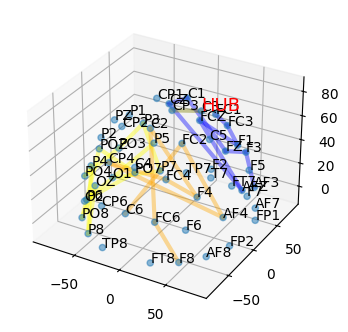

In [130]:
def grafo_comunidades(comunidades, Hub, coords, pos):
    x, y, z = coords["x"].values, coords["y"].values, coords["z"].values

    nodes_size = [30 if idx != Hub[0] else 200 for idx in coords.index] # cambiar el tamaño del nodo si es el hub
    pos.scatter(x, y, z, alpha = 0.5)
 
    for idx, (x_, y_, z_) in enumerate(zip(x, y, z)):
        pos.text(x_, y_, z_, coords.index[idx], fontsize = 10)
        if coords.index[idx] == Hub[0]:
            pos.text(x_, y_, z_, "HUB", color = "red", fontsize = 13) # cambiar el color del texto del nodo si es el hub

    colores = ["yellow", "blue", "orange", "olive", "red"]
    for n_comunidad, comunidad in enumerate(comunidades):  # recorrer las comunidades, plotearemos así las aristas
        for idx in range(len(comunidad)-1):
            n1, n2 = list(comunidad)[idx], list(comunidad)[idx+1]
            # plotear arista
            x_ = [coords.loc[n1, "x"], coords.loc[n2, "x"]]
            y_ = [coords.loc[n1, "y"], coords.loc[n2, "y"]]
            z_ = [coords.loc[n1, "z"], coords.loc[n2, "z"]]
            pos.plot(x_, y_, z_, linewidth = 3, alpha = 0.4, color = colores[n_comunidad])


hub = betwenness_c[0]

fig = plt.figure(figsize=(4,4))
axes = [fig.add_subplot(1, 1, 1, projection = "3d")]
grafo_comunidades(communities_c, hub, eeg_coords, axes[0])

In [122]:
eeg_coords = pd.read_excel(r"C:\Users\ecere\Documents\GitHub\Neurociencias-2026-1\S06_proyecto\proyecto_Mercedes_Juárez\Datosss proyectos.xlsx")
eeg_coords.head()
print("Columnas:", eeg_coords.columns.tolist())


Columnas: ['name', 'x', 'y', 'z']


In [110]:
print(communities_c)

[frozenset({'P7', 'O1', 'P3', 'POz', 'Oz', 'P6', 'PO4', 'P4', 'P8', 'PO8', 'PO7', 'PO3', 'P5'}), frozenset({'AF3', 'F3', 'C1', 'FCz', 'F1', 'FC3', 'FC1', 'Cz', 'Fz', 'AFz'}), frozenset({'C6', 'FC2', 'AF4', 'CP4', 'FC4', 'F8', 'F4', 'C2', 'FC6'}), frozenset({'C3', 'CP3'})]


In [73]:
th25_r = []
th50_r = []
th75_r = []
promedio_r = []
varianza_r = []
mu_sigma_r = []

for sub in mats_riesgo:
    data = sub.stack().values

    th25_r.append(np.percentile(data, 25))
    th50_r.append(np.percentile(data, 50))
    th75_r.append(np.percentile(data, 75))
    promedio_r.append(np.mean(data))
    varianza_r.append(np.var(data))
    mu_sigma_r.append(np.mean(data) + np.var(data))

In [76]:
estadisticos_RISK = calcular_estadisticos(
    th25_r, th50_r, th75_r, promedio_r, mu_sigma_r
)
print(estadisticos_RISK)

               th25      th50      th75  promedio  mu_sigma
min        0.325091  0.626811  0.828894   0.58418  0.660932
max        0.664197  0.851419  0.931241   0.77473  0.819259
mediana    0.494858  0.753019   0.89838  0.694273  0.749384
cosa_rara  0.048117   0.02571  0.013306  0.034848  0.025337


Text(0.5, 1.0, 'umbral=0.2, poblacion>60%')

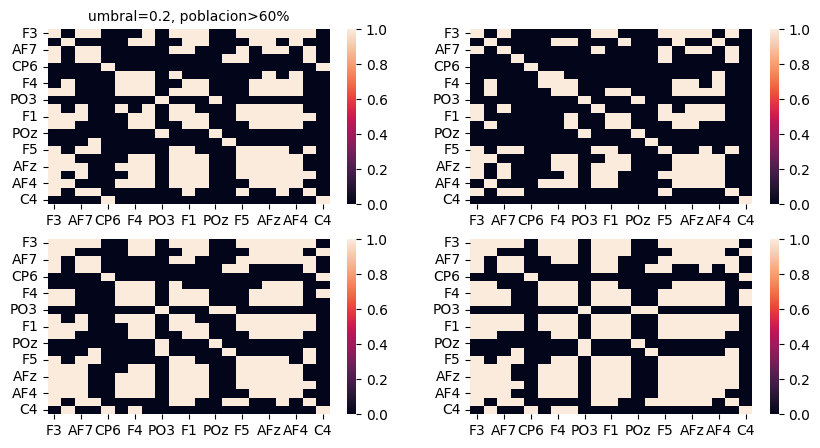

In [93]:
#Evaluación
resultador_df1 = capsula(mats_riesgo, 0.8, 0.6)
resultador_df2 = capsula(mats_riesgo, 0.85, 0.7)
resultador_df3 = capsula(mats_riesgo, 0.75, 0.7)
resultador_df4 = capsula(mats_riesgo, 0.7, 0.6)

fig, axes = plt.subplots(2, 2, figsize=(10, 5))

sns.heatmap(resultador_df1, ax=axes[0, 0])
sns.heatmap(resultador_df2, ax=axes[0, 1])
sns.heatmap(resultador_df3, ax=axes[1, 0])
sns.heatmap(resultador_df4, ax=axes[1, 1])
# plt.title('Mapas de calor para comparativa de umbrales')
axes[0, 0].set_title('umbral=0.2, poblacion>60%', fontsize=10)

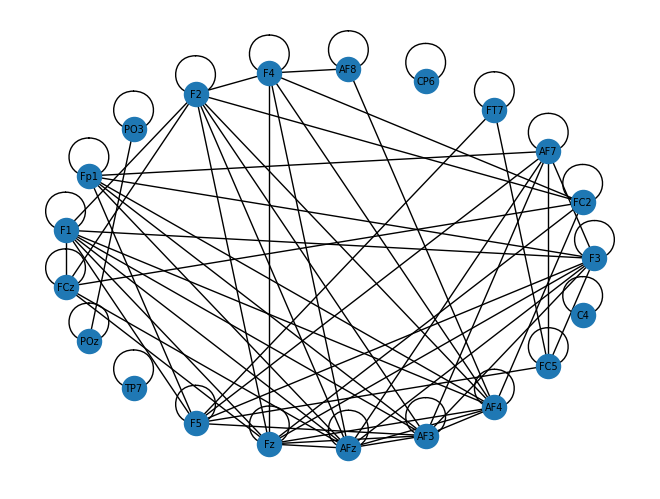

In [131]:
# Grafo 2D
ensayo_grafo = nx.from_pandas_adjacency(resultador_df2)
nx.draw_circular(ensayo_grafo, with_labels=True, font_size=7)

In [132]:
# Convertir de dataframe a grafo
ensayoc_grafo_ = nx.from_pandas_adjacency(resultador_df2)

In [134]:
(clust_coeff_r, path_length_r, small_world_sigma_r, communities_r, 
 modularity_r, betwenness_r, global_eff_r, local_eff_r, degree_dict_r) = metricas_grafo(ensayoc_grafo_)

In [136]:
communities_r = [frozenset({c.upper() for c in com}) for com in communities_r]


In [139]:
communities_r = [
    frozenset({("FC3" if c == "FC5" else c) for c in com})
    for com in communities_r
]

communities_c = [
    frozenset({("FC3" if c == "FC5" else c) for c in com})
    for com in communities_c
]


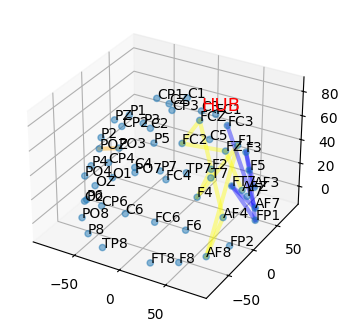

In [140]:
def grafo_comunidades(comunidades, Hub, coords, pos):
    x, y, z = coords["x"].values, coords["y"].values, coords["z"].values

    nodes_size = [30 if idx != Hub[0] else 200 for idx in coords.index] # cambiar el tamaño del nodo si es el hub
    pos.scatter(x, y, z, alpha = 0.5)
 
    for idx, (x_, y_, z_) in enumerate(zip(x, y, z)):
        pos.text(x_, y_, z_, coords.index[idx], fontsize = 10)
        if coords.index[idx] == Hub[0]:
            pos.text(x_, y_, z_, "HUB", color = "red", fontsize = 13) # cambiar el color del texto del nodo si es el hub

    colores = ["yellow", "blue", "orange", "olive", "red"]
    for n_comunidad, comunidad in enumerate(comunidades):  # recorrer las comunidades, plotearemos así las aristas
        for idx in range(len(comunidad)-1):
            n1, n2 = list(comunidad)[idx], list(comunidad)[idx+1]
            # plotear arista
            x_ = [coords.loc[n1, "x"], coords.loc[n2, "x"]]
            y_ = [coords.loc[n1, "y"], coords.loc[n2, "y"]]
            z_ = [coords.loc[n1, "z"], coords.loc[n2, "z"]]
            pos.plot(x_, y_, z_, linewidth = 3, alpha = 0.4, color = colores[n_comunidad])


hub = betwenness_c[0]

fig = plt.figure(figsize=(4,4))
axes = [fig.add_subplot(1, 1, 1, projection = "3d")]
grafo_comunidades(communities_r, hub, eeg_coords, axes[0])